# How to Win a Data Science Competition: 
## Learn from Top Kaggler
### Final Task

In [1]:
import platform
print(platform.processor())
if 'Model 142' in platform.processor():
    REDUCED_MODE = True
else:
    REDUCED_MODE = False
REDUCED_MODE

Intel64 Family 6 Model 94 Stepping 3, GenuineIntel


False

In [2]:
import pandas as pd
import numpy as np
import pickle
import calendar
import seaborn as sns


import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data


In [3]:
f='../data/'
test          = pd.read_csv(f+'test.csv.gz')
shop          = pd.read_csv(f+'shops.csv')
sample_submission    = pd.read_csv(f+'sample_submission.csv.gz')
sales         = pd.read_csv(f+'sales_train.csv.gz')
items         = pd.read_csv(f+'items.csv')
item_category = pd.read_csv(f+'item_categories.csv')

# Aggregate data
Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation. 

In [4]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.sample(30)

,shop_id,item_id,date_block_num
4281633,4,20781,11
9668257,35,5485,28
8870616,53,15835,25
49197,18,5575,0
9977806,52,19474,29
9081730,31,18441,26
9158440,51,6838,26
5718809,42,492,15
8014248,25,2500,22
5112597,45,8266,13


# Exploratory Data Analysis

There is 60 unique shop_id

In [5]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

There is 60 unique item_category_id.

In [6]:
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

There is 22170 unique item_id.

In [7]:
items.loc[42].item_name

'100 Best romantic melodies (mp3-CD) (Digipack)'

In [8]:
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

Review the format for submission.

In [9]:
test.head(5)
sample_submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Finally, the main dataset for training data. 

In [10]:
sales.head(5)
sales.describe()
len(sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


2935849

# Plot of date_block_num against index. 

The distribution of each date_block_num is not balanced, there are some outliers

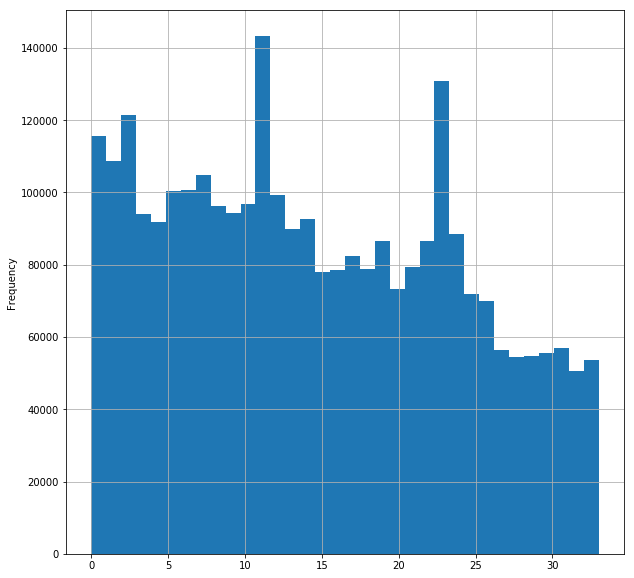

In [11]:
bins =(sales.date_block_num.unique()) 
sales.date_block_num.plot.hist(bins = len(bins),figsize = (10,10), grid = True)


['2013.01', '2013.02', '2013.03', '2013.04', '2013.05', '2013.06', '2013.07', '2013.08', '2013.09', '2013.10', '2013.11', '2013.12', '2014.01', '2014.02', '2014.03', '2014.04', '2014.05', '2014.06', '2014.07', '2014.08', '2014.09', '2014.10', '2014.11', '2014.12', '2015.01', '2015.02', '2015.03', '2015.04', '2015.05', '2015.06', '2015.07', '2015.08', '2015.09']


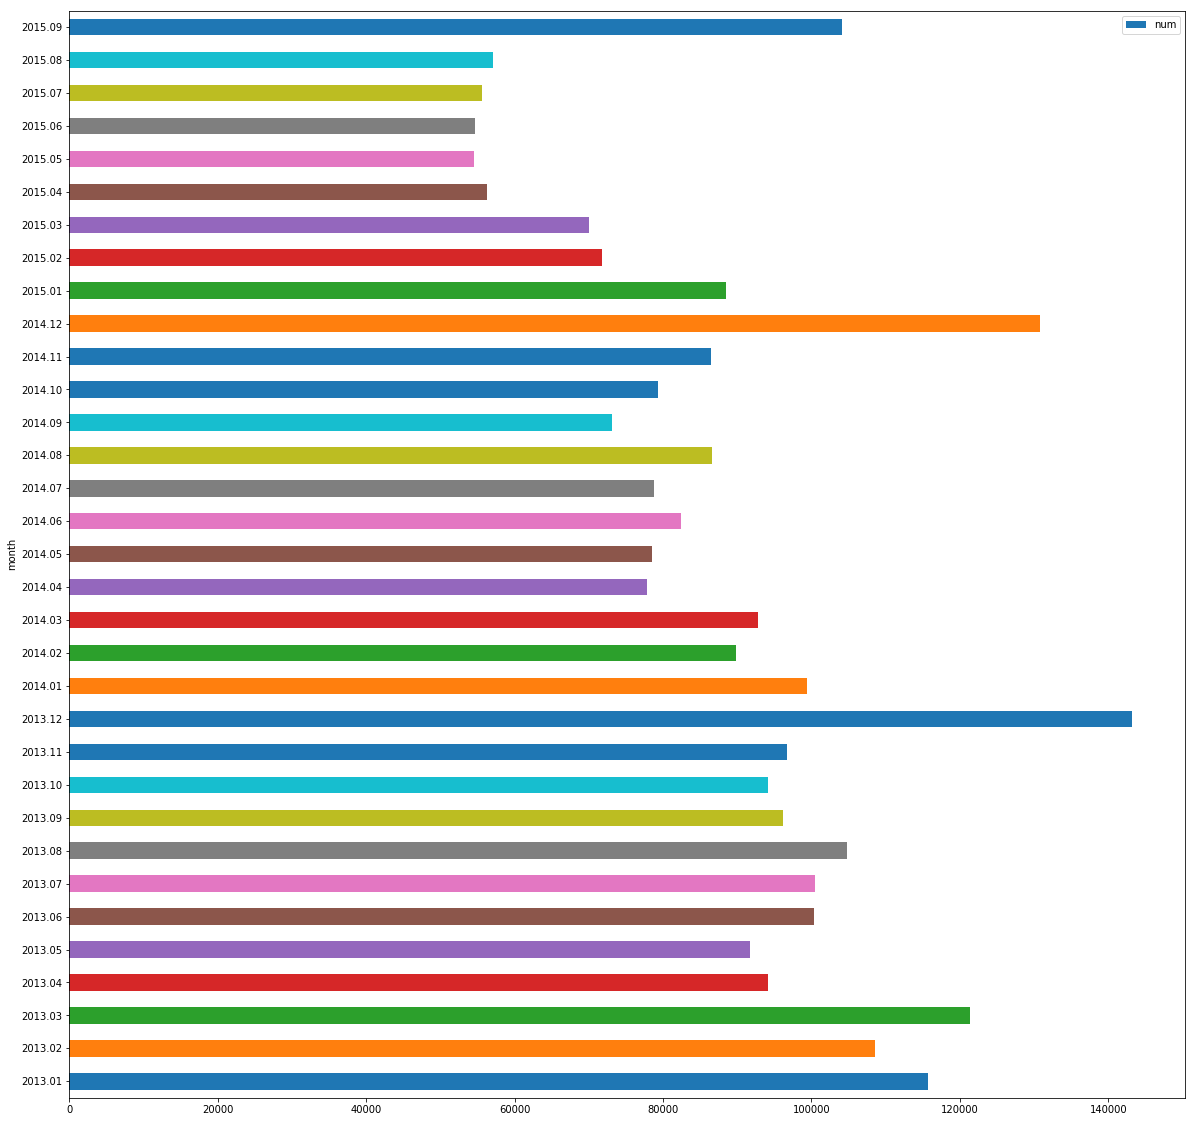

In [12]:
import calendar
date_block_labels = []
y_i,m_i = 2013,1
for i in range(33):
    y = y_i+ i//12
    m = m_i + np.mod(i,12)
    date_block_labels.append('%4d.%02d'%(y,m))
print(date_block_labels)

month_stat = pd.DataFrame( )
count, division = np.histogram(sales.date_block_num, bins=bins)


month_stat = pd.DataFrame(data={'month':date_block_labels, 'num':count})
month_stat.plot.barh(x='month', y='num', figsize=(20,20))

We can see peaks in December. It sounds reasonable

# Shops Leakage utilization

Shops geography aren't anonimized, so we can substact some information from the feature names

In [13]:
#This addresses are seems to be the same
for i in [10,11]:
    print(shop.loc[i].shop_name)
print('-'*20)
shop.at[10,'shop_name']=shop.loc[11,'shop_name']

#Remove ! sign from city name
shop.shop_name = shop.shop_name.apply(lambda x: x.replace('!',''))
   

# Group to e-shops into single category
print(shop.loc[55].shop_name)
print(shop.loc[12].shop_name)
shop.at[55,'shop_name']='Интернет-магазин '+shop.at[55,'shop_name']

display(shop)


Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²
--------------------
Цифровой склад 1С-Онлайн
Интернет-магазин ЧС


,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Cut city name from the shop name, also normalize city name. Thanks God I'm Russian and can identify Russian cities by their acronyms :)

In [14]:
from sklearn.preprocessing import LabelEncoder
shop['shop_city'] = shop['shop_name'].str.split().str[0].str.strip()

# Parse results of city parser, normalize city names
replace_table=[
     ['РостовНаДону', 'Ростов-на-Дону',]
    ,['СПб'         , 'Санкт-Петербург']
    ,['Адыгея'      , 'Краснодар'      ] # Адыгея ТЦ "Мега" locates in Krasnodar City
    ,['Н.Новгород'  , 'Нижний Новгород']
    ,['Сергиев'     , 'Сергиев Посад'  ] # Two word city name wasn't parsed in a correct way
]
for w in replace_table:
    shop.shop_city = shop.shop_city.apply(lambda x: x.replace(w[0],w[1]))
    
shop['shop_city_id'] = LabelEncoder().fit_transform(shop['shop_city'])
display(shop)


,shop_name,shop_id,shop_city,shop_city_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2
6,"Воронеж (Плехановская, 13)",6,Воронеж,3
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3
9,Выездная Торговля,9,Выездная,4


In [15]:
print('Unique shops  %2d'%len(shop.shop_name.unique()))
print('Unique cities %2d'%len(shop.shop_city.unique()))


Unique shops  59
Unique cities 30


Download Russian Cities database in JSON https://github.com/pensnarik/russian-cities 

In [16]:
ru_cities = pd.read_json('../russian-cities.json',encoding='utf-8')
display(ru_cities.head(10))
city2pop  = dict(zip(ru_cities.name, ru_cities.population))
city2subj = dict(zip(ru_cities.name, ru_cities.subject))


,coords,district,name,population,subject
0,"{'lat': '52.65', 'lon': '90.08333'}",Сибирский,Абаза,17111,Хакасия
1,"{'lat': '53.71667', 'lon': '91.41667'}",Сибирский,Абакан,186619,Хакасия
2,"{'lat': '53.68333', 'lon': '53.65'}",Приволжский,Абдулино,20663,Оренбургская область
3,"{'lat': '44.86667', 'lon': '38.16667'}",Южный,Абинск,34926,Краснодарский край
4,"{'lat': '55.9', 'lon': '53.93333'}",Приволжский,Агидель,16365,Башкортостан
5,"{'lat': '56.51667', 'lon': '52.98333'}",Приволжский,Агрыз,19299,Татарстан
6,"{'lat': '44.884525', 'lon': '39.19202'}",Южный,Адыгейск,12689,Адыгея
7,"{'lat': '54.85', 'lon': '53.06667'}",Приволжский,Азнакаево,34859,Татарстан
8,"{'lat': '47.1', 'lon': '39.41667'}",Южный,Азов,82882,Ростовская область
9,"{'lat': '51.16667', 'lon': '90.6'}",Сибирский,Ак-Довурак,13469,Тыва


In [17]:
shop['shop_city_pop' ] = shop['shop_city'].map(city2pop).fillna(-1).astype('int32')
shop['shop_city_subj'] = shop['shop_city'].map(city2subj).fillna('not-a-city')
shop['shop_city_subj_id'] = LabelEncoder().fit_transform(shop['shop_city_subj'])

display(shop)

,shop_name,shop_id,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28,269486,Якутия,21
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28,269486,Якутия,21
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10,744933,Краснодарский край,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,215353,Московская область,10
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,314436,Волгоградская область,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2,301642,Вологодская область,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,3,889680,Воронежская область,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3,889680,Воронежская область,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3,889680,Воронежская область,4
9,Выездная Торговля,9,Выездная,4,-1,not-a-city,0


Cool! So we generated new heuristic features from geography, which may be helpful for classifier
* Shop City
* Shop City population, no we can aggregate data for small cities and big one
* Shop City subject, which also may be usefull. 

# Explore Item Categories

In [18]:
pd.set_option("display.max_rows", 101)

# Create meta-categories, buy just splitting left word from category name

# As splitter use sign "(" or "-"

item_category['item_metacategory_name'] = item_category['item_category_name'].str.split('-|\\(').str[0].str.strip()
item_category['item_metacategory_id']   = LabelEncoder().fit_transform(item_category['item_metacategory_name'])

display(item_category)

print('Unique categories      %2d'%len(item_category.item_category_name.unique()))
print('Unique meta-categories %2d'%len(item_category.item_metacategory_name.unique()))


,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1
5,Аксессуары - PSVita,5,Аксессуары,1
6,Аксессуары - XBOX 360,6,Аксессуары,1
7,Аксессуары - XBOX ONE,7,Аксессуары,1
8,Билеты (Цифра),8,Билеты,2
9,Доставка товара,9,Доставка товара,3


Unique categories      84
Unique meta-categories 18


# Explore Item Names

Spoiler : this approach didn't bring any result.

In [19]:
items.sample(100)

,item_name,item_id,item_category_id
3253,EyePet и Друзья (Essentials) (только для PS Mo...,3253,19
19499,Сумка URBAN TOOL SlotBar mudd,19499,61
5655,PS4: Вертикальный стенд для PS4 (CUH-ZST1/E Bl...,5655,3
9129,"БУХ.1С, №6, Июнь 2015 [Цифровая версия]",9129,54
16536,ОКЕАН ЕЛЬЗИ Dolce Vita,16536,55
2482,DAVIS MILES Doo-Bop LP,2482,58
20105,"УСПЕНСКАЯ ЛЮБОВЬ К единственному, нежному",20105,55
850,"1С:Школа. Алгебра, 7–9 классы. 2-е изд. испр. ...",850,77
21745,ЧУДАКИ 3 (BD),21745,37
1845,"Battlefield 3: End Game [PC, Цифровая версия]",1845,31


From forum we know that naive TF_IDF features are not useful and it makes sense - here we have very specific set of strings.

We should use instead some more heuristic, prior-knowledge features.

Let's have a look, can make a features based on games name

In [20]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']
for g in games:
    df  = items[items['item_name'].str.contains(g)]
    display(df)
    print('Found %d verisions of %s'%(len(df),g))

,item_name,item_id,item_category_id
5228,Need for Speed Most Wanted (Classics) (рус.в.)...,5228,30
5229,"Need for Speed Most Wanted (EA) [PC, Цифровая ...",5229,31
5230,"Need for Speed Most Wanted [Android, Цифровая ...",5230,26


Found 3 verisions of Need for Speed Most Wanted


,item_name,item_id,item_category_id
2282,"Call of Duty: Advanced Warfare [PC, Цифровая в...",2282,31
2283,"Call of Duty: Advanced Warfare [PC, русская ве...",2283,30
2284,"Call of Duty: Advanced Warfare [PS3, русская в...",2284,19
2285,"Call of Duty: Advanced Warfare [PS4, русская в...",2285,20
2286,"Call of Duty: Advanced Warfare [Xbox 360, русс...",2286,23
2287,"Call of Duty: Advanced Warfare [Xbox One, русс...",2287,24
2288,Call of Duty: Advanced Warfare. Atlas Limited ...,2288,28
2289,Call of Duty: Advanced Warfare. Atlas Limited ...,2289,20
2290,Call of Duty: Advanced Warfare. Atlas Limited ...,2290,24
2291,Call of Duty: Advanced Warfare. Atlas Pro Edit...,2291,20


Found 22 verisions of Call of Duty: Advanced Warfare


,item_name,item_id,item_category_id
7569,WARHAMMER 40000 ACCESSORIES: Warhammer 40000 R...,7569,64
7777,"Warhammer 40000 Dawn of War. Retribution [PC, ...",7777,30
7778,Warhammer 40000 Dawn of War. Retribution. Косм...,7778,28
7779,Warhammer 40000. Dawn of War Soulstorm (PC-DVD...,7779,30
13154,Классика жанра. Warhammer 40000 Dawn of War. R...,13154,30
19296,Сборник Premium Games. Warhammer 40000. Dawn o...,19296,30


Found 6 verisions of Warhammer 40000


,item_name,item_id,item_category_id
3713,"Grand Theft Auto IV (Classics) [Xbox 360, русс...",3713,23
3714,Grand Theft Auto IV (full eng) (PS3) (Case Set),3714,19
3715,"Grand Theft Auto IV (СофтКлаб) [PC, Цифровая в...",3715,31
3716,"Grand Theft Auto IV Complete Edition [PS3, анг...",3716,19
3717,Grand Theft Auto IV Complete Edition [Xbox 360...,3717,23
3718,Grand Theft Auto IV DVD,3718,30
3719,"Grand Theft Auto IV. Полное издание [PC, Jewel...",3719,30


Found 7 verisions of Grand Theft Auto IV


That looks interestring actually. Some games are presented in several categories, so we could make a vocabullary of game and identify if name of item contains this game name. Let's grag the names from Wikipedia

In [21]:
# Read list of games from Wikipedia

import os
from wikitables import import_tables
import string

games_file = 'games_list.pkl'

if os.path.isfile(games_file):    # True
    all_games=pd.read_pickle(games_file )
    print('List of games was read from file %s'%games_file)
else:
    idx=list(string.ascii_uppercase)
    idx.append('Numerical')
    game_list=[]
    for i in idx:
        if i=='A':
            page_name='List_of_PC_games'
        else:
            page_name='List_of_PC_games_(%s)'%i

        tables = import_tables(page_name) 
        if i=='Numerical':
            filed='Title'
        else:
            filed='Name'

        game_list+=[str(r[filed]) for r in tables[0].rows] 
    print('Total games: %3d'%len(game_list))
    all_games = pd.DataFrame(game_list,columns=['game_name'])
    all_games.to_pickle(games_file)
all_games.sample(20)


List of games was read from file games_list.pkl


,game_name
288,Dungeon Keeper
276,Dragon Quest X
277,Dragon's Dogma
482,Metal Gear
31,Age of Chivalry
129,Battleground 9: Chickamauga
483,Metal Gear 2: Solid Snake
263,Dino D-Day
367,Gothic 3
342,Final Fantasy VIII


Let's have a look can we found our games in the list of downloaded games

In [22]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']

for g in games:
    print(all_games[all_games['game_name'].str.contains(g)])

Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
               game_name
377  Grand Theft Auto IV


But fast approach didn't lead to success, because games in tables are not normalized. We can think about tokenization of game names. I.e.
* Remove from names special signs
* Remove spaces
* Shorten names in vocabullary 
* Try to find shorten normalized names in items name



# Plot of shop_id against item_id on train and test data

Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences

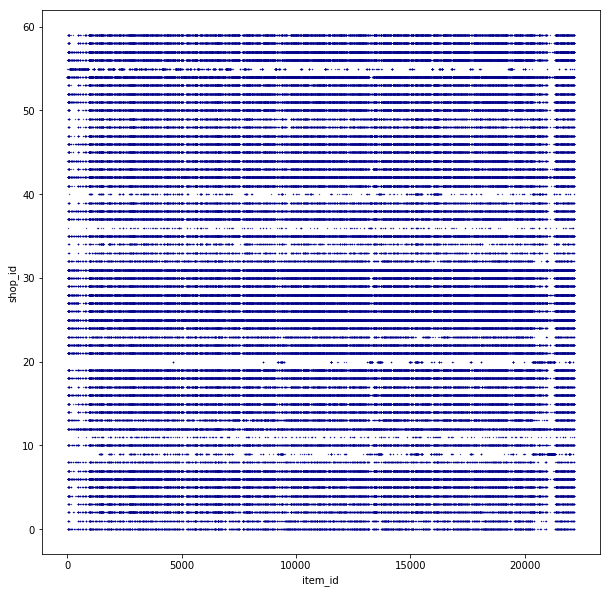

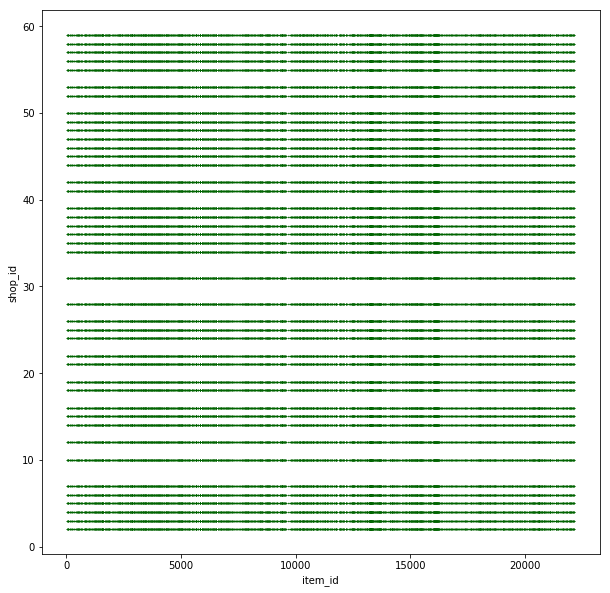

In [23]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1,figsize = (10,10))
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1,figsize = (10,10))



We can see that after merging sales data on test data, there is about 50% of missing values.

In [24]:
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


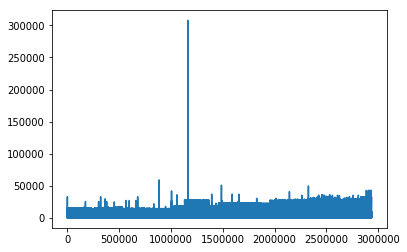

In [25]:
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]


For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.

In [26]:
from IPython.display import display, HTML



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
845690,18.09.2013,8,42,3732,2521.211982,217.0
862929,17.09.2013,8,25,3732,2545.135417,264.0
890790,17.09.2013,8,31,3732,2550.597222,288.0
1058340,22.11.2013,10,12,11373,102.466942,242.0
1170072,28.12.2013,11,15,20949,5.000000,255.0
1501160,15.03.2014,14,24,20949,5.000000,405.0
1549966,09.04.2014,15,54,20949,5.000000,300.0
1573252,23.04.2014,15,27,8057,1200.000000,401.0
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1618930,23.04.2014,15,29,8057,1200.000000,240.0


3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
11373                                  Доставка до пункта выдачи (Boxberry)
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
9242     Билет "ИгроМир 2014" (на один день (отдельно - 4, 5 октября 2014))
19437       

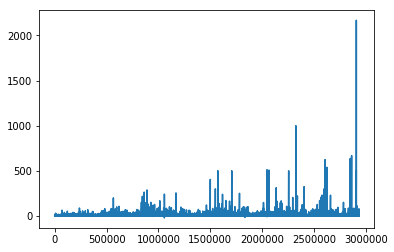

In [27]:
sales.item_cnt_day.plot()

popular_sales = sales[sales['item_cnt_day'] >200]
display(popular_sales)
pd.options.display.max_colwidth = 100
print(items.loc[popular_sales.item_id].item_name)

Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.

In [28]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [29]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

sales_m = pd.merge(grid,sales_m, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

sales_m['date_block_month'] = np.mod(sales_m['date_block_num'],12)
sales_m = pd.merge(sales_m,shop          , on=['shop_id']          , how='left' )
sales_m = pd.merge(sales_m,items         , on=['item_id']          , how='left' )
sales_m = pd.merge(sales_m,item_category , on=['item_category_id'] , how='left' )

print('Drop all string columns, leave encoded only');
string_columns =[             'item_name',
                     'item_category_name',
                 'item_metacategory_name',
                              'shop_name',
                 'shop_city',
                 'shop_city_subj']
sales_m = sales_m.drop(columns=string_columns);

print('Convert numerical feature to int16')
sales_m.item_price = sales_m.item_price.astype('int16');


display(sales_m.sample(100))



Drop all string columns, leave encoded only
Convert numerical feature to int16


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
5440825,16,5196,14,0.0,0,2,9,144642,10,31,8
865759,56,6661,2,1.0,419,2,27,60677,10,21,5
7047793,5,16665,19,0.0,0,7,2,301642,3,37,10
2788481,56,16480,7,0.0,0,7,27,60677,10,38,10
6711731,6,3049,18,0.0,0,6,3,889680,4,30,8
5792669,31,5224,15,0.0,0,3,13,11514330,9,30,8
4584445,35,18332,12,0.0,0,0,15,1250615,11,57,12
5272744,25,15526,14,0.0,0,2,13,11514330,9,70,13
3293939,38,18612,8,0.0,0,8,17,1154000,13,37,10
4170787,31,6578,11,1.0,549,11,13,11514330,9,25,5


# Mean encoding

We perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [30]:
mean_enc_cols = []
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [ ('item_price',np.mean,'avg'),
                                           ('item_cnt_day',np.sum,'sum'),
                                           ('item_cnt_day',np.mean,'avg')]:

        col_name = type_id+'_'+func_name+'_'+column_id
        print('Mean econding %s....'%col_name)
        mean_enc_cols.append(col_name)  
        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [col_name , type_id, 'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

Mean econding item_id_avg_item_price....
Mean econding item_id_sum_item_cnt_day....
Mean econding item_id_avg_item_cnt_day....
Mean econding shop_id_avg_item_price....
Mean econding shop_id_sum_item_cnt_day....
Mean econding shop_id_avg_item_cnt_day....
Mean econding item_category_id_avg_item_price....
Mean econding item_category_id_sum_item_cnt_day....
Mean econding item_category_id_avg_item_cnt_day....


In [31]:
display(sales_m.head(10))
display(sales_m.tail(10))

,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999,0,29,591486,22,37,10,310.800000,18.0,0.400000,97.969563,2017.0,0.248552,63.006981,6094.0,0.199738
1,59,2552,0,0.0,0,0,29,591486,22,58,12,19.977778,0.0,0.000000,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
2,59,2554,0,0.0,0,0,29,591486,22,58,12,37.977778,1.0,0.022222,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
3,59,2555,0,0.0,0,0,29,591486,22,56,12,48.822222,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
4,59,2564,0,0.0,0,0,29,591486,22,59,12,36.400000,5.0,0.111111,97.969563,2017.0,0.248552,35.593613,701.0,0.093280
5,59,2565,0,0.0,0,0,29,591486,22,56,12,24.400000,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
6,59,2572,0,0.0,0,0,29,591486,22,55,12,56.555556,12.0,0.266667,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
7,59,2573,0,0.0,0,0,29,591486,22,55,12,73.088889,16.0,0.355556,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
8,59,2574,0,2.0,399,0,29,591486,22,55,12,258.000000,119.0,2.644444,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
9,59,2593,0,0.0,0,0,29,591486,22,55,12,28.244444,5.0,0.111111,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
10913840,21,7610,33,0.0,0,9,13,11514330,9,64,13,65.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913841,21,7612,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913842,21,7615,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913843,21,7627,33,0.0,0,9,13,11514330,9,64,13,7.931818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913844,21,7628,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913845,21,7635,33,0.0,0,9,13,11514330,9,64,13,47.727273,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913846,21,7638,33,0.0,0,9,13,11514330,9,64,13,42.954545,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913847,21,7640,33,0.0,0,9,13,11514330,9,64,13,91.818182,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913848,21,7632,33,0.0,0,9,13,11514330,9,64,13,52.500000,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913849,21,7440,33,0.0,0,9,13,11514330,9,57,12,6.795455,1.0,0.022727,186.033623,1912.0,0.353224,15.547865,364.0,0.062672


We append test data into train data so we can create lag features on them.

In [32]:
temp_test = test.copy()

TEST_DATE_BLOCK_ID = 34

temp_test['date_block_num'] = TEST_DATE_BLOCK_ID
temp_test['date_block_month'] = np.mod(temp_test['date_block_num'],12).astype(np.int16)

temp_test.drop('ID', axis=1, inplace=True)
temp_test = temp_test.merge(shop          , how='left' ,on=['shop_id'] )
temp_test = temp_test.merge(items         , how='left', on='item_id')
temp_test = temp_test.merge(item_category , how='left', on='item_category_id')


string_columns =[             'item_name',
                     'item_category_name',
                 'item_metacategory_name',
                              'shop_name',
                 'shop_city',
                 'shop_city_subj']

temp_test = temp_test.drop(columns=string_columns);




In [33]:
display(temp_test)

,shop_id,item_id,date_block_num,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
0,5,5037,34,10,2,301642,3,19,5
1,5,5320,34,10,2,301642,3,55,12
2,5,5233,34,10,2,301642,3,19,5
3,5,5232,34,10,2,301642,3,23,5
4,5,5268,34,10,2,301642,3,20,5
5,5,5039,34,10,2,301642,3,23,5
6,5,5041,34,10,2,301642,3,20,5
7,5,5046,34,10,2,301642,3,55,12
8,5,5319,34,10,2,301642,3,55,12
9,5,5003,34,10,2,301642,3,20,5


In [34]:
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True,sort=False)

In [35]:
display(sales_m.head(10))
display(sales_m.sample(10))
display(sales_m.tail(10))


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,0,29,591486,22,37,10,310.800000,18.0,0.400000,97.969563,2017.0,0.248552,63.006981,6094.0,0.199738
1,59,2552,0,0.0,0.0,0,29,591486,22,58,12,19.977778,0.0,0.000000,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
2,59,2554,0,0.0,0.0,0,29,591486,22,58,12,37.977778,1.0,0.022222,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
3,59,2555,0,0.0,0.0,0,29,591486,22,56,12,48.822222,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
4,59,2564,0,0.0,0.0,0,29,591486,22,59,12,36.400000,5.0,0.111111,97.969563,2017.0,0.248552,35.593613,701.0,0.093280
5,59,2565,0,0.0,0.0,0,29,591486,22,56,12,24.400000,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
6,59,2572,0,0.0,0.0,0,29,591486,22,55,12,56.555556,12.0,0.266667,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
7,59,2573,0,0.0,0.0,0,29,591486,22,55,12,73.088889,16.0,0.355556,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
8,59,2574,0,2.0,399.0,0,29,591486,22,55,12,258.000000,119.0,2.644444,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
9,59,2593,0,0.0,0.0,0,29,591486,22,55,12,28.244444,5.0,0.111111,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
8774468,41,14259,25,0.0,0.0,1,18,1091544,14,37,10,4.212766,2.0,0.042553,96.756154,925.0,0.152817,39.801735,4847.0,0.153464
7100206,14,8078,19,0.0,0.0,7,7,1216965,17,37,10,15.607843,4.0,0.078431,75.726858,1239.0,0.194719,35.886051,5992.0,0.139372
2544470,57,20028,6,2.0,149.0,6,28,269486,21,37,10,46.847826,30.0,0.652174,163.626413,5827.0,0.693278,54.347253,8623.0,0.224768
2124973,26,9919,5,1.0,149.0,5,13,11514330,9,37,10,19.434783,6.0,0.130435,88.900330,2661.0,0.313871,51.949257,6763.0,0.185399
10599630,24,7984,32,0.0,0.0,8,13,11514330,9,7,1,37.023256,4.0,0.093023,163.038151,1492.0,0.293412,552.730722,244.0,0.298654
3822263,41,1913,10,0.0,0.0,10,18,1091544,14,30,8,11.066667,3.0,0.066667,91.700828,2319.0,0.286686,142.325845,16794.0,1.352174
4911703,10,18300,13,0.0,0.0,1,5,102729,10,55,12,2.521739,2.0,0.043478,46.895711,837.0,0.117325,41.340435,9442.0,0.195487
8536967,21,20076,24,0.0,0.0,0,13,11514330,9,37,10,5.980000,1.0,0.020000,168.507086,1923.0,0.313243,48.082570,5959.0,0.184489
11103692,46,3447,34,NaN,NaN,10,21,110878,10,29,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10425693,7,2755,31,0.0,0.0,7,3,889680,4,23,5,23.785714,1.0,0.023810,149.833399,1409.0,0.275842,337.733364,3650.0,0.557082


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
11128040,45,3280,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128041,45,4393,34,NaN,NaN,10,19,1164900,15,22,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128042,45,4352,34,NaN,NaN,10,19,1164900,15,22,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128043,45,18049,34,NaN,NaN,10,19,1164900,15,70,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128044,45,18027,34,NaN,NaN,10,19,1164900,15,70,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128045,45,18454,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128046,45,16188,34,NaN,NaN,10,19,1164900,15,64,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128047,45,15757,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128048,45,19648,34,NaN,NaN,10,19,1164900,15,40,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128049,45,969,34,NaN,NaN,10,19,1164900,15,37,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [36]:
lag_variables = mean_enc_cols + ['item_cnt_day'] 
print('===== Lag Variables =======');
print('\n'.join(lag_variables))
print('='*30)

raw_sales_file = 'raw_sales_m.pickle'



#Limited by computation resource

if REDUCED_MODE:
    lags = [1,2]
else:
    lags = [1, 2, 3, 4, 6, 12]

SKIP = 1
if SKIP:
    sales_m = pd.read_pickle(raw_sales_file)    
    print('Features read %s' % raw_sales_file)
else:    
    for lag in lags:
        print('In progress %2d ...'% lag)
        sales_new_df = sales_m.copy()
        sales_new_df.date_block_num+=lag
        sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]

        sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]

        sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')
    del sales_new_df
    print('Features created!')

    print('Save them...')

    sales_m.to_pickle(raw_sales_file)
    print('Features saved %s' % raw_sales_file)

===== Lag Variables =======
item_id_avg_item_price
item_id_sum_item_cnt_day
item_id_avg_item_cnt_day
shop_id_avg_item_price
shop_id_sum_item_cnt_day
shop_id_avg_item_cnt_day
item_category_id_avg_item_price
item_category_id_sum_item_cnt_day
item_category_id_avg_item_cnt_day
item_cnt_day
Features read raw_sales_m.pickle


Fill missing values


<div class="panel panel-warning">

NaN filled with median and zeros for XGBoost

<div class="panel-body">

Catboost can work with NaN

</div>

</div>

In [37]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [38]:
sales_m = sales_m[sales_m['date_block_num']>12]

# Train/Test/Validation split

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing. 

In [39]:
cols_to_drop = lag_variables[:-1] + ['item_price']

sales_m = sales_m.drop(cols_to_drop, axis=1)
#------------------------------------------------------
#  From discussion in Kaggle forum, 
#  we applied this useful trick, 
#  which clip the item_cnt_day within 40 instead of 20. 
#  In this way, there are more predictions on item_cnt_day = 20.
#------------------------------------------------------
sales_m['item_cnt_day'].clip(lower=0, upper=40,inplace=True)
def date_split_transactions(df):
    df_train = df[df['date_block_num'] <  TEST_DATE_BLOCK_ID-1 ]
    df_cv    = df[df['date_block_num'] == TEST_DATE_BLOCK_ID-1 ]
    df_test  = df[df['date_block_num'] == TEST_DATE_BLOCK_ID   ]
    return df_train, df_cv, df_test

sales_train,sales_cv,sales_test  = date_split_transactions(sales_m)


sales_train.to_pickle('sales_train.pkl')
sales_cv.to_pickle(      'sales_cv.pkl')
sales_test.to_pickle(  'sales_test.pkl')

print( 'Train '+ f"{len(sales_train):,d}")
print( 'Valid '+ f"{len(sales_cv):,d}")
print( 'Test  '+ f"{len(sales_test):,d}")


Train 5,839,576
Valid 238,172
Test  214,200


In [40]:
drop_cols = [ 'date_block_num'  , # Leads to overfitting
             'date_block_month' , # Leads to overfitting
             'item_cnt_day',
             'item_category_name',
             'item_metacategory_name', 
             'shop_city', 
             'shop_city_subj',
             'shop_name'            
            ]
x_cols = [c for c in sales_train.columns if c not in drop_cols]

In [63]:
X_train = sales_train[x_cols]
y_train = sales_train['item_cnt_day']

X_val   = sales_cv[x_cols]
y_val   = sales_cv['item_cnt_day']

X_test  = sales_test[x_cols]

In [42]:
display(X_train)

,shop_id,item_id,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
4836102,27,15242,13,11514330,9,63,13,131.152174,9.0,0.195652,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836103,27,15200,13,11514330,9,69,13,10.847826,1.0,0.021739,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836104,27,15279,13,11514330,9,63,13,399.195652,48.0,1.043478,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836105,27,15202,13,11514330,9,69,13,10.847826,2.0,0.043478,...,54.239130,5.0,0.108696,157.859207,4546.0,0.556562,94.918715,503.0,0.237713,0.0
4836106,27,14888,13,11514330,9,55,12,214.826087,21.0,0.456522,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836107,27,14890,13,11514330,9,58,12,47.782609,2.0,0.043478,...,95.565217,5.0,0.108696,157.859207,4546.0,0.556562,63.926087,333.0,0.048261,0.0
4836108,27,14912,13,11514330,9,40,10,355.434783,404.0,8.782609,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836109,27,14913,13,11514330,9,37,10,402.282609,38.0,0.826087,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836110,27,15227,13,11514330,9,63,13,782.260870,27.0,0.586957,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836111,27,14925,13,11514330,9,41,10,78.717391,4.0,0.086957,...,357.586957,14.0,0.304348,157.859207,4546.0,0.556562,157.200412,1670.0,0.214819,1.0


### Check target distribution in train and validation

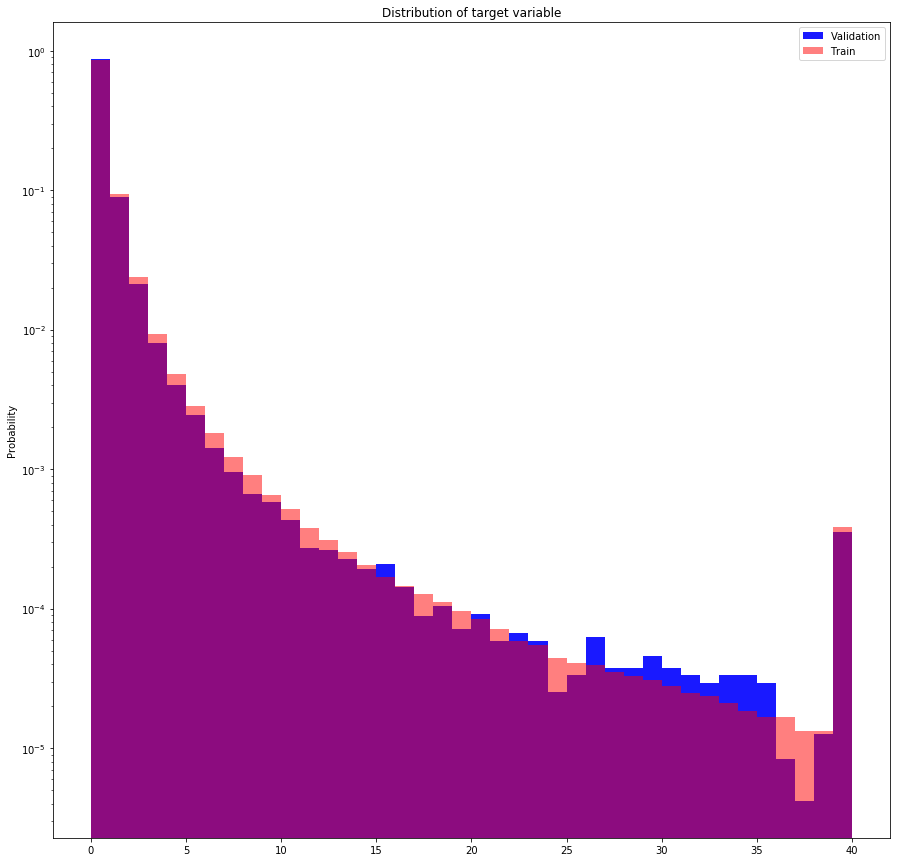

In [43]:
kwargs = dict(bins=40, density=True, stacked=True)
# Plot
plt.rcParams["figure.figsize"] = (15,15);
plt.hist(y_val   , **kwargs, color='b', label='Validation',alpha=0.9)
plt.hist(y_train, **kwargs, color='r', label='Train',alpha=0.5)
plt.yscale('log')
plt.gca().set(title='Distribution of target variable', ylabel='Probability')
plt.legend();


# XGBooost

## Training

In [43]:
import xgboost as xgb

params = {
        'eta'         : 0.08, #best 0.08
        'max_depth'   : 7,
        'objective'   : 'reg:linear',
        'eval_metric' : 'rmse',
        'seed'        : 3,
        'gamma'       : 1,
        'silent'      : True
    }
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'),
             (xgb.DMatrix(X_val, y_val), 'valid')]


xgb_model = xgb.train( params, 
                   xgb.DMatrix(X_train, y_train), 
                   3500,  
                   watchlist, 
                   maximize=False, 
                   verbose_eval=10, 
                   early_stopping_rounds=50 )

[19:52:17] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.40499	valid-rmse:1.37875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.14753	valid-rmse:1.1979
[20]	train-rmse:1.07149	valid-rmse:1.15302
[30]	train-rmse:1.0435	valid-rmse:1.14307
[40]	train-rmse:1.02674	valid-rmse:1.13878
[50]	train-rmse:1.01649	valid-rmse:1.13785
[60]	train-rmse:1.00639	valid-rmse:1.13433
[70]	train-rmse:0.996556	valid-rmse:1.13327
[80]	train-rmse:0.986761	valid-rmse:1.13119
[90]	train-rmse:0.979707	valid-rmse:1.13241
[100]	train-rmse:0.973253	valid-rmse:1.13531
[110]	train-rmse:0.968715	valid-rmse:1.13315
[120]	train-rmse:0.962651	valid-rmse:1.13881
[130]	train-rmse:0.956881	valid-rmse:1.13542
Stopping. Best iteration:
[81]	train-rmse:0.986251	valid-rmse:1.13036



## Prediction

In [88]:
def make_test_submission(md):
    return pd.DataFrame({ 
                'ID'            : test.ID,
                'item_cnt_month':  md.predict(sales_test[x_cols])
    } );


In [83]:
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))

xgb_sugmission = make_test_submission(xgb_model)
xgb_sugmission.to_csv('xgb_sugmission.csv', index=False)
xgb_sugmission.sample(30)
print('Done!')


NameError: name 'xgb_model' is not defined

Submission without leakage features, limited lag to 2
 
Leader board result 1.00240, 1738/4000


```
[0]	train-rmse:1.40963	valid-rmse:1.37883
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.06173	valid-rmse:1.16237
[100]	train-rmse:1.03781	valid-rmse:1.16024
[150]	train-rmse:1.02113	valid-rmse:1.1565
[200]	train-rmse:1.00696	valid-rmse:1.15566
Stopping. Best iteration:
[178]	train-rmse:1.01212	valid-rmse:1.15087
```

With Leagake Features
```
[17:37:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.40499	valid-rmse:1.37875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.14753	valid-rmse:1.1979
[20]	train-rmse:1.07149	valid-rmse:1.15302
[30]	train-rmse:1.0435	valid-rmse:1.14307
[40]	train-rmse:1.02674	valid-rmse:1.13878
[50]	train-rmse:1.01649	valid-rmse:1.13785
[60]	train-rmse:1.00639	valid-rmse:1.13433
[70]	train-rmse:0.996556	valid-rmse:1.13327
[80]	train-rmse:0.986761	valid-rmse:1.13119
[90]	train-rmse:0.979707	valid-rmse:1.13241
[100]	train-rmse:0.973253	valid-rmse:1.13531
[110]	train-rmse:0.968715	valid-rmse:1.13315
[120]	train-rmse:0.962651	valid-rmse:1.13881
[130]	train-rmse:0.956881	valid-rmse:1.13542
Stopping. Best iteration:
[81]	train-rmse:0.986251	valid-rmse:1.13036
```

# CatBoost

In [79]:
threshold = 70
categorical_cols= [col for col in X_train  if len(X_train[col].unique())<threshold and not('_pop' in col) ]
print(categorical_cols)

['shop_id', 'shop_city_id', 'shop_city_subj_id', 'item_metacategory_id']


In [80]:
from catboost import CatBoostRegressor

print("Train CatBoost Decision Tree")
catboost_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=7,
                             eval_metric='RMSE',
                             random_seed = 23,
                             metric_period = 25,
                             task_type = "GPU",
                             od_type = 'Iter',
                             od_wait = 40
                             )
catboost_model.fit(X_train, y_train,
             eval_set=(X_val,y_val),
             cat_features=categorical_cols,
             use_best_model=True,
             plot = True,
             verbose=True)

pickle.dump(catboost_model, open("catboost_model.pkl", "wb"))

Train CatBoost Decision Tree


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4589832	test: 1.4147521	best: 1.4147521 (0)	total: 565ms	remaining: 6m 35s
25:	learn: 1.2630713	test: 1.2680353	best: 1.2680353 (25)	total: 14.5s	remaining: 6m 14s
50:	learn: 1.1728602	test: 1.2040640	best: 1.2040640 (50)	total: 28.6s	remaining: 6m 3s
75:	learn: 1.1294805	test: 1.1754931	best: 1.1754931 (75)	total: 43.2s	remaining: 5m 54s
100:	learn: 1.1076089	test: 1.1623723	best: 1.1623723 (100)	total: 58.3s	remaining: 5m 45s
125:	learn: 1.0944419	test: 1.1559017	best: 1.1559017 (125)	total: 1m 13s	remaining: 5m 33s
150:	learn: 1.0850512	test: 1.1512002	best: 1.1512002 (150)	total: 1m 29s	remaining: 5m 25s
175:	learn: 1.0779960	test: 1.1464816	best: 1.1464816 (175)	total: 1m 45s	remaining: 5m 13s
200:	learn: 1.0726676	test: 1.1434221	best: 1.1434221 (200)	total: 2m 1s	remaining: 5m 2s
225:	learn: 1.0685120	test: 1.1408221	best: 1.1408221 (225)	total: 2m 17s	remaining: 4m 48s
250:	learn: 1.0637131	test: 1.1374956	best: 1.1374956 (250)	total: 2m 33s	remaining: 4m 34s
275:	l

In [90]:
pickle.dump(catboost_model, open("catboost_model.pkl", "wb"))

catboost_submission = make_test_submission(catboost_model)
catboost_submission.to_csv('catboost_submission.csv', index=False)
catboost_submission.sample(30)
print('Done!')


,ID,item_cnt_month
174877,174877,0.179904
124447,124447,-0.030318
123558,123558,1.917185
71219,71219,0.007978
9759,9759,-0.012392
79664,79664,0.138093
25476,25476,0.161076
132069,132069,0.171024
30829,30829,0.052019
89112,89112,0.016161


Done!


With explicit categorical features
```

cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             task_type = "GPU",
                             od_wait=100)
                             
Train CatBoost Decision Tree
0:	learn: 1.4550890	test: 1.4151798	best: 1.4151798 (0)	total: 2.27s	remaining: 26m 26s
75:	learn: 0.9496144	test: 1.2138983	best: 1.2138983 (75)	total: 2m 37s	remaining: 21m 30s
150:	learn: 0.8609199	test: 1.2060701	best: 1.2058770 (149)	total: 5m 11s	remaining: 18m 54s
225:	learn: 0.8285470	test: 1.1976246	best: 1.1968117 (210)	total: 7m 41s	remaining: 16m 7s
300:	learn: 0.8082756	test: 1.1945270	best: 1.1945270 (300)	total: 10m 6s	remaining: 13m 23s
375:	learn: 0.7902871	test: 1.1959186	best: 1.1934450 (315)	total: 12m 35s	remaining: 10m 50s
bestTest = 1.193445014
bestIteration = 315
Shrink model to first 316 iterations.

```

0:	learn: 1.4537058	test: 1.4106616	best: 1.4106616 (0)	total: 8s	remaining: 1h 33m 14s
25:	learn: 1.2118531	test: 1.2318452	best: 1.2318452 (25)	total: 3m 1s	remaining: 1h 18m 21s
50:	learn: 1.1348870	test: 1.1808820	best: 1.1808820 (50)	total: 5m 51s	remaining: 1h 14m 37s
75:	learn: 1.1078494	test: 1.1651189	best: 1.1651189 (75)	total: 8m 27s	remaining: 1h 9m 28s
100:	learn: 1.0929878	test: 1.1590653	best: 1.1590653 (100)	total: 11m 11s	remaining: 1h 6m 22s
125:	learn: 1.0822125	test: 1.1539744	best: 1.1539744 (125)	total: 13m 52s	remaining: 1h 3m 13s
150:	learn: 1.0738563	test: 1.1494389	best: 1.1494389 (150)	total: 17m 7s	remaining: 1h 2m 17s
175:	learn: 1.0667474	test: 1.1459072	best: 1.1458749 (174)	total: 20m 7s	remaining: 59m 55s
200:	learn: 1.0610977	test: 1.1423180	best: 1.1423180 (200)	total: 23m 8s	remaining: 57m 25s
225:	learn: 1.0572239	test: 1.1394140	best: 1.1394140 (225)	total: 26m 10s	remaining: 54m 53s
250:	learn: 1.0531069	test: 1.1384647	best: 1.1382038 (243)	total: 29m 8s	remaining: 52m 7s
275:	learn: 1.0496309	test: 1.1379753	best: 1.1379753 (275)	total: 31m 57s	remaining: 49m 4s
300:	learn: 1.0464283	test: 1.1360781	best: 1.1359136 (297)	total: 34m 46s	remaining: 46m 5s
325:	learn: 1.0438804	test: 1.1354912	best: 1.1353457 (322)	total: 37m 35s	remaining: 43m 8s
350:	learn: 1.0407161	test: 1.1354249	best: 1.1353457 (322)	total: 40m 11s	remaining: 39m 58s
375:	learn: 1.0386347	test: 1.1339007	best: 1.1339007 (375)	total: 42m 54s	remaining: 36m 58s
400:	learn: 1.0358212	test: 1.1329478	best: 1.1329478 (400)	total: 45m 35s	remaining: 33m 59s
425:	learn: 1.0341789	test: 1.1325491	best: 1.1325147 (424)	total: 48m 6s	remaining: 30m 56s
450:	learn: 1.0320380	test: 1.1320027	best: 1.1320027 (450)	total: 50m 47s	remaining: 28m 2s
475:	learn: 1.0296506	test: 1.1322714	best: 1.1319440 (458)	total: 53m 39s	remaining: 25m 15s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 1.131943987
bestIteration = 458
```

# LightGBM

In [112]:
import lightgbm as lgb
# create dataset for lightgbm
threshold = 70
categorical_cols= [col for col in X_train  if len(X_train[col].unique())<threshold and not('_pop' in col) ]
print(categorical_cols)

#categorical_feature=cat_features
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)



['shop_id', 'shop_city_id', 'shop_city_subj_id', 'item_metacategory_id']


In [110]:
print(lgb_train)

In [103]:

params = {
    'boosting_type'    : 'gbdt',
    'objective'        : 'regression',
    'metric'           : 'RMSE',
    'learning_rate'    : 0.02,
    'bagging_fraction' : 0.8,
    'bagging_freq'     : 5,
    'verbose'          : 20,
    'max_bin'          : 255,
    'cat_l2'           : 0.8
}
#    

print('Starting training...')
# train
lgb_model = lgb.train(
            params,
            lgb_train,
            num_boost_round       = 2000,
            valid_sets            = [lgb_train,lgb_eval],
            early_stopping_rounds = 100,
            categorical_feature   = categorical_cols
    
    )
#             categorical_feature   = cat_features

['shop_id', 'shop_city_id', 'shop_city_subj_id', 'item_metacategory_id']
Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_metacategory_id', 'shop_city_id', 'shop_city_subj_id', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_metacategory_id', 'shop_city_id', 'shop_city_subj_id', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's rmse: 1.42803	valid_1's rmse: 1.38815
Training until validation scores don't improve for 100 rounds.
[2]	training's rmse: 1.41684	valid_1's rmse: 1.37886
[3]	training's rmse: 1.40605	valid_1's rmse: 1.37022
[4]	training's rmse: 1.39543	valid_1's rmse: 1.36147
[5]	training's rmse: 1.38515	valid_1's rmse: 1.35317
[6]	training's rmse: 1.37513	valid_1's rmse: 1.34491
[7]	training's rmse: 1.36542	valid_1's rmse: 1.33706
[8]	training's rmse: 1.35619	valid_1's rmse: 1.32999
[9]	training's rmse: 1.34714	valid_1's rmse: 1.32268
[10]	training's rmse: 1.33825	valid_1's rmse: 1.31545
[11]	training's rmse: 1.32964	valid_1's rmse: 1.30871
[12]	training's rmse: 1.32123	valid_1's rmse: 1.30191
[13]	training's rmse: 1.3129	valid_1's rmse: 1.29519
[14]	training's rmse: 1.30482	valid_1's rmse: 1.28889
[15]	training's rmse: 1.29717	valid_1's rmse: 1.28281
[16]	training's rmse: 1.28973	valid_1's rmse: 1.27708
[17]	training's rmse: 1.28234	valid_1's rmse: 1.27134
[18]	training's rmse: 1.27548

[152]	training's rmse: 1.03174	valid_1's rmse: 1.10572
[153]	training's rmse: 1.0315	valid_1's rmse: 1.10568
[154]	training's rmse: 1.03116	valid_1's rmse: 1.10557
[155]	training's rmse: 1.03054	valid_1's rmse: 1.10607
[156]	training's rmse: 1.03027	valid_1's rmse: 1.10598
[157]	training's rmse: 1.03002	valid_1's rmse: 1.10574
[158]	training's rmse: 1.02968	valid_1's rmse: 1.10563
[159]	training's rmse: 1.02944	valid_1's rmse: 1.10553
[160]	training's rmse: 1.02912	valid_1's rmse: 1.1054
[161]	training's rmse: 1.02877	valid_1's rmse: 1.10548
[162]	training's rmse: 1.02838	valid_1's rmse: 1.1054
[163]	training's rmse: 1.02807	valid_1's rmse: 1.10529
[164]	training's rmse: 1.02782	valid_1's rmse: 1.10525
[165]	training's rmse: 1.02747	valid_1's rmse: 1.10518
[166]	training's rmse: 1.02713	valid_1's rmse: 1.10507
[167]	training's rmse: 1.0269	valid_1's rmse: 1.10495
[168]	training's rmse: 1.02664	valid_1's rmse: 1.10465
[169]	training's rmse: 1.02632	valid_1's rmse: 1.10467
[170]	training

[302]	training's rmse: 0.999579	valid_1's rmse: 1.10579
[303]	training's rmse: 0.999501	valid_1's rmse: 1.10581
[304]	training's rmse: 0.999039	valid_1's rmse: 1.1075
[305]	training's rmse: 0.998901	valid_1's rmse: 1.10751
[306]	training's rmse: 0.998793	valid_1's rmse: 1.10746
[307]	training's rmse: 0.998717	valid_1's rmse: 1.10747
[308]	training's rmse: 0.99853	valid_1's rmse: 1.1074
[309]	training's rmse: 0.998204	valid_1's rmse: 1.10735
[310]	training's rmse: 0.998064	valid_1's rmse: 1.10734
[311]	training's rmse: 0.997507	valid_1's rmse: 1.10728
[312]	training's rmse: 0.997369	valid_1's rmse: 1.10726
[313]	training's rmse: 0.997294	valid_1's rmse: 1.10731
[314]	training's rmse: 0.997028	valid_1's rmse: 1.107
[315]	training's rmse: 0.996859	valid_1's rmse: 1.1068
[316]	training's rmse: 0.99667	valid_1's rmse: 1.10672
[317]	training's rmse: 0.996562	valid_1's rmse: 1.10669
[318]	training's rmse: 0.996412	valid_1's rmse: 1.10659
[319]	training's rmse: 0.996309	valid_1's rmse: 1.10656

In [92]:
pickle.dump(lgb_model, open("lgb_model.pkl", "wb"))
#lgb_model = pickle.load(open("lgb_model.pkl", 'rb'))

In [85]:
submission =  make_test_submission(lgb_model)
submission.sample(30)
submission.to_csv('lgb_submission.csv', index=False)

,ID,item_cnt_month
102226,102226,2.122091
203743,203743,0.053958
156782,156782,0.030471
191301,191301,0.032699
120087,120087,0.129635
45420,45420,0.096461
190983,190983,0.147136
126688,126688,0.152570
79649,79649,0.113728
58630,58630,0.625480


### Feature analyzing

,Value,Feature
1,0,shop_city_id
2,1,shop_city_subj_id
24,24,shop_city_pop
61,320,item_id
62,452,item_metacategory_id
65,537,item_category_id
66,835,shop_id


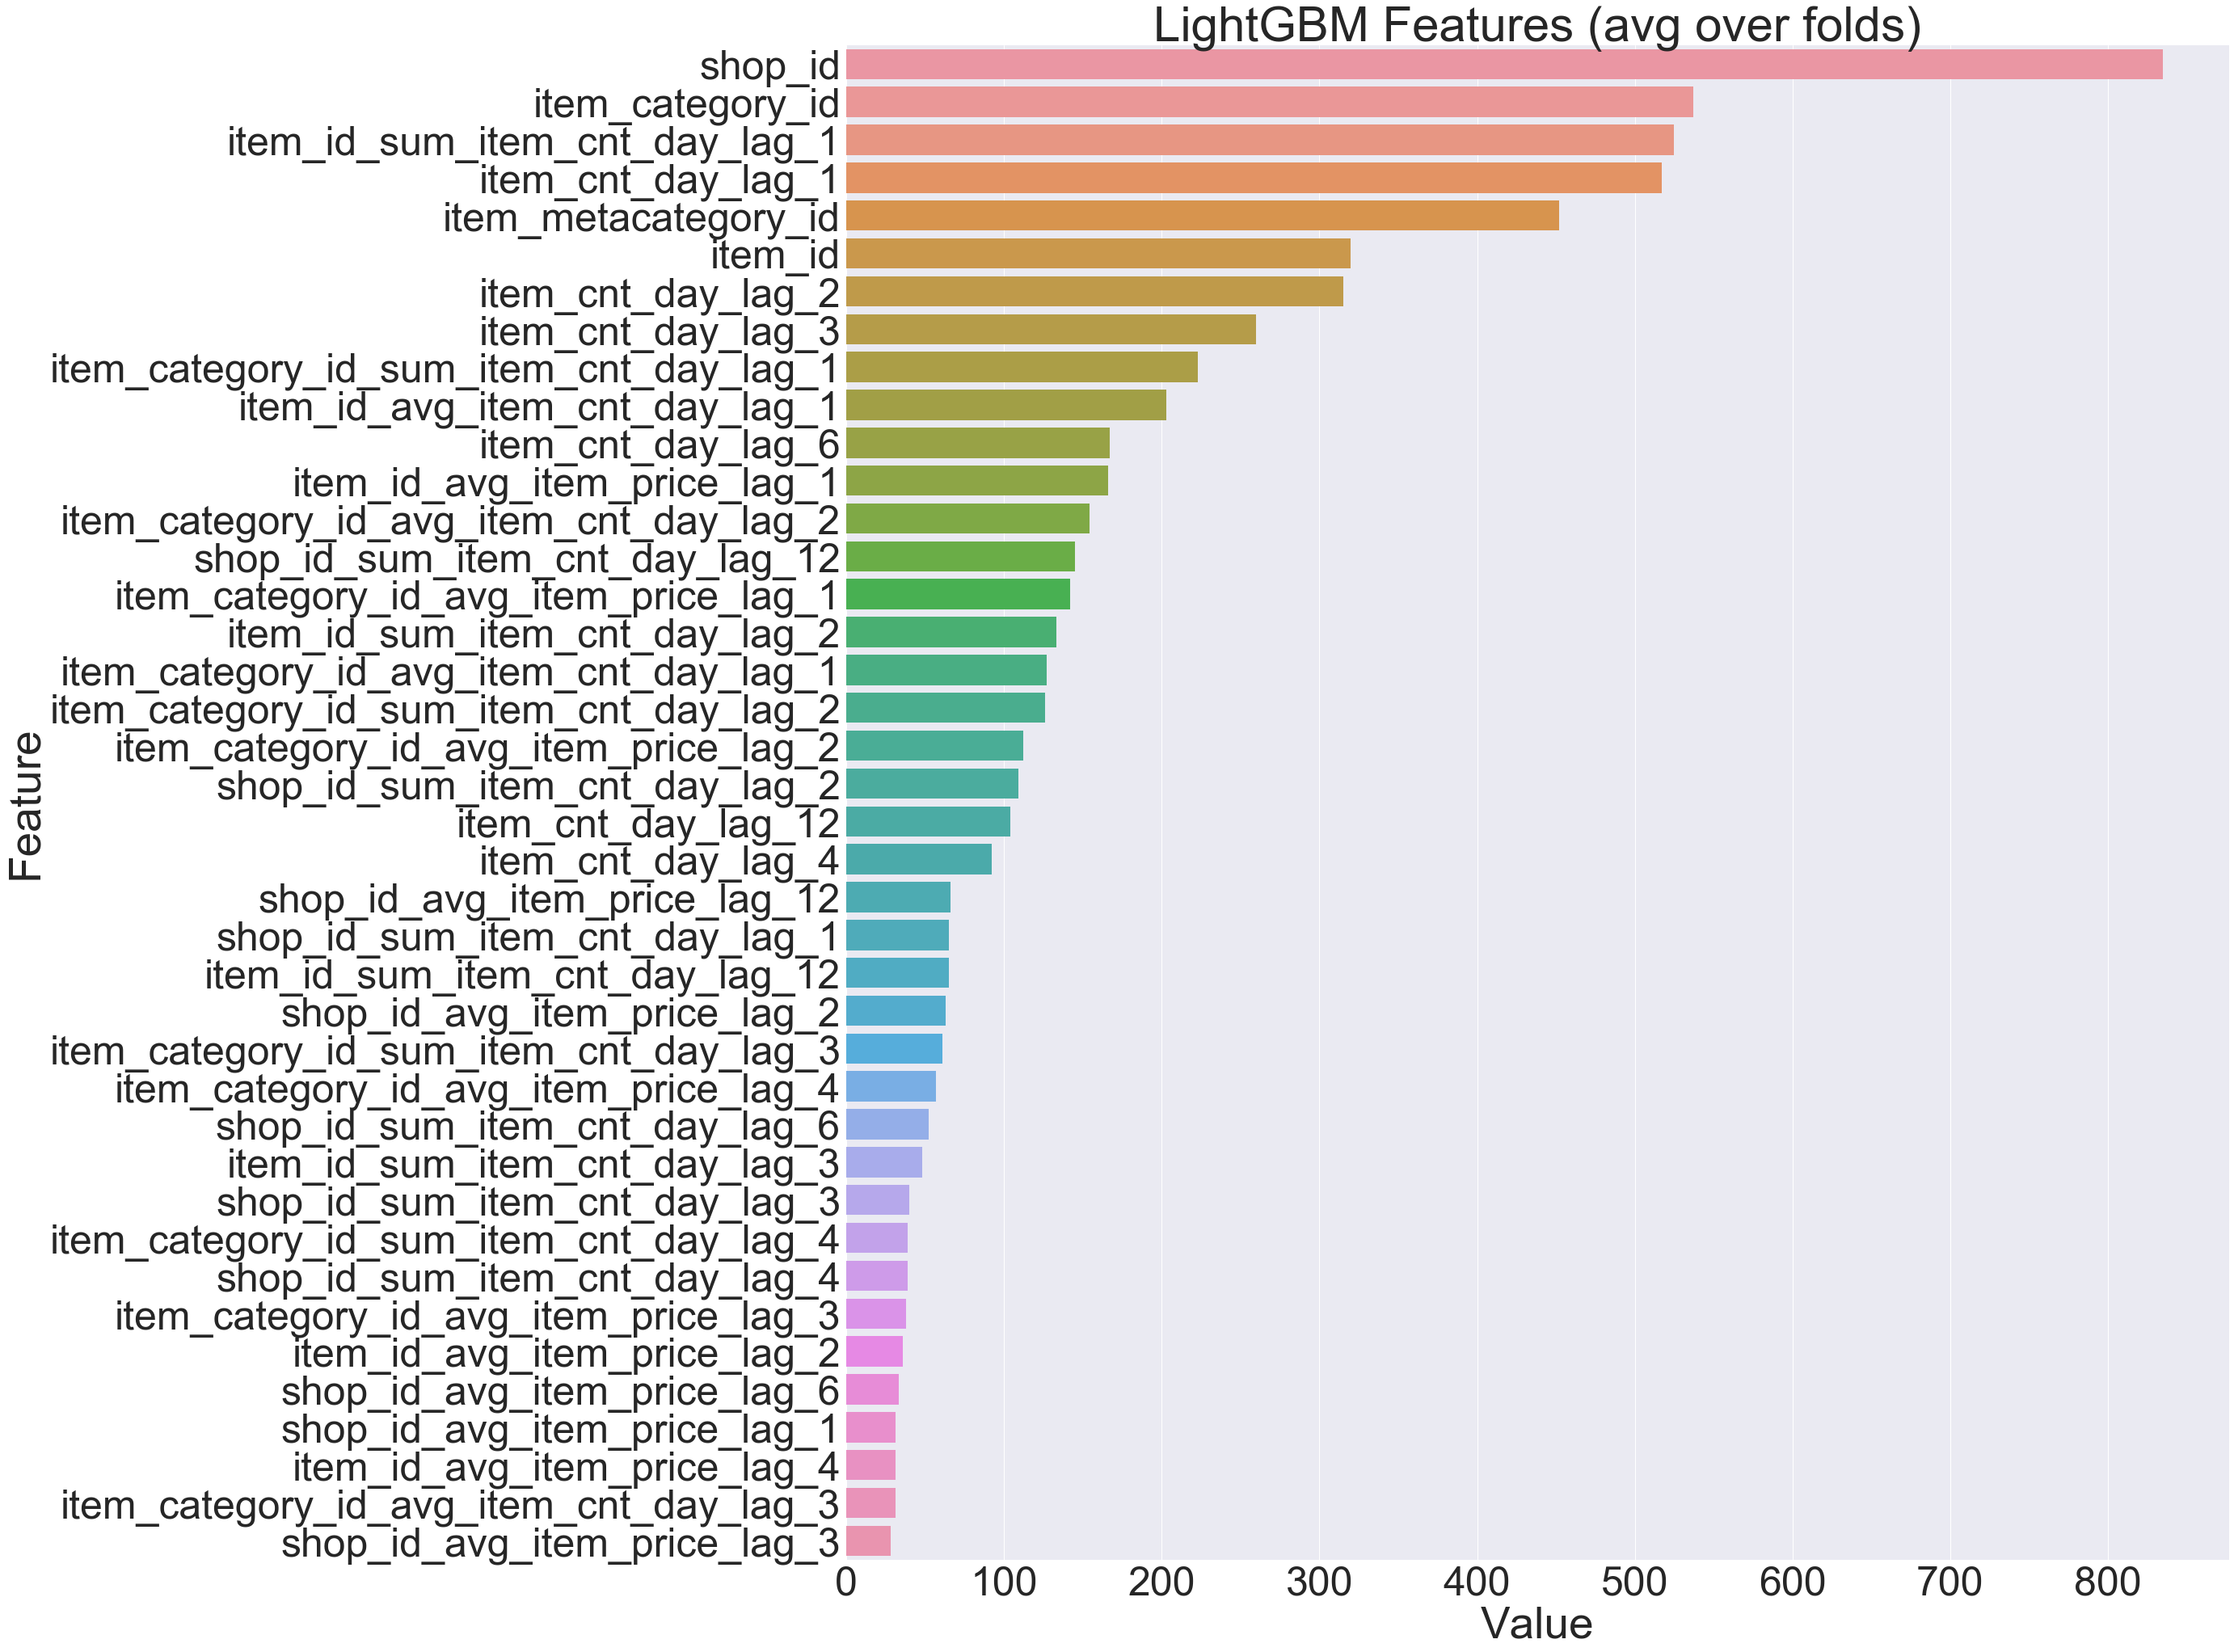

<Figure size 1080x1080 with 0 Axes>

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), 
                               columns=['Value','Feature'])
    display(feature_imp[~feature_imp["Feature"].str.contains('_lag')])
    plt.figure(figsize=(40, 30))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')
plotImp(lgb_model, X_train , num = 40)    



# Hyperparameter tuning 
## Baysian optimization 
https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm

In [113]:
## Put some optimizations on LightGBM params, as it's the fastest and most promising
from bayes_opt import BayesianOptimization



In [181]:
def parse_lgbo_results(lgbBO):
    results=[]
    for r in lgbBO.res:
        d=r['params']
        d['valid_rmse']=r['target']*(-1)
        results.append(d)
    df = pd.DataFrame(results)  
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    return df

def bayes_parameter_opt_lgb(init_round, opt_round,
                            random_seed, num_boost_round,
                            learning_rate):
    # parameters
    def evaluate_lgb(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'boosting_type'    : 'gbdt',
                  'objective'        : 'regression',
                  'metric'           : 'RMSE',
                  'num_boost_round'  :  num_boost_round,
                  'learning_rate'    :  learning_rate,
                  'early_stopping_round':100             }
        
        params["num_leaves"]       = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth']        = int(round(max_depth))
        params['lambda_l1']        = max(lambda_l1, 0)
        params['lambda_l2']        = max(lambda_l2, 0)
        params['min_split_gain']   = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        lgb_model = lgb.train(
                    params,
                    train_set             = lgb_train,
                    valid_sets            = lgb_eval,
                    categorical_feature   = categorical_cols
                    )        
        loss = lgb_model.best_score['valid_0']['rmse'];
        print('>>> loss %2.8f ' % loss)

        return loss*(-1)
    
    # range 
    params_range ={ 'num_leaves': (24, 45),
                    'feature_fraction': (0.1, 0.9),
                    'bagging_fraction': (0.8, 1),
                    'max_depth': (5, 9.99),
                    'lambda_l1': (0, 5),
                    'lambda_l2': (0, 3),
                    'min_split_gain': (0.001, 0.1),
                    'min_child_weight': (5, 50)}
    lgbBO = BayesianOptimization(evaluate_lgb, params_range, random_state=0)
    # optimize
    lgbBO.maximize( init_points = init_round,
                    n_iter      =  opt_round)
    
    return lgbBO


In [184]:
lgbBO = bayes_parameter_opt_lgb( init_round      =      10   ,
                                 opt_round       =      10   ,
                                 random_seed     =       6   ,
                                 num_boost_round =    2000   ,
                                 learning_rate   =     0.02)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38999
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38159
[3]	valid_0's rmse: 1.3732
[4]	valid_0's rmse: 1.36615
[5]	valid_0's rmse: 1.35814
[6]	valid_0's rmse: 1.35071
[7]	valid_0's rmse: 1.34425
[8]	valid_0's rmse: 1.3383
[9]	valid_0's rmse: 1.33147
[10]	valid_0's rmse: 1.32454
[11]	valid_0's rmse: 1.31795
[12]	valid_0's rmse: 1.31162
[13]	valid_0's rmse: 1.30614
[14]	valid_0's rmse: 1.30062
[15]	valid_0's rmse: 1.29499
[16]	valid_0's rmse: 1.29086
[17]	valid_0's rmse: 1.28566
[18]	valid_0's rmse: 1.28052
[19]	valid_0's rmse: 1.27619
[20]	valid_0's rmse: 1.27106
[21]	valid_0's rmse: 1.26637
[22]	valid_0's rmse: 1.26197
[23]	valid_0's rmse: 1.25767
[24]	valid_0's rmse: 1.2536
[25]	valid_0's rmse: 1.2496
[26]	valid_0's rmse: 1.24579
[27]	valid_0's rmse: 1.2419
[28]	valid_0's rmse: 1.23805
[29]	valid_0's rmse: 1.23463
[30]	valid_0's rmse: 1.23106
[31]	valid_0's rmse: 1.22799
[32]	valid_0's rmse: 1.22467
[33]	valid_0's rmse: 1.

[277]	valid_0's rmse: 1.11042
[278]	valid_0's rmse: 1.1104
[279]	valid_0's rmse: 1.11026
[280]	valid_0's rmse: 1.11023
[281]	valid_0's rmse: 1.10992
[282]	valid_0's rmse: 1.10985
[283]	valid_0's rmse: 1.10967
[284]	valid_0's rmse: 1.10969
[285]	valid_0's rmse: 1.1094
[286]	valid_0's rmse: 1.10937
[287]	valid_0's rmse: 1.109
[288]	valid_0's rmse: 1.109
[289]	valid_0's rmse: 1.10919
[290]	valid_0's rmse: 1.10919
[291]	valid_0's rmse: 1.1092
[292]	valid_0's rmse: 1.10909
[293]	valid_0's rmse: 1.10901
[294]	valid_0's rmse: 1.10901
[295]	valid_0's rmse: 1.10902
[296]	valid_0's rmse: 1.10833
[297]	valid_0's rmse: 1.10833
[298]	valid_0's rmse: 1.10826
[299]	valid_0's rmse: 1.10804
[300]	valid_0's rmse: 1.10797
[301]	valid_0's rmse: 1.1077
[302]	valid_0's rmse: 1.10717
[303]	valid_0's rmse: 1.10715
[304]	valid_0's rmse: 1.1066
[305]	valid_0's rmse: 1.10664
[306]	valid_0's rmse: 1.10661
[307]	valid_0's rmse: 1.10625
[308]	valid_0's rmse: 1.10575
[309]	valid_0's rmse: 1.10574
[310]	valid_0's rms

[552]	valid_0's rmse: 1.0952
[553]	valid_0's rmse: 1.09509
[554]	valid_0's rmse: 1.09507
[555]	valid_0's rmse: 1.09507
[556]	valid_0's rmse: 1.09507
[557]	valid_0's rmse: 1.09502
[558]	valid_0's rmse: 1.09503
[559]	valid_0's rmse: 1.09505
[560]	valid_0's rmse: 1.09504
[561]	valid_0's rmse: 1.09494
[562]	valid_0's rmse: 1.09506
[563]	valid_0's rmse: 1.09507
[564]	valid_0's rmse: 1.09505
[565]	valid_0's rmse: 1.095
[566]	valid_0's rmse: 1.09495
[567]	valid_0's rmse: 1.09497
[568]	valid_0's rmse: 1.09497
[569]	valid_0's rmse: 1.09497
[570]	valid_0's rmse: 1.09497
[571]	valid_0's rmse: 1.09497
[572]	valid_0's rmse: 1.09492
[573]	valid_0's rmse: 1.09492
[574]	valid_0's rmse: 1.09492
[575]	valid_0's rmse: 1.0949
[576]	valid_0's rmse: 1.09482
[577]	valid_0's rmse: 1.09482
[578]	valid_0's rmse: 1.09481
[579]	valid_0's rmse: 1.09482
[580]	valid_0's rmse: 1.0948
[581]	valid_0's rmse: 1.09449
[582]	valid_0's rmse: 1.09449
[583]	valid_0's rmse: 1.09448
[584]	valid_0's rmse: 1.09448
[585]	valid_0's

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39075
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38395
[3]	valid_0's rmse: 1.37605
[4]	valid_0's rmse: 1.37016
[5]	valid_0's rmse: 1.36274
[6]	valid_0's rmse: 1.35736
[7]	valid_0's rmse: 1.35153
[8]	valid_0's rmse: 1.34656
[9]	valid_0's rmse: 1.34295
[10]	valid_0's rmse: 1.3358
[11]	valid_0's rmse: 1.32915
[12]	valid_0's rmse: 1.32265
[13]	valid_0's rmse: 1.31744
[14]	valid_0's rmse: 1.31311
[15]	valid_0's rmse: 1.30717
[16]	valid_0's rmse: 1.30286
[17]	valid_0's rmse: 1.29751
[18]	valid_0's rmse: 1.29345
[19]	valid_0's rmse: 1.28925
[20]	valid_0's rmse: 1.28562
[21]	valid_0's rmse: 1.28044
[22]	valid_0's rmse: 1.27636
[23]	valid_0's rmse: 1.27136
[24]	valid_0's rmse: 1.26813
[25]	valid_0's rmse: 1.26369
[26]	valid_0's rmse: 1.26034
[27]	valid_0's rmse: 1.25611
[28]	valid_0's rmse: 1.25185
[29]	valid_0's rmse: 1.24911
[30]	valid_0's rmse: 1.24536
[31]	valid_0's rmse: 1.24218
[32]	valid_0's rmse: 1.23855
[33]	valid_0's rmse

[278]	valid_0's rmse: 1.11517
[279]	valid_0's rmse: 1.11517
[280]	valid_0's rmse: 1.11512
[281]	valid_0's rmse: 1.11468
[282]	valid_0's rmse: 1.11461
[283]	valid_0's rmse: 1.11458
[284]	valid_0's rmse: 1.11448
[285]	valid_0's rmse: 1.11446
[286]	valid_0's rmse: 1.11462
[287]	valid_0's rmse: 1.11469
[288]	valid_0's rmse: 1.11469
[289]	valid_0's rmse: 1.11465
[290]	valid_0's rmse: 1.11465
[291]	valid_0's rmse: 1.11432
[292]	valid_0's rmse: 1.11431
[293]	valid_0's rmse: 1.11429
[294]	valid_0's rmse: 1.11428
[295]	valid_0's rmse: 1.11419
[296]	valid_0's rmse: 1.11418
[297]	valid_0's rmse: 1.11409
[298]	valid_0's rmse: 1.11375
[299]	valid_0's rmse: 1.11376
[300]	valid_0's rmse: 1.11367
[301]	valid_0's rmse: 1.11366
[302]	valid_0's rmse: 1.11368
[303]	valid_0's rmse: 1.11368
[304]	valid_0's rmse: 1.11362
[305]	valid_0's rmse: 1.11354
[306]	valid_0's rmse: 1.1135
[307]	valid_0's rmse: 1.11348
[308]	valid_0's rmse: 1.11346
[309]	valid_0's rmse: 1.11346
[310]	valid_0's rmse: 1.11346
[311]	valid

[827]	valid_0's rmse: 1.09863
[828]	valid_0's rmse: 1.09862
[829]	valid_0's rmse: 1.09862
[830]	valid_0's rmse: 1.0986
[831]	valid_0's rmse: 1.0986
[832]	valid_0's rmse: 1.0986
[833]	valid_0's rmse: 1.09859
[834]	valid_0's rmse: 1.09859
[835]	valid_0's rmse: 1.09859
[836]	valid_0's rmse: 1.09859
[837]	valid_0's rmse: 1.09859
[838]	valid_0's rmse: 1.09857
[839]	valid_0's rmse: 1.09839
[840]	valid_0's rmse: 1.09839
[841]	valid_0's rmse: 1.0984
[842]	valid_0's rmse: 1.0984
[843]	valid_0's rmse: 1.09841
[844]	valid_0's rmse: 1.09836
[845]	valid_0's rmse: 1.09835
[846]	valid_0's rmse: 1.09837
[847]	valid_0's rmse: 1.09834
[848]	valid_0's rmse: 1.09834
[849]	valid_0's rmse: 1.09832
[850]	valid_0's rmse: 1.09825
[851]	valid_0's rmse: 1.09823
[852]	valid_0's rmse: 1.09824
[853]	valid_0's rmse: 1.09827
[854]	valid_0's rmse: 1.09826
[855]	valid_0's rmse: 1.09826
[856]	valid_0's rmse: 1.09826
[857]	valid_0's rmse: 1.09828
[858]	valid_0's rmse: 1.09829
[859]	valid_0's rmse: 1.09828
[860]	valid_0's

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38981
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38135
[3]	valid_0's rmse: 1.37204
[4]	valid_0's rmse: 1.36491
[5]	valid_0's rmse: 1.3566
[6]	valid_0's rmse: 1.34885
[7]	valid_0's rmse: 1.34238
[8]	valid_0's rmse: 1.33501
[9]	valid_0's rmse: 1.32821
[10]	valid_0's rmse: 1.321
[11]	valid_0's rmse: 1.31416
[12]	valid_0's rmse: 1.3075
[13]	valid_0's rmse: 1.30107
[14]	valid_0's rmse: 1.29546
[15]	valid_0's rmse: 1.28937
[16]	valid_0's rmse: 1.28498
[17]	valid_0's rmse: 1.2789
[18]	valid_0's rmse: 1.27355
[19]	valid_0's rmse: 1.26818
[20]	valid_0's rmse: 1.26322
[21]	valid_0's rmse: 1.25801
[22]	valid_0's rmse: 1.25289
[23]	valid_0's rmse: 1.24788
[24]	valid_0's rmse: 1.24312
[25]	valid_0's rmse: 1.23836
[26]	valid_0's rmse: 1.2343
[27]	valid_0's rmse: 1.23029
[28]	valid_0's rmse: 1.22644
[29]	valid_0's rmse: 1.22283
[30]	valid_0's rmse: 1.21929
[31]	valid_0's rmse: 1.21578
[32]	valid_0's rmse: 1.21237
[33]	valid_0's rmse: 1.2

[277]	valid_0's rmse: 1.09856
[278]	valid_0's rmse: 1.0986
[279]	valid_0's rmse: 1.09863
[280]	valid_0's rmse: 1.09858
[281]	valid_0's rmse: 1.09857
[282]	valid_0's rmse: 1.09859
[283]	valid_0's rmse: 1.09849
[284]	valid_0's rmse: 1.09851
[285]	valid_0's rmse: 1.09852
[286]	valid_0's rmse: 1.09857
[287]	valid_0's rmse: 1.09856
[288]	valid_0's rmse: 1.09855
[289]	valid_0's rmse: 1.09799
[290]	valid_0's rmse: 1.09793
[291]	valid_0's rmse: 1.09796
[292]	valid_0's rmse: 1.09791
[293]	valid_0's rmse: 1.09787
[294]	valid_0's rmse: 1.09775
[295]	valid_0's rmse: 1.09773
[296]	valid_0's rmse: 1.09766
[297]	valid_0's rmse: 1.09763
[298]	valid_0's rmse: 1.09767
[299]	valid_0's rmse: 1.0977
[300]	valid_0's rmse: 1.09762
[301]	valid_0's rmse: 1.09768
[302]	valid_0's rmse: 1.09767
[303]	valid_0's rmse: 1.09766
[304]	valid_0's rmse: 1.09781
[305]	valid_0's rmse: 1.0978
[306]	valid_0's rmse: 1.0978
[307]	valid_0's rmse: 1.09757
[308]	valid_0's rmse: 1.09749
[309]	valid_0's rmse: 1.09745
[310]	valid_0'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38985
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38152
[3]	valid_0's rmse: 1.37312
[4]	valid_0's rmse: 1.36614
[5]	valid_0's rmse: 1.3584
[6]	valid_0's rmse: 1.35083
[7]	valid_0's rmse: 1.34431
[8]	valid_0's rmse: 1.33836
[9]	valid_0's rmse: 1.33148
[10]	valid_0's rmse: 1.32432
[11]	valid_0's rmse: 1.31781
[12]	valid_0's rmse: 1.3115
[13]	valid_0's rmse: 1.3062
[14]	valid_0's rmse: 1.30089
[15]	valid_0's rmse: 1.29516
[16]	valid_0's rmse: 1.29093
[17]	valid_0's rmse: 1.28573
[18]	valid_0's rmse: 1.28059
[19]	valid_0's rmse: 1.27602
[20]	valid_0's rmse: 1.27109
[21]	valid_0's rmse: 1.26641
[22]	valid_0's rmse: 1.26196
[23]	valid_0's rmse: 1.25763
[24]	valid_0's rmse: 1.25344
[25]	valid_0's rmse: 1.24932
[26]	valid_0's rmse: 1.24541
[27]	valid_0's rmse: 1.24152
[28]	valid_0's rmse: 1.23763
[29]	valid_0's rmse: 1.23427
[30]	valid_0's rmse: 1.23079
[31]	valid_0's rmse: 1.22768
[32]	valid_0's rmse: 1.22439
[33]	valid_0's rmse: 

[278]	valid_0's rmse: 1.10496
[279]	valid_0's rmse: 1.10499
[280]	valid_0's rmse: 1.10497
[281]	valid_0's rmse: 1.10439
[282]	valid_0's rmse: 1.104
[283]	valid_0's rmse: 1.10368
[284]	valid_0's rmse: 1.10368
[285]	valid_0's rmse: 1.10369
[286]	valid_0's rmse: 1.10372
[287]	valid_0's rmse: 1.10361
[288]	valid_0's rmse: 1.1036
[289]	valid_0's rmse: 1.1042
[290]	valid_0's rmse: 1.10399
[291]	valid_0's rmse: 1.10326
[292]	valid_0's rmse: 1.10319
[293]	valid_0's rmse: 1.10306
[294]	valid_0's rmse: 1.10287
[295]	valid_0's rmse: 1.10221
[296]	valid_0's rmse: 1.10209
[297]	valid_0's rmse: 1.10205
[298]	valid_0's rmse: 1.10163
[299]	valid_0's rmse: 1.10162
[300]	valid_0's rmse: 1.1016
[301]	valid_0's rmse: 1.10158
[302]	valid_0's rmse: 1.10094
[303]	valid_0's rmse: 1.10089
[304]	valid_0's rmse: 1.10088
[305]	valid_0's rmse: 1.10086
[306]	valid_0's rmse: 1.10085
[307]	valid_0's rmse: 1.1008
[308]	valid_0's rmse: 1.10047
[309]	valid_0's rmse: 1.10046
[310]	valid_0's rmse: 1.10012
[311]	valid_0's 

[553]	valid_0's rmse: 1.09678
[554]	valid_0's rmse: 1.09673
[555]	valid_0's rmse: 1.09673
[556]	valid_0's rmse: 1.09673
[557]	valid_0's rmse: 1.09669
[558]	valid_0's rmse: 1.09667
[559]	valid_0's rmse: 1.09667
[560]	valid_0's rmse: 1.09665
[561]	valid_0's rmse: 1.09665
[562]	valid_0's rmse: 1.09643
[563]	valid_0's rmse: 1.09642
[564]	valid_0's rmse: 1.09639
[565]	valid_0's rmse: 1.09634
[566]	valid_0's rmse: 1.09633
[567]	valid_0's rmse: 1.09635
[568]	valid_0's rmse: 1.09635
[569]	valid_0's rmse: 1.09632
[570]	valid_0's rmse: 1.09632
[571]	valid_0's rmse: 1.09626
[572]	valid_0's rmse: 1.09585
[573]	valid_0's rmse: 1.09586
[574]	valid_0's rmse: 1.09586
[575]	valid_0's rmse: 1.09582
[576]	valid_0's rmse: 1.09579
[577]	valid_0's rmse: 1.09582
[578]	valid_0's rmse: 1.09582
[579]	valid_0's rmse: 1.09581
[580]	valid_0's rmse: 1.09582
[581]	valid_0's rmse: 1.09555
[582]	valid_0's rmse: 1.09549
[583]	valid_0's rmse: 1.09545
[584]	valid_0's rmse: 1.09543
[585]	valid_0's rmse: 1.09542
[586]	vali

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39002
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38168
[3]	valid_0's rmse: 1.37332
[4]	valid_0's rmse: 1.36635
[5]	valid_0's rmse: 1.3586
[6]	valid_0's rmse: 1.35102
[7]	valid_0's rmse: 1.3445
[8]	valid_0's rmse: 1.33853
[9]	valid_0's rmse: 1.33168
[10]	valid_0's rmse: 1.32477
[11]	valid_0's rmse: 1.31836
[12]	valid_0's rmse: 1.31202
[13]	valid_0's rmse: 1.30682
[14]	valid_0's rmse: 1.3015
[15]	valid_0's rmse: 1.29578
[16]	valid_0's rmse: 1.29154
[17]	valid_0's rmse: 1.28629
[18]	valid_0's rmse: 1.28111
[19]	valid_0's rmse: 1.27655
[20]	valid_0's rmse: 1.27167
[21]	valid_0's rmse: 1.26692
[22]	valid_0's rmse: 1.26337
[23]	valid_0's rmse: 1.25891
[24]	valid_0's rmse: 1.2546
[25]	valid_0's rmse: 1.25042
[26]	valid_0's rmse: 1.24654
[27]	valid_0's rmse: 1.24262
[28]	valid_0's rmse: 1.23875
[29]	valid_0's rmse: 1.23526
[30]	valid_0's rmse: 1.23173
[31]	valid_0's rmse: 1.22861
[32]	valid_0's rmse: 1.22529
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.10604
[278]	valid_0's rmse: 1.10607
[279]	valid_0's rmse: 1.10612
[280]	valid_0's rmse: 1.1062
[281]	valid_0's rmse: 1.10671
[282]	valid_0's rmse: 1.10663
[283]	valid_0's rmse: 1.10635
[284]	valid_0's rmse: 1.10635
[285]	valid_0's rmse: 1.10634
[286]	valid_0's rmse: 1.10704
[287]	valid_0's rmse: 1.10705
[288]	valid_0's rmse: 1.10707
[289]	valid_0's rmse: 1.10709
[290]	valid_0's rmse: 1.10687
[291]	valid_0's rmse: 1.1059
[292]	valid_0's rmse: 1.10591
[293]	valid_0's rmse: 1.10536
[294]	valid_0's rmse: 1.10533
[295]	valid_0's rmse: 1.10525
[296]	valid_0's rmse: 1.1046
[297]	valid_0's rmse: 1.10455
[298]	valid_0's rmse: 1.10431
[299]	valid_0's rmse: 1.10423
[300]	valid_0's rmse: 1.10422
[301]	valid_0's rmse: 1.10411
[302]	valid_0's rmse: 1.10523
[303]	valid_0's rmse: 1.10521
[304]	valid_0's rmse: 1.1051
[305]	valid_0's rmse: 1.10513
[306]	valid_0's rmse: 1.10512
[307]	valid_0's rmse: 1.10497
[308]	valid_0's rmse: 1.10481
[309]	valid_0's rmse: 1.10482
[310]	valid_0'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39025
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38346
[3]	valid_0's rmse: 1.37528
[4]	valid_0's rmse: 1.36954
[5]	valid_0's rmse: 1.3621
[6]	valid_0's rmse: 1.35658
[7]	valid_0's rmse: 1.35065
[8]	valid_0's rmse: 1.34567
[9]	valid_0's rmse: 1.34123
[10]	valid_0's rmse: 1.33413
[11]	valid_0's rmse: 1.32727
[12]	valid_0's rmse: 1.32078
[13]	valid_0's rmse: 1.31553
[14]	valid_0's rmse: 1.31111
[15]	valid_0's rmse: 1.30525
[16]	valid_0's rmse: 1.30097
[17]	valid_0's rmse: 1.29564
[18]	valid_0's rmse: 1.29019
[19]	valid_0's rmse: 1.28583
[20]	valid_0's rmse: 1.28207
[21]	valid_0's rmse: 1.27703
[22]	valid_0's rmse: 1.2732
[23]	valid_0's rmse: 1.26849
[24]	valid_0's rmse: 1.26536
[25]	valid_0's rmse: 1.26105
[26]	valid_0's rmse: 1.25699
[27]	valid_0's rmse: 1.25281
[28]	valid_0's rmse: 1.2487
[29]	valid_0's rmse: 1.24604
[30]	valid_0's rmse: 1.24236
[31]	valid_0's rmse: 1.23922
[32]	valid_0's rmse: 1.23566
[33]	valid_0's rmse: 

[278]	valid_0's rmse: 1.11294
[279]	valid_0's rmse: 1.11246
[280]	valid_0's rmse: 1.11243
[281]	valid_0's rmse: 1.11245
[282]	valid_0's rmse: 1.11239
[283]	valid_0's rmse: 1.1121
[284]	valid_0's rmse: 1.11207
[285]	valid_0's rmse: 1.11208
[286]	valid_0's rmse: 1.11218
[287]	valid_0's rmse: 1.11217
[288]	valid_0's rmse: 1.11224
[289]	valid_0's rmse: 1.11223
[290]	valid_0's rmse: 1.11223
[291]	valid_0's rmse: 1.11178
[292]	valid_0's rmse: 1.11182
[293]	valid_0's rmse: 1.11178
[294]	valid_0's rmse: 1.11169
[295]	valid_0's rmse: 1.11165
[296]	valid_0's rmse: 1.1108
[297]	valid_0's rmse: 1.11073
[298]	valid_0's rmse: 1.11065
[299]	valid_0's rmse: 1.11066
[300]	valid_0's rmse: 1.11015
[301]	valid_0's rmse: 1.11004
[302]	valid_0's rmse: 1.11009
[303]	valid_0's rmse: 1.1101
[304]	valid_0's rmse: 1.11004
[305]	valid_0's rmse: 1.11002
[306]	valid_0's rmse: 1.11003
[307]	valid_0's rmse: 1.11002
[308]	valid_0's rmse: 1.11003
[309]	valid_0's rmse: 1.11009
[310]	valid_0's rmse: 1.1101
[311]	valid_0'

[554]	valid_0's rmse: 1.09895
[555]	valid_0's rmse: 1.09891
[556]	valid_0's rmse: 1.09891
[557]	valid_0's rmse: 1.09889
[558]	valid_0's rmse: 1.09898
[559]	valid_0's rmse: 1.09899
[560]	valid_0's rmse: 1.0989
[561]	valid_0's rmse: 1.09895
[562]	valid_0's rmse: 1.09896
[563]	valid_0's rmse: 1.09891
[564]	valid_0's rmse: 1.09897
[565]	valid_0's rmse: 1.0989
[566]	valid_0's rmse: 1.09901
[567]	valid_0's rmse: 1.099
[568]	valid_0's rmse: 1.09901
[569]	valid_0's rmse: 1.099
[570]	valid_0's rmse: 1.09908
[571]	valid_0's rmse: 1.09908
[572]	valid_0's rmse: 1.09909
[573]	valid_0's rmse: 1.09909
[574]	valid_0's rmse: 1.0991
[575]	valid_0's rmse: 1.09909
[576]	valid_0's rmse: 1.09909
[577]	valid_0's rmse: 1.09909
[578]	valid_0's rmse: 1.09903
[579]	valid_0's rmse: 1.09904
[580]	valid_0's rmse: 1.09904
[581]	valid_0's rmse: 1.09903
[582]	valid_0's rmse: 1.09904
[583]	valid_0's rmse: 1.09904
[584]	valid_0's rmse: 1.09914
[585]	valid_0's rmse: 1.09914
[586]	valid_0's rmse: 1.10062
[587]	valid_0's r

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39068
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38387
[3]	valid_0's rmse: 1.3759
[4]	valid_0's rmse: 1.36998
[5]	valid_0's rmse: 1.36252
[6]	valid_0's rmse: 1.35695
[7]	valid_0's rmse: 1.35033
[8]	valid_0's rmse: 1.3453
[9]	valid_0's rmse: 1.34145
[10]	valid_0's rmse: 1.33378
[11]	valid_0's rmse: 1.32717
[12]	valid_0's rmse: 1.31967
[13]	valid_0's rmse: 1.31437
[14]	valid_0's rmse: 1.30993
[15]	valid_0's rmse: 1.30311
[16]	valid_0's rmse: 1.29802
[17]	valid_0's rmse: 1.29264
[18]	valid_0's rmse: 1.28848
[19]	valid_0's rmse: 1.28421
[20]	valid_0's rmse: 1.27974
[21]	valid_0's rmse: 1.2745
[22]	valid_0's rmse: 1.27028
[23]	valid_0's rmse: 1.26464
[24]	valid_0's rmse: 1.2615
[25]	valid_0's rmse: 1.2569
[26]	valid_0's rmse: 1.25379
[27]	valid_0's rmse: 1.24957
[28]	valid_0's rmse: 1.24528
[29]	valid_0's rmse: 1.24251
[30]	valid_0's rmse: 1.23825
[31]	valid_0's rmse: 1.23493
[32]	valid_0's rmse: 1.23153
[33]	valid_0's rmse: 1.

[551]	valid_0's rmse: 1.10208
[552]	valid_0's rmse: 1.10209
[553]	valid_0's rmse: 1.10207
[554]	valid_0's rmse: 1.10206
[555]	valid_0's rmse: 1.10206
[556]	valid_0's rmse: 1.10206
[557]	valid_0's rmse: 1.10202
[558]	valid_0's rmse: 1.10214
[559]	valid_0's rmse: 1.10212
[560]	valid_0's rmse: 1.10213
[561]	valid_0's rmse: 1.10212
[562]	valid_0's rmse: 1.10212
[563]	valid_0's rmse: 1.10209
[564]	valid_0's rmse: 1.10209
[565]	valid_0's rmse: 1.1021
[566]	valid_0's rmse: 1.10211
[567]	valid_0's rmse: 1.1021
[568]	valid_0's rmse: 1.10208
[569]	valid_0's rmse: 1.10206
[570]	valid_0's rmse: 1.1022
[571]	valid_0's rmse: 1.10223
[572]	valid_0's rmse: 1.10223
[573]	valid_0's rmse: 1.10223
[574]	valid_0's rmse: 1.10223
[575]	valid_0's rmse: 1.10222
[576]	valid_0's rmse: 1.10222
[577]	valid_0's rmse: 1.10225
[578]	valid_0's rmse: 1.10224
[579]	valid_0's rmse: 1.10222
[580]	valid_0's rmse: 1.10221
[581]	valid_0's rmse: 1.10221
[582]	valid_0's rmse: 1.10239
[583]	valid_0's rmse: 1.10215
[584]	valid_0

[827]	valid_0's rmse: 1.10159
[828]	valid_0's rmse: 1.10157
[829]	valid_0's rmse: 1.10161
[830]	valid_0's rmse: 1.10159
[831]	valid_0's rmse: 1.10159
[832]	valid_0's rmse: 1.1016
[833]	valid_0's rmse: 1.10159
[834]	valid_0's rmse: 1.10157
[835]	valid_0's rmse: 1.10157
[836]	valid_0's rmse: 1.10155
[837]	valid_0's rmse: 1.10155
[838]	valid_0's rmse: 1.10154
[839]	valid_0's rmse: 1.10161
[840]	valid_0's rmse: 1.10162
[841]	valid_0's rmse: 1.10162
[842]	valid_0's rmse: 1.1016
[843]	valid_0's rmse: 1.10161
[844]	valid_0's rmse: 1.10159
[845]	valid_0's rmse: 1.10156
[846]	valid_0's rmse: 1.10157
[847]	valid_0's rmse: 1.1016
[848]	valid_0's rmse: 1.1016
[849]	valid_0's rmse: 1.10158
[850]	valid_0's rmse: 1.10151
[851]	valid_0's rmse: 1.10149
[852]	valid_0's rmse: 1.10148
[853]	valid_0's rmse: 1.10145
[854]	valid_0's rmse: 1.10154
[855]	valid_0's rmse: 1.10151
[856]	valid_0's rmse: 1.10152
[857]	valid_0's rmse: 1.10153
[858]	valid_0's rmse: 1.10153
[859]	valid_0's rmse: 1.10153
[860]	valid_0'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39122
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38486
[3]	valid_0's rmse: 1.37679
[4]	valid_0's rmse: 1.37062
[5]	valid_0's rmse: 1.36464
[6]	valid_0's rmse: 1.35927
[7]	valid_0's rmse: 1.35424
[8]	valid_0's rmse: 1.34911
[9]	valid_0's rmse: 1.34583
[10]	valid_0's rmse: 1.33885
[11]	valid_0's rmse: 1.33435
[12]	valid_0's rmse: 1.32764
[13]	valid_0's rmse: 1.32265
[14]	valid_0's rmse: 1.31846
[15]	valid_0's rmse: 1.31239
[16]	valid_0's rmse: 1.30928
[17]	valid_0's rmse: 1.3037
[18]	valid_0's rmse: 1.29955
[19]	valid_0's rmse: 1.29543
[20]	valid_0's rmse: 1.29203
[21]	valid_0's rmse: 1.2868
[22]	valid_0's rmse: 1.2829
[23]	valid_0's rmse: 1.27808
[24]	valid_0's rmse: 1.27465
[25]	valid_0's rmse: 1.27016
[26]	valid_0's rmse: 1.2668
[27]	valid_0's rmse: 1.26244
[28]	valid_0's rmse: 1.2582
[29]	valid_0's rmse: 1.25588
[30]	valid_0's rmse: 1.25314
[31]	valid_0's rmse: 1.25025
[32]	valid_0's rmse: 1.2466
[33]	valid_0's rmse: 1.2

[278]	valid_0's rmse: 1.1254
[279]	valid_0's rmse: 1.12451
[280]	valid_0's rmse: 1.12446
[281]	valid_0's rmse: 1.12359
[282]	valid_0's rmse: 1.12358
[283]	valid_0's rmse: 1.12353
[284]	valid_0's rmse: 1.12344
[285]	valid_0's rmse: 1.12343
[286]	valid_0's rmse: 1.1234
[287]	valid_0's rmse: 1.12342
[288]	valid_0's rmse: 1.12339
[289]	valid_0's rmse: 1.12333
[290]	valid_0's rmse: 1.12333
[291]	valid_0's rmse: 1.12297
[292]	valid_0's rmse: 1.12297
[293]	valid_0's rmse: 1.1229
[294]	valid_0's rmse: 1.12279
[295]	valid_0's rmse: 1.12271
[296]	valid_0's rmse: 1.12268
[297]	valid_0's rmse: 1.12264
[298]	valid_0's rmse: 1.12209
[299]	valid_0's rmse: 1.12204
[300]	valid_0's rmse: 1.12192
[301]	valid_0's rmse: 1.12188
[302]	valid_0's rmse: 1.12158
[303]	valid_0's rmse: 1.12158
[304]	valid_0's rmse: 1.12156
[305]	valid_0's rmse: 1.12153
[306]	valid_0's rmse: 1.12148
[307]	valid_0's rmse: 1.12147
[308]	valid_0's rmse: 1.12143
[309]	valid_0's rmse: 1.1215
[310]	valid_0's rmse: 1.1215
[311]	valid_0's

[553]	valid_0's rmse: 1.10563
[554]	valid_0's rmse: 1.10553
[555]	valid_0's rmse: 1.10551
[556]	valid_0's rmse: 1.10551
[557]	valid_0's rmse: 1.10549
[558]	valid_0's rmse: 1.10548
[559]	valid_0's rmse: 1.10549
[560]	valid_0's rmse: 1.10544
[561]	valid_0's rmse: 1.10546
[562]	valid_0's rmse: 1.10535
[563]	valid_0's rmse: 1.10534
[564]	valid_0's rmse: 1.10533
[565]	valid_0's rmse: 1.10533
[566]	valid_0's rmse: 1.1053
[567]	valid_0's rmse: 1.1053
[568]	valid_0's rmse: 1.10527
[569]	valid_0's rmse: 1.10529
[570]	valid_0's rmse: 1.10526
[571]	valid_0's rmse: 1.10521
[572]	valid_0's rmse: 1.10521
[573]	valid_0's rmse: 1.10514
[574]	valid_0's rmse: 1.10512
[575]	valid_0's rmse: 1.10511
[576]	valid_0's rmse: 1.1051
[577]	valid_0's rmse: 1.1051
[578]	valid_0's rmse: 1.10514
[579]	valid_0's rmse: 1.10502
[580]	valid_0's rmse: 1.105
[581]	valid_0's rmse: 1.10499
[582]	valid_0's rmse: 1.10489
[583]	valid_0's rmse: 1.10489
[584]	valid_0's rmse: 1.10488
[585]	valid_0's rmse: 1.10488
[586]	valid_0's 

[828]	valid_0's rmse: 1.10279
Early stopping, best iteration is:
[728]	valid_0's rmse: 1.10237
defaultdict(<class 'dict'>, {'valid_0': {'rmse': 1.1023673386348527}})
>>> loss 1.10236734 
|  8        | -1.102    |  0.9306   |  0.3026   |  2.332    |  0.7333   |  5.793    |  9.967    |  0.06598  |  26.9     |


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39032
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38331
[3]	valid_0's rmse: 1.37522
[4]	valid_0's rmse: 1.36848
[5]	valid_0's rmse: 1.36096
[6]	valid_0's rmse: 1.35529
[7]	valid_0's rmse: 1.34921
[8]	valid_0's rmse: 1.34404
[9]	valid_0's rmse: 1.34003
[10]	valid_0's rmse: 1.3326
[11]	valid_0's rmse: 1.32585
[12]	valid_0's rmse: 1.31913
[13]	valid_0's rmse: 1.31371
[14]	valid_0's rmse: 1.30894
[15]	valid_0's rmse: 1.30217
[16]	valid_0's rmse: 1.29724
[17]	valid_0's rmse: 1.29183
[18]	valid_0's rmse: 1.28763
[19]	valid_0's rmse: 1.28318
[20]	valid_0's rmse: 1.27887
[21]	valid_0's rmse: 1.27363
[22]	valid_0's rmse: 1.26872
[23]	valid_0's rmse: 1.2639
[24]	valid_0's rmse: 1.26054
[25]	valid_0's rmse: 1.25599
[26]	valid_0's rmse: 1.25288
[27]	valid_0's rmse: 1.24874
[28]	valid_0's rmse: 1.24442
[29]	valid_0's rmse: 1.24161
[30]	valid_0's rmse: 1.23772
[31]	valid_0's rmse: 1.23444
[32]	valid_0's rmse: 1.23106
[33]	valid_0's rmse:

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39029
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38223
[3]	valid_0's rmse: 1.37415
[4]	valid_0's rmse: 1.36773
[5]	valid_0's rmse: 1.36021
[6]	valid_0's rmse: 1.35284
[7]	valid_0's rmse: 1.34674
[8]	valid_0's rmse: 1.3412
[9]	valid_0's rmse: 1.33448
[10]	valid_0's rmse: 1.32768
[11]	valid_0's rmse: 1.32126
[12]	valid_0's rmse: 1.3153
[13]	valid_0's rmse: 1.3103
[14]	valid_0's rmse: 1.30546
[15]	valid_0's rmse: 1.29986
[16]	valid_0's rmse: 1.29583
[17]	valid_0's rmse: 1.29077
[18]	valid_0's rmse: 1.28573
[19]	valid_0's rmse: 1.28143
[20]	valid_0's rmse: 1.27654
[21]	valid_0's rmse: 1.27205
[22]	valid_0's rmse: 1.2687
[23]	valid_0's rmse: 1.26425
[24]	valid_0's rmse: 1.2601
[25]	valid_0's rmse: 1.25612
[26]	valid_0's rmse: 1.25223
[27]	valid_0's rmse: 1.24843
[28]	valid_0's rmse: 1.24471
[29]	valid_0's rmse: 1.24136
[30]	valid_0's rmse: 1.23797
[31]	valid_0's rmse: 1.23505
[32]	valid_0's rmse: 1.23195
[33]	valid_0's rmse: 1.

[277]	valid_0's rmse: 1.11956
[278]	valid_0's rmse: 1.11953
[279]	valid_0's rmse: 1.11897
[280]	valid_0's rmse: 1.11894
[281]	valid_0's rmse: 1.11842
[282]	valid_0's rmse: 1.11827
[283]	valid_0's rmse: 1.11781
[284]	valid_0's rmse: 1.1178
[285]	valid_0's rmse: 1.11779
[286]	valid_0's rmse: 1.1178
[287]	valid_0's rmse: 1.11771
[288]	valid_0's rmse: 1.11768
[289]	valid_0's rmse: 1.11769
[290]	valid_0's rmse: 1.11745
[291]	valid_0's rmse: 1.11685
[292]	valid_0's rmse: 1.11684
[293]	valid_0's rmse: 1.1165
[294]	valid_0's rmse: 1.11647
[295]	valid_0's rmse: 1.11641
[296]	valid_0's rmse: 1.11645
[297]	valid_0's rmse: 1.11642
[298]	valid_0's rmse: 1.11574
[299]	valid_0's rmse: 1.1157
[300]	valid_0's rmse: 1.11561
[301]	valid_0's rmse: 1.11562
[302]	valid_0's rmse: 1.1155
[303]	valid_0's rmse: 1.11549
[304]	valid_0's rmse: 1.11547
[305]	valid_0's rmse: 1.11532
[306]	valid_0's rmse: 1.11526
[307]	valid_0's rmse: 1.11519
[308]	valid_0's rmse: 1.11453
[309]	valid_0's rmse: 1.1145
[310]	valid_0's 

[552]	valid_0's rmse: 1.10164
[553]	valid_0's rmse: 1.10157
[554]	valid_0's rmse: 1.10155
[555]	valid_0's rmse: 1.10155
[556]	valid_0's rmse: 1.10158
[557]	valid_0's rmse: 1.10158
[558]	valid_0's rmse: 1.10155
[559]	valid_0's rmse: 1.10155
[560]	valid_0's rmse: 1.10146
[561]	valid_0's rmse: 1.10146
[562]	valid_0's rmse: 1.10126
[563]	valid_0's rmse: 1.10122
[564]	valid_0's rmse: 1.1012
[565]	valid_0's rmse: 1.10118
[566]	valid_0's rmse: 1.10118
[567]	valid_0's rmse: 1.10119
[568]	valid_0's rmse: 1.10117
[569]	valid_0's rmse: 1.10116
[570]	valid_0's rmse: 1.10116
[571]	valid_0's rmse: 1.10113
[572]	valid_0's rmse: 1.10111
[573]	valid_0's rmse: 1.10102
[574]	valid_0's rmse: 1.10099
[575]	valid_0's rmse: 1.10098
[576]	valid_0's rmse: 1.10097
[577]	valid_0's rmse: 1.10095
[578]	valid_0's rmse: 1.10095
[579]	valid_0's rmse: 1.10131
[580]	valid_0's rmse: 1.10114
[581]	valid_0's rmse: 1.10114
[582]	valid_0's rmse: 1.10109
[583]	valid_0's rmse: 1.10101
[584]	valid_0's rmse: 1.10102
[585]	valid

[826]	valid_0's rmse: 1.09664
[827]	valid_0's rmse: 1.09668
[828]	valid_0's rmse: 1.09667
[829]	valid_0's rmse: 1.09668
[830]	valid_0's rmse: 1.0967
[831]	valid_0's rmse: 1.09674
[832]	valid_0's rmse: 1.09666
[833]	valid_0's rmse: 1.09657
[834]	valid_0's rmse: 1.09658
[835]	valid_0's rmse: 1.09667
[836]	valid_0's rmse: 1.09666
[837]	valid_0's rmse: 1.09667
[838]	valid_0's rmse: 1.09667
[839]	valid_0's rmse: 1.09674
[840]	valid_0's rmse: 1.09672
[841]	valid_0's rmse: 1.09672
[842]	valid_0's rmse: 1.09672
[843]	valid_0's rmse: 1.09669
[844]	valid_0's rmse: 1.09671
[845]	valid_0's rmse: 1.09668
[846]	valid_0's rmse: 1.09667
[847]	valid_0's rmse: 1.09672
[848]	valid_0's rmse: 1.09676
[849]	valid_0's rmse: 1.09677
[850]	valid_0's rmse: 1.09667
[851]	valid_0's rmse: 1.09665
[852]	valid_0's rmse: 1.09664
[853]	valid_0's rmse: 1.09663
[854]	valid_0's rmse: 1.09658
[855]	valid_0's rmse: 1.09651
[856]	valid_0's rmse: 1.09649
[857]	valid_0's rmse: 1.09652
[858]	valid_0's rmse: 1.09651
[859]	valid

[1097]	valid_0's rmse: 1.09438
[1098]	valid_0's rmse: 1.09437
[1099]	valid_0's rmse: 1.09437
[1100]	valid_0's rmse: 1.09437
[1101]	valid_0's rmse: 1.09439
[1102]	valid_0's rmse: 1.09439
[1103]	valid_0's rmse: 1.09437
[1104]	valid_0's rmse: 1.09438
[1105]	valid_0's rmse: 1.09438
[1106]	valid_0's rmse: 1.09435
[1107]	valid_0's rmse: 1.09435
[1108]	valid_0's rmse: 1.09433
[1109]	valid_0's rmse: 1.09432
[1110]	valid_0's rmse: 1.0943
[1111]	valid_0's rmse: 1.09431
[1112]	valid_0's rmse: 1.0943
[1113]	valid_0's rmse: 1.09429
[1114]	valid_0's rmse: 1.09425
[1115]	valid_0's rmse: 1.09422
[1116]	valid_0's rmse: 1.09421
[1117]	valid_0's rmse: 1.0942
[1118]	valid_0's rmse: 1.09419
[1119]	valid_0's rmse: 1.09419
[1120]	valid_0's rmse: 1.09419
[1121]	valid_0's rmse: 1.0942
[1122]	valid_0's rmse: 1.0942
[1123]	valid_0's rmse: 1.09419
[1124]	valid_0's rmse: 1.09419
[1125]	valid_0's rmse: 1.0942
[1126]	valid_0's rmse: 1.09417
[1127]	valid_0's rmse: 1.09418
[1128]	valid_0's rmse: 1.0942
[1129]	valid_0'

[1363]	valid_0's rmse: 1.09322
[1364]	valid_0's rmse: 1.09322
[1365]	valid_0's rmse: 1.09324
[1366]	valid_0's rmse: 1.09323
[1367]	valid_0's rmse: 1.09324
[1368]	valid_0's rmse: 1.09325
[1369]	valid_0's rmse: 1.09324
[1370]	valid_0's rmse: 1.09327
[1371]	valid_0's rmse: 1.09327
[1372]	valid_0's rmse: 1.09328
[1373]	valid_0's rmse: 1.09327
[1374]	valid_0's rmse: 1.09328
[1375]	valid_0's rmse: 1.0933
[1376]	valid_0's rmse: 1.0933
[1377]	valid_0's rmse: 1.0933
[1378]	valid_0's rmse: 1.09329
[1379]	valid_0's rmse: 1.09329
[1380]	valid_0's rmse: 1.09328
[1381]	valid_0's rmse: 1.09325
[1382]	valid_0's rmse: 1.09322
[1383]	valid_0's rmse: 1.09323
[1384]	valid_0's rmse: 1.09322
[1385]	valid_0's rmse: 1.09322
[1386]	valid_0's rmse: 1.09321
[1387]	valid_0's rmse: 1.09322
[1388]	valid_0's rmse: 1.09322
[1389]	valid_0's rmse: 1.09322
[1390]	valid_0's rmse: 1.09324
[1391]	valid_0's rmse: 1.09325
[1392]	valid_0's rmse: 1.09325
[1393]	valid_0's rmse: 1.09319
[1394]	valid_0's rmse: 1.09315
[1395]	vali

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.3823
[3]	valid_0's rmse: 1.37418
[4]	valid_0's rmse: 1.36762
[5]	valid_0's rmse: 1.35993
[6]	valid_0's rmse: 1.3526
[7]	valid_0's rmse: 1.34663
[8]	valid_0's rmse: 1.33984
[9]	valid_0's rmse: 1.33319
[10]	valid_0's rmse: 1.32665
[11]	valid_0's rmse: 1.32036
[12]	valid_0's rmse: 1.31447
[13]	valid_0's rmse: 1.3087
[14]	valid_0's rmse: 1.30377
[15]	valid_0's rmse: 1.29834
[16]	valid_0's rmse: 1.29424
[17]	valid_0's rmse: 1.28901
[18]	valid_0's rmse: 1.28415
[19]	valid_0's rmse: 1.27932
[20]	valid_0's rmse: 1.27474
[21]	valid_0's rmse: 1.27024
[22]	valid_0's rmse: 1.26594
[23]	valid_0's rmse: 1.26195
[24]	valid_0's rmse: 1.25795
[25]	valid_0's rmse: 1.25401
[26]	valid_0's rmse: 1.25028
[27]	valid_0's rmse: 1.24655
[28]	valid_0's rmse: 1.24309
[29]	valid_0's rmse: 1.23968
[30]	valid_0's rmse: 1.23642
[31]	valid_0's rmse: 1.2331
[32]	valid_0's rmse: 1.23005
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.1228
[278]	valid_0's rmse: 1.12282
[279]	valid_0's rmse: 1.12282
[280]	valid_0's rmse: 1.12276
[281]	valid_0's rmse: 1.12259
[282]	valid_0's rmse: 1.12228
[283]	valid_0's rmse: 1.12216
[284]	valid_0's rmse: 1.12217
[285]	valid_0's rmse: 1.12166
[286]	valid_0's rmse: 1.12161
[287]	valid_0's rmse: 1.12157
[288]	valid_0's rmse: 1.12154
[289]	valid_0's rmse: 1.12107
[290]	valid_0's rmse: 1.12033
[291]	valid_0's rmse: 1.12015
[292]	valid_0's rmse: 1.12015
[293]	valid_0's rmse: 1.12016
[294]	valid_0's rmse: 1.12003
[295]	valid_0's rmse: 1.11991
[296]	valid_0's rmse: 1.11911
[297]	valid_0's rmse: 1.11914
[298]	valid_0's rmse: 1.11905
[299]	valid_0's rmse: 1.11905
[300]	valid_0's rmse: 1.11828
[301]	valid_0's rmse: 1.11774
[302]	valid_0's rmse: 1.1177
[303]	valid_0's rmse: 1.11767
[304]	valid_0's rmse: 1.1176
[305]	valid_0's rmse: 1.11755
[306]	valid_0's rmse: 1.11741
[307]	valid_0's rmse: 1.11701
[308]	valid_0's rmse: 1.11631
[309]	valid_0's rmse: 1.11632
[310]	valid_0

[552]	valid_0's rmse: 1.09884
[553]	valid_0's rmse: 1.09883
[554]	valid_0's rmse: 1.09862
[555]	valid_0's rmse: 1.09862
[556]	valid_0's rmse: 1.09861
[557]	valid_0's rmse: 1.09858
[558]	valid_0's rmse: 1.09874
[559]	valid_0's rmse: 1.09872
[560]	valid_0's rmse: 1.09872
[561]	valid_0's rmse: 1.09864
[562]	valid_0's rmse: 1.09833
[563]	valid_0's rmse: 1.09832
[564]	valid_0's rmse: 1.09834
[565]	valid_0's rmse: 1.09834
[566]	valid_0's rmse: 1.09835
[567]	valid_0's rmse: 1.09831
[568]	valid_0's rmse: 1.09829
[569]	valid_0's rmse: 1.0983
[570]	valid_0's rmse: 1.0983
[571]	valid_0's rmse: 1.0983
[572]	valid_0's rmse: 1.09828
[573]	valid_0's rmse: 1.09828
[574]	valid_0's rmse: 1.09825
[575]	valid_0's rmse: 1.09822
[576]	valid_0's rmse: 1.0982
[577]	valid_0's rmse: 1.09818
[578]	valid_0's rmse: 1.09822
[579]	valid_0's rmse: 1.0982
[580]	valid_0's rmse: 1.09819
[581]	valid_0's rmse: 1.09806
[582]	valid_0's rmse: 1.09805
[583]	valid_0's rmse: 1.09805
[584]	valid_0's rmse: 1.09806
[585]	valid_0's

[826]	valid_0's rmse: 1.09505
[827]	valid_0's rmse: 1.09504
[828]	valid_0's rmse: 1.09489
[829]	valid_0's rmse: 1.09488
[830]	valid_0's rmse: 1.09489
[831]	valid_0's rmse: 1.09488
[832]	valid_0's rmse: 1.09484
[833]	valid_0's rmse: 1.09462
[834]	valid_0's rmse: 1.09463
[835]	valid_0's rmse: 1.09462
[836]	valid_0's rmse: 1.09462
[837]	valid_0's rmse: 1.09461
[838]	valid_0's rmse: 1.09457
[839]	valid_0's rmse: 1.09458
[840]	valid_0's rmse: 1.09457
[841]	valid_0's rmse: 1.09455
[842]	valid_0's rmse: 1.09456
[843]	valid_0's rmse: 1.09455
[844]	valid_0's rmse: 1.09448
[845]	valid_0's rmse: 1.09446
[846]	valid_0's rmse: 1.09446
[847]	valid_0's rmse: 1.09445
[848]	valid_0's rmse: 1.09443
[849]	valid_0's rmse: 1.09443
[850]	valid_0's rmse: 1.09441
[851]	valid_0's rmse: 1.09439
[852]	valid_0's rmse: 1.09439
[853]	valid_0's rmse: 1.09438
[854]	valid_0's rmse: 1.09419
[855]	valid_0's rmse: 1.09419
[856]	valid_0's rmse: 1.09419
[857]	valid_0's rmse: 1.09419
[858]	valid_0's rmse: 1.0942
[859]	valid

[1097]	valid_0's rmse: 1.09182
[1098]	valid_0's rmse: 1.09181
[1099]	valid_0's rmse: 1.09176
[1100]	valid_0's rmse: 1.09172
[1101]	valid_0's rmse: 1.09176
[1102]	valid_0's rmse: 1.09175
[1103]	valid_0's rmse: 1.09173
[1104]	valid_0's rmse: 1.09173
[1105]	valid_0's rmse: 1.09173
[1106]	valid_0's rmse: 1.09173
[1107]	valid_0's rmse: 1.09173
[1108]	valid_0's rmse: 1.09171
[1109]	valid_0's rmse: 1.09172
[1110]	valid_0's rmse: 1.09172
[1111]	valid_0's rmse: 1.09173
[1112]	valid_0's rmse: 1.09172
[1113]	valid_0's rmse: 1.09172
[1114]	valid_0's rmse: 1.09169
[1115]	valid_0's rmse: 1.0917
[1116]	valid_0's rmse: 1.0917
[1117]	valid_0's rmse: 1.0917
[1118]	valid_0's rmse: 1.0917
[1119]	valid_0's rmse: 1.09171
[1120]	valid_0's rmse: 1.09174
[1121]	valid_0's rmse: 1.09174
[1122]	valid_0's rmse: 1.09173
[1123]	valid_0's rmse: 1.09173
[1124]	valid_0's rmse: 1.09172
[1125]	valid_0's rmse: 1.09172
[1126]	valid_0's rmse: 1.09172
[1127]	valid_0's rmse: 1.09172
[1128]	valid_0's rmse: 1.09173
[1129]	valid

[1628]	valid_0's rmse: 1.08958
[1629]	valid_0's rmse: 1.08956
[1630]	valid_0's rmse: 1.08956
[1631]	valid_0's rmse: 1.08956
[1632]	valid_0's rmse: 1.08955
[1633]	valid_0's rmse: 1.08956
[1634]	valid_0's rmse: 1.08957
[1635]	valid_0's rmse: 1.08956
[1636]	valid_0's rmse: 1.08955
[1637]	valid_0's rmse: 1.08955
[1638]	valid_0's rmse: 1.08955
[1639]	valid_0's rmse: 1.08956
[1640]	valid_0's rmse: 1.08955
[1641]	valid_0's rmse: 1.08954
[1642]	valid_0's rmse: 1.08954
[1643]	valid_0's rmse: 1.0896
[1644]	valid_0's rmse: 1.0896
[1645]	valid_0's rmse: 1.08959
[1646]	valid_0's rmse: 1.08959
[1647]	valid_0's rmse: 1.08959
[1648]	valid_0's rmse: 1.08958
[1649]	valid_0's rmse: 1.08958
[1650]	valid_0's rmse: 1.0896
[1651]	valid_0's rmse: 1.08959
[1652]	valid_0's rmse: 1.08959
[1653]	valid_0's rmse: 1.08958
[1654]	valid_0's rmse: 1.08959
[1655]	valid_0's rmse: 1.0896
[1656]	valid_0's rmse: 1.0896
[1657]	valid_0's rmse: 1.08959
[1658]	valid_0's rmse: 1.08959
[1659]	valid_0's rmse: 1.08957
[1660]	valid_

[1893]	valid_0's rmse: 1.08908
[1894]	valid_0's rmse: 1.08907
[1895]	valid_0's rmse: 1.08907
[1896]	valid_0's rmse: 1.08909
[1897]	valid_0's rmse: 1.08909
[1898]	valid_0's rmse: 1.0891
[1899]	valid_0's rmse: 1.08908
[1900]	valid_0's rmse: 1.08906
[1901]	valid_0's rmse: 1.08907
[1902]	valid_0's rmse: 1.08906
[1903]	valid_0's rmse: 1.08908
[1904]	valid_0's rmse: 1.08907
[1905]	valid_0's rmse: 1.08906
[1906]	valid_0's rmse: 1.08906
[1907]	valid_0's rmse: 1.08905
[1908]	valid_0's rmse: 1.08905
[1909]	valid_0's rmse: 1.08905
[1910]	valid_0's rmse: 1.08905
[1911]	valid_0's rmse: 1.08905
[1912]	valid_0's rmse: 1.08905
[1913]	valid_0's rmse: 1.08905
[1914]	valid_0's rmse: 1.08904
[1915]	valid_0's rmse: 1.08904
[1916]	valid_0's rmse: 1.08902
[1917]	valid_0's rmse: 1.08902
[1918]	valid_0's rmse: 1.08894
[1919]	valid_0's rmse: 1.08901
[1920]	valid_0's rmse: 1.08903
[1921]	valid_0's rmse: 1.08903
[1922]	valid_0's rmse: 1.08903
[1923]	valid_0's rmse: 1.08904
[1924]	valid_0's rmse: 1.08905
[1925]	va

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39039
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38218
[3]	valid_0's rmse: 1.37417
[4]	valid_0's rmse: 1.36752
[5]	valid_0's rmse: 1.35986
[6]	valid_0's rmse: 1.35251
[7]	valid_0's rmse: 1.34662
[8]	valid_0's rmse: 1.3398
[9]	valid_0's rmse: 1.33324
[10]	valid_0's rmse: 1.3267
[11]	valid_0's rmse: 1.32055
[12]	valid_0's rmse: 1.31458
[13]	valid_0's rmse: 1.30883
[14]	valid_0's rmse: 1.30381
[15]	valid_0's rmse: 1.29831
[16]	valid_0's rmse: 1.29423
[17]	valid_0's rmse: 1.2892
[18]	valid_0's rmse: 1.28429
[19]	valid_0's rmse: 1.27947
[20]	valid_0's rmse: 1.27484
[21]	valid_0's rmse: 1.27045
[22]	valid_0's rmse: 1.26622
[23]	valid_0's rmse: 1.26204
[24]	valid_0's rmse: 1.2581
[25]	valid_0's rmse: 1.25426
[26]	valid_0's rmse: 1.25052
[27]	valid_0's rmse: 1.24685
[28]	valid_0's rmse: 1.24336
[29]	valid_0's rmse: 1.24003
[30]	valid_0's rmse: 1.23683
[31]	valid_0's rmse: 1.23375
[32]	valid_0's rmse: 1.23078
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.12519
[278]	valid_0's rmse: 1.12516
[279]	valid_0's rmse: 1.12509
[280]	valid_0's rmse: 1.12509
[281]	valid_0's rmse: 1.12486
[282]	valid_0's rmse: 1.12473
[283]	valid_0's rmse: 1.1247
[284]	valid_0's rmse: 1.12402
[285]	valid_0's rmse: 1.12403
[286]	valid_0's rmse: 1.12329
[287]	valid_0's rmse: 1.12327
[288]	valid_0's rmse: 1.12325
[289]	valid_0's rmse: 1.12302
[290]	valid_0's rmse: 1.123
[291]	valid_0's rmse: 1.12296
[292]	valid_0's rmse: 1.12275
[293]	valid_0's rmse: 1.12266
[294]	valid_0's rmse: 1.12196
[295]	valid_0's rmse: 1.12197
[296]	valid_0's rmse: 1.12198
[297]	valid_0's rmse: 1.12194
[298]	valid_0's rmse: 1.12126
[299]	valid_0's rmse: 1.12098
[300]	valid_0's rmse: 1.12089
[301]	valid_0's rmse: 1.12079
[302]	valid_0's rmse: 1.12041
[303]	valid_0's rmse: 1.12034
[304]	valid_0's rmse: 1.12034
[305]	valid_0's rmse: 1.1203
[306]	valid_0's rmse: 1.12001
[307]	valid_0's rmse: 1.11991
[308]	valid_0's rmse: 1.11964
[309]	valid_0's rmse: 1.11964
[310]	valid_0'

[552]	valid_0's rmse: 1.10514
[553]	valid_0's rmse: 1.10515
[554]	valid_0's rmse: 1.10511
[555]	valid_0's rmse: 1.10512
[556]	valid_0's rmse: 1.10512
[557]	valid_0's rmse: 1.10509
[558]	valid_0's rmse: 1.10508
[559]	valid_0's rmse: 1.10507
[560]	valid_0's rmse: 1.1051
[561]	valid_0's rmse: 1.10509
[562]	valid_0's rmse: 1.10506
[563]	valid_0's rmse: 1.10505
[564]	valid_0's rmse: 1.10506
[565]	valid_0's rmse: 1.10509
[566]	valid_0's rmse: 1.10505
[567]	valid_0's rmse: 1.10506
[568]	valid_0's rmse: 1.10505
[569]	valid_0's rmse: 1.1051
[570]	valid_0's rmse: 1.10508
[571]	valid_0's rmse: 1.10491
[572]	valid_0's rmse: 1.1049
[573]	valid_0's rmse: 1.10486
[574]	valid_0's rmse: 1.10486
[575]	valid_0's rmse: 1.10484
[576]	valid_0's rmse: 1.10483
[577]	valid_0's rmse: 1.10475
[578]	valid_0's rmse: 1.10476
[579]	valid_0's rmse: 1.10478
[580]	valid_0's rmse: 1.10477
[581]	valid_0's rmse: 1.1048
[582]	valid_0's rmse: 1.10478
[583]	valid_0's rmse: 1.10477
[584]	valid_0's rmse: 1.10476
[585]	valid_0'

[828]	valid_0's rmse: 1.10132
[829]	valid_0's rmse: 1.10122
[830]	valid_0's rmse: 1.10121
[831]	valid_0's rmse: 1.1012
[832]	valid_0's rmse: 1.10121
[833]	valid_0's rmse: 1.10118
[834]	valid_0's rmse: 1.10119
[835]	valid_0's rmse: 1.10117
[836]	valid_0's rmse: 1.10116
[837]	valid_0's rmse: 1.10114
[838]	valid_0's rmse: 1.10114
[839]	valid_0's rmse: 1.10115
[840]	valid_0's rmse: 1.10123
[841]	valid_0's rmse: 1.10123
[842]	valid_0's rmse: 1.10123
[843]	valid_0's rmse: 1.10122
[844]	valid_0's rmse: 1.1012
[845]	valid_0's rmse: 1.1012
[846]	valid_0's rmse: 1.1012
[847]	valid_0's rmse: 1.1012
[848]	valid_0's rmse: 1.10118
[849]	valid_0's rmse: 1.10117
[850]	valid_0's rmse: 1.10117
[851]	valid_0's rmse: 1.10116
[852]	valid_0's rmse: 1.10117
[853]	valid_0's rmse: 1.10115
[854]	valid_0's rmse: 1.10115
[855]	valid_0's rmse: 1.10111
[856]	valid_0's rmse: 1.1011
[857]	valid_0's rmse: 1.10111
[858]	valid_0's rmse: 1.1011
[859]	valid_0's rmse: 1.10107
[860]	valid_0's rmse: 1.10108
[861]	valid_0's r

[1099]	valid_0's rmse: 1.09874
[1100]	valid_0's rmse: 1.09873
[1101]	valid_0's rmse: 1.09874
[1102]	valid_0's rmse: 1.09873
[1103]	valid_0's rmse: 1.09875
[1104]	valid_0's rmse: 1.09874
[1105]	valid_0's rmse: 1.09873
[1106]	valid_0's rmse: 1.09871
[1107]	valid_0's rmse: 1.0985
[1108]	valid_0's rmse: 1.09846
[1109]	valid_0's rmse: 1.09847
[1110]	valid_0's rmse: 1.09847
[1111]	valid_0's rmse: 1.09848
[1112]	valid_0's rmse: 1.09851
[1113]	valid_0's rmse: 1.09848
[1114]	valid_0's rmse: 1.09849
[1115]	valid_0's rmse: 1.09846
[1116]	valid_0's rmse: 1.09851
[1117]	valid_0's rmse: 1.0985
[1118]	valid_0's rmse: 1.09848
[1119]	valid_0's rmse: 1.09844
[1120]	valid_0's rmse: 1.09845
[1121]	valid_0's rmse: 1.09826
[1122]	valid_0's rmse: 1.09828
[1123]	valid_0's rmse: 1.09828
[1124]	valid_0's rmse: 1.09828
[1125]	valid_0's rmse: 1.09828
[1126]	valid_0's rmse: 1.09826
[1127]	valid_0's rmse: 1.09827
[1128]	valid_0's rmse: 1.09825
[1129]	valid_0's rmse: 1.0984
[1130]	valid_0's rmse: 1.09844
[1131]	vali

[1364]	valid_0's rmse: 1.09728
[1365]	valid_0's rmse: 1.09727
[1366]	valid_0's rmse: 1.09727
[1367]	valid_0's rmse: 1.09724
[1368]	valid_0's rmse: 1.09724
[1369]	valid_0's rmse: 1.09724
[1370]	valid_0's rmse: 1.09724
[1371]	valid_0's rmse: 1.09724
[1372]	valid_0's rmse: 1.09726
[1373]	valid_0's rmse: 1.09725
[1374]	valid_0's rmse: 1.09717
[1375]	valid_0's rmse: 1.09716
[1376]	valid_0's rmse: 1.09716
[1377]	valid_0's rmse: 1.09714
[1378]	valid_0's rmse: 1.09715
[1379]	valid_0's rmse: 1.09714
[1380]	valid_0's rmse: 1.09712
[1381]	valid_0's rmse: 1.09715
[1382]	valid_0's rmse: 1.09726
[1383]	valid_0's rmse: 1.09725
[1384]	valid_0's rmse: 1.09727
[1385]	valid_0's rmse: 1.09727
[1386]	valid_0's rmse: 1.09727
[1387]	valid_0's rmse: 1.09728
[1388]	valid_0's rmse: 1.09728
[1389]	valid_0's rmse: 1.09726
[1390]	valid_0's rmse: 1.09734
[1391]	valid_0's rmse: 1.09734
[1392]	valid_0's rmse: 1.09734
[1393]	valid_0's rmse: 1.09734
[1394]	valid_0's rmse: 1.09733
[1395]	valid_0's rmse: 1.09741
[1396]	v

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38996
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38136
[3]	valid_0's rmse: 1.37296
[4]	valid_0's rmse: 1.36597
[5]	valid_0's rmse: 1.35806
[6]	valid_0's rmse: 1.3505
[7]	valid_0's rmse: 1.34318
[8]	valid_0's rmse: 1.33616
[9]	valid_0's rmse: 1.32943
[10]	valid_0's rmse: 1.32289
[11]	valid_0's rmse: 1.31654
[12]	valid_0's rmse: 1.31042
[13]	valid_0's rmse: 1.30453
[14]	valid_0's rmse: 1.2987
[15]	valid_0's rmse: 1.29319
[16]	valid_0's rmse: 1.28845
[17]	valid_0's rmse: 1.28336
[18]	valid_0's rmse: 1.27832
[19]	valid_0's rmse: 1.27349
[20]	valid_0's rmse: 1.26852
[21]	valid_0's rmse: 1.26398
[22]	valid_0's rmse: 1.25974
[23]	valid_0's rmse: 1.25535
[24]	valid_0's rmse: 1.25121
[25]	valid_0's rmse: 1.24707
[26]	valid_0's rmse: 1.24335
[27]	valid_0's rmse: 1.23969
[28]	valid_0's rmse: 1.23613
[29]	valid_0's rmse: 1.23279
[30]	valid_0's rmse: 1.22949
[31]	valid_0's rmse: 1.22642
[32]	valid_0's rmse: 1.22343
[33]	valid_0's rmse:

[277]	valid_0's rmse: 1.11047
[278]	valid_0's rmse: 1.11045
[279]	valid_0's rmse: 1.1105
[280]	valid_0's rmse: 1.11048
[281]	valid_0's rmse: 1.11048
[282]	valid_0's rmse: 1.11049
[283]	valid_0's rmse: 1.11049
[284]	valid_0's rmse: 1.11017
[285]	valid_0's rmse: 1.11009
[286]	valid_0's rmse: 1.11012
[287]	valid_0's rmse: 1.10979
[288]	valid_0's rmse: 1.10981
[289]	valid_0's rmse: 1.10967
[290]	valid_0's rmse: 1.10962
[291]	valid_0's rmse: 1.10959
[292]	valid_0's rmse: 1.10963
[293]	valid_0's rmse: 1.10923
[294]	valid_0's rmse: 1.10925
[295]	valid_0's rmse: 1.10919
[296]	valid_0's rmse: 1.10919
[297]	valid_0's rmse: 1.10916
[298]	valid_0's rmse: 1.10914
[299]	valid_0's rmse: 1.10872
[300]	valid_0's rmse: 1.10865
[301]	valid_0's rmse: 1.10862
[302]	valid_0's rmse: 1.10868
[303]	valid_0's rmse: 1.10839
[304]	valid_0's rmse: 1.10774
[305]	valid_0's rmse: 1.10765
[306]	valid_0's rmse: 1.10724
[307]	valid_0's rmse: 1.10723
[308]	valid_0's rmse: 1.10725
[309]	valid_0's rmse: 1.1072
[310]	valid_

[551]	valid_0's rmse: 1.09413
[552]	valid_0's rmse: 1.09411
[553]	valid_0's rmse: 1.09401
[554]	valid_0's rmse: 1.09394
[555]	valid_0's rmse: 1.09394
[556]	valid_0's rmse: 1.09396
[557]	valid_0's rmse: 1.09389
[558]	valid_0's rmse: 1.0939
[559]	valid_0's rmse: 1.0939
[560]	valid_0's rmse: 1.09388
[561]	valid_0's rmse: 1.09388
[562]	valid_0's rmse: 1.09389
[563]	valid_0's rmse: 1.0939
[564]	valid_0's rmse: 1.09392
[565]	valid_0's rmse: 1.09391
[566]	valid_0's rmse: 1.09392
[567]	valid_0's rmse: 1.09392
[568]	valid_0's rmse: 1.09395
[569]	valid_0's rmse: 1.09394
[570]	valid_0's rmse: 1.09393
[571]	valid_0's rmse: 1.09396
[572]	valid_0's rmse: 1.09394
[573]	valid_0's rmse: 1.09391
[574]	valid_0's rmse: 1.09381
[575]	valid_0's rmse: 1.09379
[576]	valid_0's rmse: 1.09377
[577]	valid_0's rmse: 1.09377
[578]	valid_0's rmse: 1.09377
[579]	valid_0's rmse: 1.09374
[580]	valid_0's rmse: 1.09373
[581]	valid_0's rmse: 1.09373
[582]	valid_0's rmse: 1.0937
[583]	valid_0's rmse: 1.09371
[584]	valid_0'

[825]	valid_0's rmse: 1.09142
[826]	valid_0's rmse: 1.09142
[827]	valid_0's rmse: 1.09145
[828]	valid_0's rmse: 1.09144
[829]	valid_0's rmse: 1.09146
[830]	valid_0's rmse: 1.09147
[831]	valid_0's rmse: 1.09147
[832]	valid_0's rmse: 1.09148
[833]	valid_0's rmse: 1.09147
[834]	valid_0's rmse: 1.09145
[835]	valid_0's rmse: 1.09145
[836]	valid_0's rmse: 1.09147
[837]	valid_0's rmse: 1.09143
[838]	valid_0's rmse: 1.09141
[839]	valid_0's rmse: 1.09141
[840]	valid_0's rmse: 1.09141
[841]	valid_0's rmse: 1.0914
[842]	valid_0's rmse: 1.09138
[843]	valid_0's rmse: 1.09129
[844]	valid_0's rmse: 1.09128
[845]	valid_0's rmse: 1.09123
[846]	valid_0's rmse: 1.09124
[847]	valid_0's rmse: 1.09123
[848]	valid_0's rmse: 1.09121
[849]	valid_0's rmse: 1.09119
[850]	valid_0's rmse: 1.09118
[851]	valid_0's rmse: 1.09119
[852]	valid_0's rmse: 1.0913
[853]	valid_0's rmse: 1.09129
[854]	valid_0's rmse: 1.09129
[855]	valid_0's rmse: 1.09131
[856]	valid_0's rmse: 1.0913
[857]	valid_0's rmse: 1.09125
[858]	valid_0

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38971
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38106
[3]	valid_0's rmse: 1.37223
[4]	valid_0's rmse: 1.36493
[5]	valid_0's rmse: 1.35661
[6]	valid_0's rmse: 1.34885
[7]	valid_0's rmse: 1.34117
[8]	valid_0's rmse: 1.33385
[9]	valid_0's rmse: 1.32637
[10]	valid_0's rmse: 1.31961
[11]	valid_0's rmse: 1.3124
[12]	valid_0's rmse: 1.30585
[13]	valid_0's rmse: 1.29969
[14]	valid_0's rmse: 1.29314
[15]	valid_0's rmse: 1.28703
[16]	valid_0's rmse: 1.28196
[17]	valid_0's rmse: 1.27647
[18]	valid_0's rmse: 1.27078
[19]	valid_0's rmse: 1.26574
[20]	valid_0's rmse: 1.26088
[21]	valid_0's rmse: 1.25551
[22]	valid_0's rmse: 1.2504
[23]	valid_0's rmse: 1.24584
[24]	valid_0's rmse: 1.24101
[25]	valid_0's rmse: 1.23678
[26]	valid_0's rmse: 1.23272
[27]	valid_0's rmse: 1.22876
[28]	valid_0's rmse: 1.22472
[29]	valid_0's rmse: 1.22113
[30]	valid_0's rmse: 1.21715
[31]	valid_0's rmse: 1.21348
[32]	valid_0's rmse: 1.2103
[33]	valid_0's rmse: 

[277]	valid_0's rmse: 1.09896
[278]	valid_0's rmse: 1.09896
[279]	valid_0's rmse: 1.09911
[280]	valid_0's rmse: 1.09913
[281]	valid_0's rmse: 1.099
[282]	valid_0's rmse: 1.099
[283]	valid_0's rmse: 1.09986
[284]	valid_0's rmse: 1.0993
[285]	valid_0's rmse: 1.09924
[286]	valid_0's rmse: 1.09922
[287]	valid_0's rmse: 1.09926
[288]	valid_0's rmse: 1.09927
[289]	valid_0's rmse: 1.09979
[290]	valid_0's rmse: 1.09976
[291]	valid_0's rmse: 1.09934
[292]	valid_0's rmse: 1.09933
[293]	valid_0's rmse: 1.09934
[294]	valid_0's rmse: 1.09933
[295]	valid_0's rmse: 1.09938
[296]	valid_0's rmse: 1.09914
[297]	valid_0's rmse: 1.0991
[298]	valid_0's rmse: 1.09901
[299]	valid_0's rmse: 1.09862
[300]	valid_0's rmse: 1.09862
[301]	valid_0's rmse: 1.09859
[302]	valid_0's rmse: 1.09858
[303]	valid_0's rmse: 1.09826
[304]	valid_0's rmse: 1.09823
[305]	valid_0's rmse: 1.09828
[306]	valid_0's rmse: 1.09787
[307]	valid_0's rmse: 1.09788
[308]	valid_0's rmse: 1.09786
[309]	valid_0's rmse: 1.09785
[310]	valid_0's 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39038
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38224
[3]	valid_0's rmse: 1.37425
[4]	valid_0's rmse: 1.3677
[5]	valid_0's rmse: 1.36003
[6]	valid_0's rmse: 1.35277
[7]	valid_0's rmse: 1.34685
[8]	valid_0's rmse: 1.34004
[9]	valid_0's rmse: 1.3336
[10]	valid_0's rmse: 1.32696
[11]	valid_0's rmse: 1.32078
[12]	valid_0's rmse: 1.31487
[13]	valid_0's rmse: 1.30923
[14]	valid_0's rmse: 1.30422
[15]	valid_0's rmse: 1.29879
[16]	valid_0's rmse: 1.29464
[17]	valid_0's rmse: 1.28961
[18]	valid_0's rmse: 1.28476
[19]	valid_0's rmse: 1.28006
[20]	valid_0's rmse: 1.2756
[21]	valid_0's rmse: 1.27119
[22]	valid_0's rmse: 1.26703
[23]	valid_0's rmse: 1.26299
[24]	valid_0's rmse: 1.25907
[25]	valid_0's rmse: 1.25525
[26]	valid_0's rmse: 1.25151
[27]	valid_0's rmse: 1.24789
[28]	valid_0's rmse: 1.24452
[29]	valid_0's rmse: 1.24131
[30]	valid_0's rmse: 1.2381
[31]	valid_0's rmse: 1.23486
[32]	valid_0's rmse: 1.23182
[33]	valid_0's rmse: 1

[278]	valid_0's rmse: 1.12339
[279]	valid_0's rmse: 1.12331
[280]	valid_0's rmse: 1.12332
[281]	valid_0's rmse: 1.12324
[282]	valid_0's rmse: 1.12317
[283]	valid_0's rmse: 1.12269
[284]	valid_0's rmse: 1.12258
[285]	valid_0's rmse: 1.12258
[286]	valid_0's rmse: 1.12192
[287]	valid_0's rmse: 1.1219
[288]	valid_0's rmse: 1.1219
[289]	valid_0's rmse: 1.12163
[290]	valid_0's rmse: 1.12109
[291]	valid_0's rmse: 1.1209
[292]	valid_0's rmse: 1.12091
[293]	valid_0's rmse: 1.12083
[294]	valid_0's rmse: 1.12078
[295]	valid_0's rmse: 1.12071
[296]	valid_0's rmse: 1.12066
[297]	valid_0's rmse: 1.12063
[298]	valid_0's rmse: 1.12067
[299]	valid_0's rmse: 1.12068
[300]	valid_0's rmse: 1.12009
[301]	valid_0's rmse: 1.11996
[302]	valid_0's rmse: 1.11997
[303]	valid_0's rmse: 1.1199
[304]	valid_0's rmse: 1.11974
[305]	valid_0's rmse: 1.11965
[306]	valid_0's rmse: 1.11965
[307]	valid_0's rmse: 1.11909
[308]	valid_0's rmse: 1.1189
[309]	valid_0's rmse: 1.11889
[310]	valid_0's rmse: 1.1188
[311]	valid_0's 

[553]	valid_0's rmse: 1.10674
[554]	valid_0's rmse: 1.10674
[555]	valid_0's rmse: 1.10673
[556]	valid_0's rmse: 1.10673
[557]	valid_0's rmse: 1.10671
[558]	valid_0's rmse: 1.10671
[559]	valid_0's rmse: 1.10671
[560]	valid_0's rmse: 1.10671
[561]	valid_0's rmse: 1.10659
[562]	valid_0's rmse: 1.10663
[563]	valid_0's rmse: 1.10663
[564]	valid_0's rmse: 1.10663
[565]	valid_0's rmse: 1.10663
[566]	valid_0's rmse: 1.10658
[567]	valid_0's rmse: 1.10656
[568]	valid_0's rmse: 1.10655
[569]	valid_0's rmse: 1.10655
[570]	valid_0's rmse: 1.10655
[571]	valid_0's rmse: 1.10617
[572]	valid_0's rmse: 1.10617
[573]	valid_0's rmse: 1.10605
[574]	valid_0's rmse: 1.10599
[575]	valid_0's rmse: 1.10596
[576]	valid_0's rmse: 1.10596
[577]	valid_0's rmse: 1.10598
[578]	valid_0's rmse: 1.10594
[579]	valid_0's rmse: 1.10587
[580]	valid_0's rmse: 1.10581
[581]	valid_0's rmse: 1.1058
[582]	valid_0's rmse: 1.10579
[583]	valid_0's rmse: 1.10574
[584]	valid_0's rmse: 1.10574
[585]	valid_0's rmse: 1.1057
[586]	valid_

[827]	valid_0's rmse: 1.10071
[828]	valid_0's rmse: 1.10071
[829]	valid_0's rmse: 1.10071
[830]	valid_0's rmse: 1.1007
[831]	valid_0's rmse: 1.1007
[832]	valid_0's rmse: 1.10071
[833]	valid_0's rmse: 1.1007
[834]	valid_0's rmse: 1.10066
[835]	valid_0's rmse: 1.10065
[836]	valid_0's rmse: 1.10064
[837]	valid_0's rmse: 1.10062
[838]	valid_0's rmse: 1.10063
[839]	valid_0's rmse: 1.10063
[840]	valid_0's rmse: 1.10062
[841]	valid_0's rmse: 1.10059
[842]	valid_0's rmse: 1.10056
[843]	valid_0's rmse: 1.10054
[844]	valid_0's rmse: 1.10054
[845]	valid_0's rmse: 1.10054
[846]	valid_0's rmse: 1.10054
[847]	valid_0's rmse: 1.10055
[848]	valid_0's rmse: 1.10041
[849]	valid_0's rmse: 1.1004
[850]	valid_0's rmse: 1.1004
[851]	valid_0's rmse: 1.10039
[852]	valid_0's rmse: 1.10039
[853]	valid_0's rmse: 1.10038
[854]	valid_0's rmse: 1.10038
[855]	valid_0's rmse: 1.10037
[856]	valid_0's rmse: 1.10037
[857]	valid_0's rmse: 1.10037
[858]	valid_0's rmse: 1.10038
[859]	valid_0's rmse: 1.10031
[860]	valid_0's

[1099]	valid_0's rmse: 1.09736
[1100]	valid_0's rmse: 1.09734
[1101]	valid_0's rmse: 1.09734
[1102]	valid_0's rmse: 1.09733
[1103]	valid_0's rmse: 1.09733
[1104]	valid_0's rmse: 1.09733
[1105]	valid_0's rmse: 1.0973
[1106]	valid_0's rmse: 1.09729
[1107]	valid_0's rmse: 1.09729
[1108]	valid_0's rmse: 1.09729
[1109]	valid_0's rmse: 1.09733
[1110]	valid_0's rmse: 1.09731
[1111]	valid_0's rmse: 1.09731
[1112]	valid_0's rmse: 1.0973
[1113]	valid_0's rmse: 1.09729
[1114]	valid_0's rmse: 1.0973
[1115]	valid_0's rmse: 1.0973
[1116]	valid_0's rmse: 1.09729
[1117]	valid_0's rmse: 1.09726
[1118]	valid_0's rmse: 1.09726
[1119]	valid_0's rmse: 1.09726
[1120]	valid_0's rmse: 1.09717
[1121]	valid_0's rmse: 1.09714
[1122]	valid_0's rmse: 1.09711
[1123]	valid_0's rmse: 1.0971
[1124]	valid_0's rmse: 1.09708
[1125]	valid_0's rmse: 1.09709
[1126]	valid_0's rmse: 1.09709
[1127]	valid_0's rmse: 1.09712
[1128]	valid_0's rmse: 1.0971
[1129]	valid_0's rmse: 1.09707
[1130]	valid_0's rmse: 1.09709
[1131]	valid_0

[1366]	valid_0's rmse: 1.09513
[1367]	valid_0's rmse: 1.09512
[1368]	valid_0's rmse: 1.09512
[1369]	valid_0's rmse: 1.09514
[1370]	valid_0's rmse: 1.09502
[1371]	valid_0's rmse: 1.09501
[1372]	valid_0's rmse: 1.09501
[1373]	valid_0's rmse: 1.09499
[1374]	valid_0's rmse: 1.095
[1375]	valid_0's rmse: 1.09498
[1376]	valid_0's rmse: 1.09498
[1377]	valid_0's rmse: 1.09498
[1378]	valid_0's rmse: 1.09496
[1379]	valid_0's rmse: 1.09495
[1380]	valid_0's rmse: 1.09496
[1381]	valid_0's rmse: 1.09496
[1382]	valid_0's rmse: 1.09496
[1383]	valid_0's rmse: 1.09496
[1384]	valid_0's rmse: 1.09494
[1385]	valid_0's rmse: 1.09495
[1386]	valid_0's rmse: 1.09494
[1387]	valid_0's rmse: 1.09494
[1388]	valid_0's rmse: 1.09497
[1389]	valid_0's rmse: 1.09496
[1390]	valid_0's rmse: 1.09495
[1391]	valid_0's rmse: 1.09495
[1392]	valid_0's rmse: 1.09497
[1393]	valid_0's rmse: 1.09497
[1394]	valid_0's rmse: 1.09492
[1395]	valid_0's rmse: 1.09493
[1396]	valid_0's rmse: 1.09494
[1397]	valid_0's rmse: 1.09491
[1398]	val

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39039
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38215
[3]	valid_0's rmse: 1.37404
[4]	valid_0's rmse: 1.36741
[5]	valid_0's rmse: 1.35977
[6]	valid_0's rmse: 1.35244
[7]	valid_0's rmse: 1.34551
[8]	valid_0's rmse: 1.33873
[9]	valid_0's rmse: 1.33218
[10]	valid_0's rmse: 1.32586
[11]	valid_0's rmse: 1.31968
[12]	valid_0's rmse: 1.31375
[13]	valid_0's rmse: 1.30819
[14]	valid_0's rmse: 1.30251
[15]	valid_0's rmse: 1.2972
[16]	valid_0's rmse: 1.29288
[17]	valid_0's rmse: 1.28784
[18]	valid_0's rmse: 1.28302
[19]	valid_0's rmse: 1.27837
[20]	valid_0's rmse: 1.27384
[21]	valid_0's rmse: 1.26956
[22]	valid_0's rmse: 1.26542
[23]	valid_0's rmse: 1.26137
[24]	valid_0's rmse: 1.25746
[25]	valid_0's rmse: 1.2536
[26]	valid_0's rmse: 1.24996
[27]	valid_0's rmse: 1.24648
[28]	valid_0's rmse: 1.24304
[29]	valid_0's rmse: 1.23991
[30]	valid_0's rmse: 1.23671
[31]	valid_0's rmse: 1.23376
[32]	valid_0's rmse: 1.23067
[33]	valid_0's rmse:

[277]	valid_0's rmse: 1.12542
[278]	valid_0's rmse: 1.12538
[279]	valid_0's rmse: 1.1254
[280]	valid_0's rmse: 1.12512
[281]	valid_0's rmse: 1.12442
[282]	valid_0's rmse: 1.12367
[283]	valid_0's rmse: 1.12367
[284]	valid_0's rmse: 1.12329
[285]	valid_0's rmse: 1.12308
[286]	valid_0's rmse: 1.12237
[287]	valid_0's rmse: 1.12228
[288]	valid_0's rmse: 1.1222
[289]	valid_0's rmse: 1.12218
[290]	valid_0's rmse: 1.12212
[291]	valid_0's rmse: 1.12191
[292]	valid_0's rmse: 1.12125
[293]	valid_0's rmse: 1.1212
[294]	valid_0's rmse: 1.12114
[295]	valid_0's rmse: 1.12037
[296]	valid_0's rmse: 1.12036
[297]	valid_0's rmse: 1.12024
[298]	valid_0's rmse: 1.12001
[299]	valid_0's rmse: 1.11983
[300]	valid_0's rmse: 1.11984
[301]	valid_0's rmse: 1.11968
[302]	valid_0's rmse: 1.11958
[303]	valid_0's rmse: 1.11941
[304]	valid_0's rmse: 1.11942
[305]	valid_0's rmse: 1.11944
[306]	valid_0's rmse: 1.11923
[307]	valid_0's rmse: 1.11924
[308]	valid_0's rmse: 1.11914
[309]	valid_0's rmse: 1.11913
[310]	valid_0

[823]	valid_0's rmse: 1.10301
[824]	valid_0's rmse: 1.10301
[825]	valid_0's rmse: 1.10301
[826]	valid_0's rmse: 1.10298
[827]	valid_0's rmse: 1.10297
[828]	valid_0's rmse: 1.10289
[829]	valid_0's rmse: 1.10289
[830]	valid_0's rmse: 1.1029
[831]	valid_0's rmse: 1.10287
[832]	valid_0's rmse: 1.10282
[833]	valid_0's rmse: 1.1028
[834]	valid_0's rmse: 1.1028
[835]	valid_0's rmse: 1.10274
[836]	valid_0's rmse: 1.10273
[837]	valid_0's rmse: 1.10273
[838]	valid_0's rmse: 1.10274
[839]	valid_0's rmse: 1.10273
[840]	valid_0's rmse: 1.10272
[841]	valid_0's rmse: 1.10277
[842]	valid_0's rmse: 1.10278
[843]	valid_0's rmse: 1.10279
[844]	valid_0's rmse: 1.10278
[845]	valid_0's rmse: 1.10278
[846]	valid_0's rmse: 1.10276
[847]	valid_0's rmse: 1.10279
[848]	valid_0's rmse: 1.10278
[849]	valid_0's rmse: 1.10279
[850]	valid_0's rmse: 1.10279
[851]	valid_0's rmse: 1.10273
[852]	valid_0's rmse: 1.10275
[853]	valid_0's rmse: 1.10275
[854]	valid_0's rmse: 1.10274
[855]	valid_0's rmse: 1.10274
[856]	valid_0

[1094]	valid_0's rmse: 1.10026
[1095]	valid_0's rmse: 1.10025
[1096]	valid_0's rmse: 1.10024
[1097]	valid_0's rmse: 1.10027
[1098]	valid_0's rmse: 1.10027
[1099]	valid_0's rmse: 1.10024
[1100]	valid_0's rmse: 1.10026
[1101]	valid_0's rmse: 1.10026
[1102]	valid_0's rmse: 1.10026
[1103]	valid_0's rmse: 1.10026
[1104]	valid_0's rmse: 1.10023
[1105]	valid_0's rmse: 1.10023
[1106]	valid_0's rmse: 1.10022
[1107]	valid_0's rmse: 1.10019
[1108]	valid_0's rmse: 1.10019
[1109]	valid_0's rmse: 1.10018
[1110]	valid_0's rmse: 1.10018
[1111]	valid_0's rmse: 1.10015
[1112]	valid_0's rmse: 1.10014
[1113]	valid_0's rmse: 1.10013
[1114]	valid_0's rmse: 1.1001
[1115]	valid_0's rmse: 1.10009
[1116]	valid_0's rmse: 1.1001
[1117]	valid_0's rmse: 1.10008
[1118]	valid_0's rmse: 1.09995
[1119]	valid_0's rmse: 1.09995
[1120]	valid_0's rmse: 1.09996
[1121]	valid_0's rmse: 1.09995
[1122]	valid_0's rmse: 1.09995
[1123]	valid_0's rmse: 1.09995
[1124]	valid_0's rmse: 1.09992
[1125]	valid_0's rmse: 1.09991
[1126]	val

[1360]	valid_0's rmse: 1.09861
[1361]	valid_0's rmse: 1.09858
[1362]	valid_0's rmse: 1.09857
[1363]	valid_0's rmse: 1.09852
[1364]	valid_0's rmse: 1.09851
[1365]	valid_0's rmse: 1.09852
[1366]	valid_0's rmse: 1.09842
[1367]	valid_0's rmse: 1.09842
[1368]	valid_0's rmse: 1.09844
[1369]	valid_0's rmse: 1.09848
[1370]	valid_0's rmse: 1.09844
[1371]	valid_0's rmse: 1.09842
[1372]	valid_0's rmse: 1.09841
[1373]	valid_0's rmse: 1.0984
[1374]	valid_0's rmse: 1.09836
[1375]	valid_0's rmse: 1.09834
[1376]	valid_0's rmse: 1.09835
[1377]	valid_0's rmse: 1.09833
[1378]	valid_0's rmse: 1.09833
[1379]	valid_0's rmse: 1.09833
[1380]	valid_0's rmse: 1.09832
[1381]	valid_0's rmse: 1.09831
[1382]	valid_0's rmse: 1.09831
[1383]	valid_0's rmse: 1.09831
[1384]	valid_0's rmse: 1.0983
[1385]	valid_0's rmse: 1.09828
[1386]	valid_0's rmse: 1.09828
[1387]	valid_0's rmse: 1.09826
[1388]	valid_0's rmse: 1.09823
[1389]	valid_0's rmse: 1.09824
[1390]	valid_0's rmse: 1.09825
[1391]	valid_0's rmse: 1.09825
[1392]	val

[1626]	valid_0's rmse: 1.09743
[1627]	valid_0's rmse: 1.09742
[1628]	valid_0's rmse: 1.09741
[1629]	valid_0's rmse: 1.0974
[1630]	valid_0's rmse: 1.09732
[1631]	valid_0's rmse: 1.09734
[1632]	valid_0's rmse: 1.09736
Early stopping, best iteration is:
[1532]	valid_0's rmse: 1.09726
defaultdict(<class 'dict'>, {'valid_0': {'rmse': 1.0972557839753379}})
>>> loss 1.09725578 
|  16       | -1.097    |  0.9786   |  0.8707   |  4.98     |  2.904    |  5.441    |  25.54    |  0.02063  |  41.84    |


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39038
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38209
[3]	valid_0's rmse: 1.37396
[4]	valid_0's rmse: 1.3673
[5]	valid_0's rmse: 1.35959
[6]	valid_0's rmse: 1.35219
[7]	valid_0's rmse: 1.34516
[8]	valid_0's rmse: 1.3383
[9]	valid_0's rmse: 1.33184
[10]	valid_0's rmse: 1.32553
[11]	valid_0's rmse: 1.31922
[12]	valid_0's rmse: 1.31333
[13]	valid_0's rmse: 1.30758
[14]	valid_0's rmse: 1.30189
[15]	valid_0's rmse: 1.29649
[16]	valid_0's rmse: 1.29208
[17]	valid_0's rmse: 1.28708
[18]	valid_0's rmse: 1.28239
[19]	valid_0's rmse: 1.27765
[20]	valid_0's rmse: 1.27308
[21]	valid_0's rmse: 1.26872
[22]	valid_0's rmse: 1.26454
[23]	valid_0's rmse: 1.26057
[24]	valid_0's rmse: 1.25658
[25]	valid_0's rmse: 1.25282
[26]	valid_0's rmse: 1.2492
[27]	valid_0's rmse: 1.2457
[28]	valid_0's rmse: 1.24227
[29]	valid_0's rmse: 1.23916
[30]	valid_0's rmse: 1.23601
[31]	valid_0's rmse: 1.23304
[32]	valid_0's rmse: 1.23018
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.12293
[278]	valid_0's rmse: 1.12284
[279]	valid_0's rmse: 1.12269
[280]	valid_0's rmse: 1.12273
[281]	valid_0's rmse: 1.12206
[282]	valid_0's rmse: 1.12199
[283]	valid_0's rmse: 1.1219
[284]	valid_0's rmse: 1.12173
[285]	valid_0's rmse: 1.12174
[286]	valid_0's rmse: 1.12175
[287]	valid_0's rmse: 1.12167
[288]	valid_0's rmse: 1.12169
[289]	valid_0's rmse: 1.12164
[290]	valid_0's rmse: 1.12111
[291]	valid_0's rmse: 1.1211
[292]	valid_0's rmse: 1.12093
[293]	valid_0's rmse: 1.12093
[294]	valid_0's rmse: 1.12095
[295]	valid_0's rmse: 1.12076
[296]	valid_0's rmse: 1.12075
[297]	valid_0's rmse: 1.12065
[298]	valid_0's rmse: 1.12065
[299]	valid_0's rmse: 1.12047
[300]	valid_0's rmse: 1.11994
[301]	valid_0's rmse: 1.11934
[302]	valid_0's rmse: 1.11888
[303]	valid_0's rmse: 1.11881
[304]	valid_0's rmse: 1.11854
[305]	valid_0's rmse: 1.11848
[306]	valid_0's rmse: 1.11843
[307]	valid_0's rmse: 1.11846
[308]	valid_0's rmse: 1.11839
[309]	valid_0's rmse: 1.11792
[310]	valid_

[552]	valid_0's rmse: 1.10648
[553]	valid_0's rmse: 1.10647
[554]	valid_0's rmse: 1.10646
[555]	valid_0's rmse: 1.10647
[556]	valid_0's rmse: 1.10644
[557]	valid_0's rmse: 1.10643
[558]	valid_0's rmse: 1.10642
[559]	valid_0's rmse: 1.10634
[560]	valid_0's rmse: 1.10634
[561]	valid_0's rmse: 1.10614
[562]	valid_0's rmse: 1.10613
[563]	valid_0's rmse: 1.10615
[564]	valid_0's rmse: 1.10615
[565]	valid_0's rmse: 1.10615
[566]	valid_0's rmse: 1.10608
[567]	valid_0's rmse: 1.10605
[568]	valid_0's rmse: 1.10605
[569]	valid_0's rmse: 1.10608
[570]	valid_0's rmse: 1.10623
[571]	valid_0's rmse: 1.10622
[572]	valid_0's rmse: 1.10621
[573]	valid_0's rmse: 1.10617
[574]	valid_0's rmse: 1.10616
[575]	valid_0's rmse: 1.10617
[576]	valid_0's rmse: 1.10596
[577]	valid_0's rmse: 1.10596
[578]	valid_0's rmse: 1.10595
[579]	valid_0's rmse: 1.10597
[580]	valid_0's rmse: 1.10594
[581]	valid_0's rmse: 1.10593
[582]	valid_0's rmse: 1.10575
[583]	valid_0's rmse: 1.10576
[584]	valid_0's rmse: 1.10528
[585]	vali

[827]	valid_0's rmse: 1.10204
[828]	valid_0's rmse: 1.10205
[829]	valid_0's rmse: 1.10204
[830]	valid_0's rmse: 1.10203
[831]	valid_0's rmse: 1.10202
[832]	valid_0's rmse: 1.102
[833]	valid_0's rmse: 1.102
[834]	valid_0's rmse: 1.10199
[835]	valid_0's rmse: 1.10187
[836]	valid_0's rmse: 1.10186
[837]	valid_0's rmse: 1.10189
[838]	valid_0's rmse: 1.10188
[839]	valid_0's rmse: 1.10188
[840]	valid_0's rmse: 1.10192
[841]	valid_0's rmse: 1.10192
[842]	valid_0's rmse: 1.10188
[843]	valid_0's rmse: 1.10191
[844]	valid_0's rmse: 1.10192
[845]	valid_0's rmse: 1.10194
[846]	valid_0's rmse: 1.10192
[847]	valid_0's rmse: 1.10196
[848]	valid_0's rmse: 1.10196
[849]	valid_0's rmse: 1.10196
[850]	valid_0's rmse: 1.10195
[851]	valid_0's rmse: 1.10196
[852]	valid_0's rmse: 1.10191
[853]	valid_0's rmse: 1.10192
[854]	valid_0's rmse: 1.10191
[855]	valid_0's rmse: 1.10191
[856]	valid_0's rmse: 1.10196
[857]	valid_0's rmse: 1.10195
[858]	valid_0's rmse: 1.10194
[859]	valid_0's rmse: 1.10193
[860]	valid_0'

[1098]	valid_0's rmse: 1.0994
[1099]	valid_0's rmse: 1.09941
[1100]	valid_0's rmse: 1.09943
[1101]	valid_0's rmse: 1.09943
[1102]	valid_0's rmse: 1.09943
[1103]	valid_0's rmse: 1.09942
[1104]	valid_0's rmse: 1.09943
[1105]	valid_0's rmse: 1.09943
[1106]	valid_0's rmse: 1.09923
[1107]	valid_0's rmse: 1.09923
[1108]	valid_0's rmse: 1.09922
[1109]	valid_0's rmse: 1.09923
[1110]	valid_0's rmse: 1.09921
[1111]	valid_0's rmse: 1.09921
[1112]	valid_0's rmse: 1.09922
[1113]	valid_0's rmse: 1.09924
[1114]	valid_0's rmse: 1.09924
[1115]	valid_0's rmse: 1.09924
[1116]	valid_0's rmse: 1.0992
[1117]	valid_0's rmse: 1.09912
[1118]	valid_0's rmse: 1.09912
[1119]	valid_0's rmse: 1.09912
[1120]	valid_0's rmse: 1.09911
[1121]	valid_0's rmse: 1.09897
[1122]	valid_0's rmse: 1.09893
[1123]	valid_0's rmse: 1.09892
[1124]	valid_0's rmse: 1.09892
[1125]	valid_0's rmse: 1.09875
[1126]	valid_0's rmse: 1.09872
[1127]	valid_0's rmse: 1.09873
[1128]	valid_0's rmse: 1.09873
[1129]	valid_0's rmse: 1.0987
[1130]	vali

[1364]	valid_0's rmse: 1.09646
[1365]	valid_0's rmse: 1.09635
[1366]	valid_0's rmse: 1.09634
[1367]	valid_0's rmse: 1.09633
[1368]	valid_0's rmse: 1.09631
[1369]	valid_0's rmse: 1.09632
[1370]	valid_0's rmse: 1.09632
[1371]	valid_0's rmse: 1.09632
[1372]	valid_0's rmse: 1.09631
[1373]	valid_0's rmse: 1.09631
[1374]	valid_0's rmse: 1.09632
[1375]	valid_0's rmse: 1.09629
[1376]	valid_0's rmse: 1.09629
[1377]	valid_0's rmse: 1.09629
[1378]	valid_0's rmse: 1.09626
[1379]	valid_0's rmse: 1.09625
[1380]	valid_0's rmse: 1.09625
[1381]	valid_0's rmse: 1.09624
[1382]	valid_0's rmse: 1.09622
[1383]	valid_0's rmse: 1.09623
[1384]	valid_0's rmse: 1.09622
[1385]	valid_0's rmse: 1.09621
[1386]	valid_0's rmse: 1.09621
[1387]	valid_0's rmse: 1.09623
[1388]	valid_0's rmse: 1.09622
[1389]	valid_0's rmse: 1.09621
[1390]	valid_0's rmse: 1.09621
[1391]	valid_0's rmse: 1.09623
[1392]	valid_0's rmse: 1.0962
[1393]	valid_0's rmse: 1.0962
[1394]	valid_0's rmse: 1.0962
[1395]	valid_0's rmse: 1.0962
[1396]	valid

[1630]	valid_0's rmse: 1.09612
[1631]	valid_0's rmse: 1.0962
[1632]	valid_0's rmse: 1.0962
[1633]	valid_0's rmse: 1.09618
[1634]	valid_0's rmse: 1.09617
[1635]	valid_0's rmse: 1.09617
[1636]	valid_0's rmse: 1.09616
[1637]	valid_0's rmse: 1.09615
[1638]	valid_0's rmse: 1.09614
[1639]	valid_0's rmse: 1.09614
[1640]	valid_0's rmse: 1.09614
[1641]	valid_0's rmse: 1.09614
[1642]	valid_0's rmse: 1.09615
[1643]	valid_0's rmse: 1.09614
[1644]	valid_0's rmse: 1.09615
[1645]	valid_0's rmse: 1.09618
[1646]	valid_0's rmse: 1.09614
[1647]	valid_0's rmse: 1.09614
[1648]	valid_0's rmse: 1.09613
[1649]	valid_0's rmse: 1.09609
[1650]	valid_0's rmse: 1.09608
[1651]	valid_0's rmse: 1.09609
[1652]	valid_0's rmse: 1.09609
[1653]	valid_0's rmse: 1.09609
[1654]	valid_0's rmse: 1.09608
[1655]	valid_0's rmse: 1.09608
Early stopping, best iteration is:
[1555]	valid_0's rmse: 1.09594
defaultdict(<class 'dict'>, {'valid_0': {'rmse': 1.095942832670322}})
>>> loss 1.09594283 
|  17       | -1.096    |  0.8567   |  

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.38965
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38102
[3]	valid_0's rmse: 1.37245
[4]	valid_0's rmse: 1.36518
[5]	valid_0's rmse: 1.3569
[6]	valid_0's rmse: 1.34917
[7]	valid_0's rmse: 1.34259
[8]	valid_0's rmse: 1.33513
[9]	valid_0's rmse: 1.32833
[10]	valid_0's rmse: 1.32135
[11]	valid_0's rmse: 1.31447
[12]	valid_0's rmse: 1.30812
[13]	valid_0's rmse: 1.30204
[14]	valid_0's rmse: 1.29665
[15]	valid_0's rmse: 1.29081
[16]	valid_0's rmse: 1.28635
[17]	valid_0's rmse: 1.28043
[18]	valid_0's rmse: 1.27506
[19]	valid_0's rmse: 1.27
[20]	valid_0's rmse: 1.26493
[21]	valid_0's rmse: 1.25999
[22]	valid_0's rmse: 1.25544
[23]	valid_0's rmse: 1.25052
[24]	valid_0's rmse: 1.24635
[25]	valid_0's rmse: 1.24214
[26]	valid_0's rmse: 1.23823
[27]	valid_0's rmse: 1.23427
[28]	valid_0's rmse: 1.23042
[29]	valid_0's rmse: 1.22697
[30]	valid_0's rmse: 1.22347
[31]	valid_0's rmse: 1.22013
[32]	valid_0's rmse: 1.21675
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.10153
[278]	valid_0's rmse: 1.10154
[279]	valid_0's rmse: 1.10157
[280]	valid_0's rmse: 1.10159
[281]	valid_0's rmse: 1.1016
[282]	valid_0's rmse: 1.10156
[283]	valid_0's rmse: 1.10152
[284]	valid_0's rmse: 1.10166
[285]	valid_0's rmse: 1.10169
[286]	valid_0's rmse: 1.10188
[287]	valid_0's rmse: 1.10188
[288]	valid_0's rmse: 1.10185
[289]	valid_0's rmse: 1.10132
[290]	valid_0's rmse: 1.10243
[291]	valid_0's rmse: 1.10244
[292]	valid_0's rmse: 1.10201
[293]	valid_0's rmse: 1.10202
[294]	valid_0's rmse: 1.1025
[295]	valid_0's rmse: 1.10246
[296]	valid_0's rmse: 1.10238
[297]	valid_0's rmse: 1.10225
[298]	valid_0's rmse: 1.10269
[299]	valid_0's rmse: 1.10267
[300]	valid_0's rmse: 1.10266
[301]	valid_0's rmse: 1.10257
[302]	valid_0's rmse: 1.10256
[303]	valid_0's rmse: 1.1026
[304]	valid_0's rmse: 1.10259
[305]	valid_0's rmse: 1.10258
[306]	valid_0's rmse: 1.10229
[307]	valid_0's rmse: 1.10221
[308]	valid_0's rmse: 1.10222
[309]	valid_0's rmse: 1.10223
[310]	valid_0

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39203
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38521
[3]	valid_0's rmse: 1.37781
[4]	valid_0's rmse: 1.37264
[5]	valid_0's rmse: 1.36583
[6]	valid_0's rmse: 1.36004
[7]	valid_0's rmse: 1.35338
[8]	valid_0's rmse: 1.3474
[9]	valid_0's rmse: 1.33991
[10]	valid_0's rmse: 1.3349
[11]	valid_0's rmse: 1.33204
[12]	valid_0's rmse: 1.32792
[13]	valid_0's rmse: 1.32327
[14]	valid_0's rmse: 1.31882
[15]	valid_0's rmse: 1.31483
[16]	valid_0's rmse: 1.31054
[17]	valid_0's rmse: 1.30667
[18]	valid_0's rmse: 1.30307
[19]	valid_0's rmse: 1.29964
[20]	valid_0's rmse: 1.29699
[21]	valid_0's rmse: 1.2934
[22]	valid_0's rmse: 1.28791
[23]	valid_0's rmse: 1.28349
[24]	valid_0's rmse: 1.27992
[25]	valid_0's rmse: 1.27736
[26]	valid_0's rmse: 1.27467
[27]	valid_0's rmse: 1.27276
[28]	valid_0's rmse: 1.27052
[29]	valid_0's rmse: 1.26838
[30]	valid_0's rmse: 1.2659
[31]	valid_0's rmse: 1.26113
[32]	valid_0's rmse: 1.25846
[33]	valid_0's rmse: 1

[277]	valid_0's rmse: 1.11897
[278]	valid_0's rmse: 1.11898
[279]	valid_0's rmse: 1.11901
[280]	valid_0's rmse: 1.11898
[281]	valid_0's rmse: 1.11822
[282]	valid_0's rmse: 1.11819
[283]	valid_0's rmse: 1.11817
[284]	valid_0's rmse: 1.11816
[285]	valid_0's rmse: 1.11815
[286]	valid_0's rmse: 1.11815
[287]	valid_0's rmse: 1.11811
[288]	valid_0's rmse: 1.11791
[289]	valid_0's rmse: 1.11788
[290]	valid_0's rmse: 1.11777
[291]	valid_0's rmse: 1.11771
[292]	valid_0's rmse: 1.1177
[293]	valid_0's rmse: 1.11765
[294]	valid_0's rmse: 1.11766
[295]	valid_0's rmse: 1.11753
[296]	valid_0's rmse: 1.11755
[297]	valid_0's rmse: 1.11755
[298]	valid_0's rmse: 1.11752
[299]	valid_0's rmse: 1.11738
[300]	valid_0's rmse: 1.11738
[301]	valid_0's rmse: 1.11729
[302]	valid_0's rmse: 1.11722
[303]	valid_0's rmse: 1.11716
[304]	valid_0's rmse: 1.11716
[305]	valid_0's rmse: 1.11713
[306]	valid_0's rmse: 1.11714
[307]	valid_0's rmse: 1.11714
[308]	valid_0's rmse: 1.11709
[309]	valid_0's rmse: 1.11704
[310]	valid

[552]	valid_0's rmse: 1.107
[553]	valid_0's rmse: 1.10699
[554]	valid_0's rmse: 1.10696
[555]	valid_0's rmse: 1.10695
[556]	valid_0's rmse: 1.10701
[557]	valid_0's rmse: 1.10698
[558]	valid_0's rmse: 1.10693
[559]	valid_0's rmse: 1.10694
[560]	valid_0's rmse: 1.1069
[561]	valid_0's rmse: 1.10689
[562]	valid_0's rmse: 1.10689
[563]	valid_0's rmse: 1.10691
[564]	valid_0's rmse: 1.10686
[565]	valid_0's rmse: 1.10692
[566]	valid_0's rmse: 1.10691
[567]	valid_0's rmse: 1.10691
[568]	valid_0's rmse: 1.10689
[569]	valid_0's rmse: 1.10685
[570]	valid_0's rmse: 1.10681
[571]	valid_0's rmse: 1.10684
[572]	valid_0's rmse: 1.10682
[573]	valid_0's rmse: 1.10684
[574]	valid_0's rmse: 1.1068
[575]	valid_0's rmse: 1.1068
[576]	valid_0's rmse: 1.10626
[577]	valid_0's rmse: 1.10612
[578]	valid_0's rmse: 1.10613
[579]	valid_0's rmse: 1.10622
[580]	valid_0's rmse: 1.10622
[581]	valid_0's rmse: 1.10622
[582]	valid_0's rmse: 1.10621
[583]	valid_0's rmse: 1.1062
[584]	valid_0's rmse: 1.10616
[585]	valid_0's 

[827]	valid_0's rmse: 1.10284
[828]	valid_0's rmse: 1.1028
[829]	valid_0's rmse: 1.10276
[830]	valid_0's rmse: 1.10274
[831]	valid_0's rmse: 1.10275
[832]	valid_0's rmse: 1.10275
[833]	valid_0's rmse: 1.10276
[834]	valid_0's rmse: 1.10275
[835]	valid_0's rmse: 1.10274
[836]	valid_0's rmse: 1.10287
[837]	valid_0's rmse: 1.10296
[838]	valid_0's rmse: 1.10297
[839]	valid_0's rmse: 1.10292
[840]	valid_0's rmse: 1.10292
[841]	valid_0's rmse: 1.10292
[842]	valid_0's rmse: 1.1029
[843]	valid_0's rmse: 1.10291
[844]	valid_0's rmse: 1.10293
[845]	valid_0's rmse: 1.10291
[846]	valid_0's rmse: 1.10299
[847]	valid_0's rmse: 1.1031
[848]	valid_0's rmse: 1.10311
[849]	valid_0's rmse: 1.10311
[850]	valid_0's rmse: 1.1031
[851]	valid_0's rmse: 1.10307
[852]	valid_0's rmse: 1.10307
[853]	valid_0's rmse: 1.10311
[854]	valid_0's rmse: 1.10311
[855]	valid_0's rmse: 1.1031
[856]	valid_0's rmse: 1.10308
[857]	valid_0's rmse: 1.10309
[858]	valid_0's rmse: 1.10309
[859]	valid_0's rmse: 1.10308
[860]	valid_0's

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39038
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.38218
[3]	valid_0's rmse: 1.37421
[4]	valid_0's rmse: 1.36766
[5]	valid_0's rmse: 1.35998
[6]	valid_0's rmse: 1.3527
[7]	valid_0's rmse: 1.34674
[8]	valid_0's rmse: 1.33997
[9]	valid_0's rmse: 1.33344
[10]	valid_0's rmse: 1.32696
[11]	valid_0's rmse: 1.32068
[12]	valid_0's rmse: 1.31473
[13]	valid_0's rmse: 1.30903
[14]	valid_0's rmse: 1.30405
[15]	valid_0's rmse: 1.2988
[16]	valid_0's rmse: 1.29474
[17]	valid_0's rmse: 1.28973
[18]	valid_0's rmse: 1.28495
[19]	valid_0's rmse: 1.28017
[20]	valid_0's rmse: 1.27555
[21]	valid_0's rmse: 1.27116
[22]	valid_0's rmse: 1.26701
[23]	valid_0's rmse: 1.26298
[24]	valid_0's rmse: 1.25911
[25]	valid_0's rmse: 1.25525
[26]	valid_0's rmse: 1.2515
[27]	valid_0's rmse: 1.24779
[28]	valid_0's rmse: 1.24426
[29]	valid_0's rmse: 1.241
[30]	valid_0's rmse: 1.23789
[31]	valid_0's rmse: 1.23468
[32]	valid_0's rmse: 1.23167
[33]	valid_0's rmse: 1.

[278]	valid_0's rmse: 1.12783
[279]	valid_0's rmse: 1.12778
[280]	valid_0's rmse: 1.12713
[281]	valid_0's rmse: 1.12701
[282]	valid_0's rmse: 1.1268
[283]	valid_0's rmse: 1.12672
[284]	valid_0's rmse: 1.12661
[285]	valid_0's rmse: 1.12637
[286]	valid_0's rmse: 1.12629
[287]	valid_0's rmse: 1.12565
[288]	valid_0's rmse: 1.12562
[289]	valid_0's rmse: 1.12548
[290]	valid_0's rmse: 1.12544
[291]	valid_0's rmse: 1.12541
[292]	valid_0's rmse: 1.12528
[293]	valid_0's rmse: 1.12508
[294]	valid_0's rmse: 1.12431
[295]	valid_0's rmse: 1.12417
[296]	valid_0's rmse: 1.12405
[297]	valid_0's rmse: 1.12397
[298]	valid_0's rmse: 1.12398
[299]	valid_0's rmse: 1.12342
[300]	valid_0's rmse: 1.12327
[301]	valid_0's rmse: 1.12288
[302]	valid_0's rmse: 1.12217
[303]	valid_0's rmse: 1.12181
[304]	valid_0's rmse: 1.12173
[305]	valid_0's rmse: 1.12174
[306]	valid_0's rmse: 1.12156
[307]	valid_0's rmse: 1.12145
[308]	valid_0's rmse: 1.12147
[309]	valid_0's rmse: 1.12139
[310]	valid_0's rmse: 1.12129
[311]	valid

[552]	valid_0's rmse: 1.1095
[553]	valid_0's rmse: 1.1095
[554]	valid_0's rmse: 1.10946
[555]	valid_0's rmse: 1.10947
[556]	valid_0's rmse: 1.10952
[557]	valid_0's rmse: 1.10951
[558]	valid_0's rmse: 1.10946
[559]	valid_0's rmse: 1.10946
[560]	valid_0's rmse: 1.10946
[561]	valid_0's rmse: 1.1095
[562]	valid_0's rmse: 1.1095
[563]	valid_0's rmse: 1.1095
[564]	valid_0's rmse: 1.10948
[565]	valid_0's rmse: 1.10934
[566]	valid_0's rmse: 1.10933
[567]	valid_0's rmse: 1.10929
[568]	valid_0's rmse: 1.10929
[569]	valid_0's rmse: 1.1093
[570]	valid_0's rmse: 1.10931
[571]	valid_0's rmse: 1.1093
[572]	valid_0's rmse: 1.10929
[573]	valid_0's rmse: 1.10929
[574]	valid_0's rmse: 1.10933
[575]	valid_0's rmse: 1.10932
[576]	valid_0's rmse: 1.10932
[577]	valid_0's rmse: 1.1091
[578]	valid_0's rmse: 1.10908
[579]	valid_0's rmse: 1.10929
[580]	valid_0's rmse: 1.10927
[581]	valid_0's rmse: 1.10927
[582]	valid_0's rmse: 1.10924
[583]	valid_0's rmse: 1.10919
[584]	valid_0's rmse: 1.1092
[585]	valid_0's rms

[827]	valid_0's rmse: 1.10266
[828]	valid_0's rmse: 1.10262
[829]	valid_0's rmse: 1.10249
[830]	valid_0's rmse: 1.10248
[831]	valid_0's rmse: 1.10247
[832]	valid_0's rmse: 1.10244
[833]	valid_0's rmse: 1.10242
[834]	valid_0's rmse: 1.10237
[835]	valid_0's rmse: 1.10236
[836]	valid_0's rmse: 1.10236
[837]	valid_0's rmse: 1.10238
[838]	valid_0's rmse: 1.10242
[839]	valid_0's rmse: 1.10251
[840]	valid_0's rmse: 1.10241
[841]	valid_0's rmse: 1.10241
[842]	valid_0's rmse: 1.10242
[843]	valid_0's rmse: 1.10242
[844]	valid_0's rmse: 1.10237
[845]	valid_0's rmse: 1.10235
[846]	valid_0's rmse: 1.10245
[847]	valid_0's rmse: 1.10244
[848]	valid_0's rmse: 1.10242
[849]	valid_0's rmse: 1.1024
[850]	valid_0's rmse: 1.1024
[851]	valid_0's rmse: 1.1024
[852]	valid_0's rmse: 1.10247
[853]	valid_0's rmse: 1.10247
[854]	valid_0's rmse: 1.10247
[855]	valid_0's rmse: 1.10247
[856]	valid_0's rmse: 1.1025
[857]	valid_0's rmse: 1.1025
[858]	valid_0's rmse: 1.10247
[859]	valid_0's rmse: 1.10246
[860]	valid_0's

[1363]	valid_0's rmse: 1.09792
[1364]	valid_0's rmse: 1.09792
[1365]	valid_0's rmse: 1.09794
[1366]	valid_0's rmse: 1.09793
[1367]	valid_0's rmse: 1.09793
[1368]	valid_0's rmse: 1.09792
[1369]	valid_0's rmse: 1.09791
[1370]	valid_0's rmse: 1.09791
[1371]	valid_0's rmse: 1.09793
[1372]	valid_0's rmse: 1.09793
[1373]	valid_0's rmse: 1.09793
[1374]	valid_0's rmse: 1.09791
[1375]	valid_0's rmse: 1.09796
[1376]	valid_0's rmse: 1.09796
[1377]	valid_0's rmse: 1.09795
[1378]	valid_0's rmse: 1.09799
[1379]	valid_0's rmse: 1.09796
[1380]	valid_0's rmse: 1.09796
[1381]	valid_0's rmse: 1.09796
[1382]	valid_0's rmse: 1.09796
[1383]	valid_0's rmse: 1.09795
[1384]	valid_0's rmse: 1.09796
[1385]	valid_0's rmse: 1.09801
[1386]	valid_0's rmse: 1.09799
[1387]	valid_0's rmse: 1.09801
[1388]	valid_0's rmse: 1.09801
[1389]	valid_0's rmse: 1.09801
[1390]	valid_0's rmse: 1.09802
[1391]	valid_0's rmse: 1.09801
[1392]	valid_0's rmse: 1.09798
[1393]	valid_0's rmse: 1.09799
[1394]	valid_0's rmse: 1.09798
[1395]	v

In [185]:
display(parse_lgbo_results(lgbBO))

print('Best RMSE %2.8f'%-lgbBO.max['target'])
display(lgbBO.max['params'])


,valid_rmse,bagging_fraction,feature_fraction,lambda_l1,lambda_l2,max_depth,min_child_weight,min_split_gain,num_leaves
0,1.092981,0.909763,0.672151,3.013817,1.634650,7.114037,34.065235,0.044321,42.727233
1,1.097052,0.992733,0.406753,3.958625,1.586685,7.834542,46.651849,0.008033,25.829715
2,1.094657,0.804044,0.766096,3.890784,2.610036,9.883306,40.962135,0.046686,40.391113
3,1.095136,0.823655,0.611937,0.716766,2.834007,7.604023,23.659787,0.027191,40.258907
4,1.100190,0.891230,0.554747,0.093949,1.852906,8.054358,32.762030,0.094431,38.318226
5,1.098886,0.871902,0.449626,3.488156,0.180676,8.327166,35.178704,0.021828,26.707452
6,1.099717,0.863086,0.390969,2.850984,1.315805,9.931985,9.592016,0.021679,27.387500
7,1.102367,0.930622,0.302633,2.331554,0.733277,5.793258,9.966881,0.065977,26.901842
8,1.102601,0.839316,0.394980,4.104966,0.291304,9.181345,9.324428,0.097669,33.841675
9,1.092870,0.995352,0.583876,3.696318,0.117563,6.411207,10.408845,0.030318,26.493282


Best RMSE 1.08888979


{'bagging_fraction': 0.8513950530703727,
 'feature_fraction': 0.8158584751686079,
 'lambda_l1': 4.799402219747707,
 'lambda_l2': 2.893991441323616,
 'max_depth': 5.8584049288893,
 'min_child_weight': 22.294029416554526,
 'min_split_gain': 0.0659487971526139,
 'num_leaves': 24.09149576002496}

**Conclusion** - LightGBM extremely robust algorithm

In [188]:
params_best = lgbBO.max['params']
for p in ['num_leaves','max_depth']:
    params_best[p] =int(round(params_best[p]))
    
params_common = {
      'boosting_type'    : 'gbdt',
      'objective'        : 'regression',
      'metric'           : 'RMSE',
      'num_boost_round'  :  2000,
      'learning_rate'    :  0.02,
      'early_stopping_round':100             }
        
params = {**params_common , **params_best}
print(params)

lgb_model_opt = lgb.train(
            params,
            train_set             = lgb_train,
            valid_sets            = lgb_eval,
            categorical_feature   = categorical_cols
            )

{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'RMSE', 'num_boost_round': 2000, 'learning_rate': 0.02, 'early_stopping_round': 100, 'bagging_fraction': 0.8513950530703727, 'feature_fraction': 0.8158584751686079, 'lambda_l1': 4.799402219747707, 'lambda_l2': 2.893991441323616, 'max_depth': 6, 'min_child_weight': 22.294029416554526, 'min_split_gain': 0.0659487971526139, 'num_leaves': 24}


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.39046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.3823
[3]	valid_0's rmse: 1.37418
[4]	valid_0's rmse: 1.36762
[5]	valid_0's rmse: 1.35993
[6]	valid_0's rmse: 1.3526
[7]	valid_0's rmse: 1.34663
[8]	valid_0's rmse: 1.33984
[9]	valid_0's rmse: 1.33319
[10]	valid_0's rmse: 1.32665
[11]	valid_0's rmse: 1.32036
[12]	valid_0's rmse: 1.31447
[13]	valid_0's rmse: 1.3087
[14]	valid_0's rmse: 1.30377
[15]	valid_0's rmse: 1.29834
[16]	valid_0's rmse: 1.29424
[17]	valid_0's rmse: 1.28901
[18]	valid_0's rmse: 1.28415
[19]	valid_0's rmse: 1.27932
[20]	valid_0's rmse: 1.27474
[21]	valid_0's rmse: 1.27024
[22]	valid_0's rmse: 1.26594
[23]	valid_0's rmse: 1.26195
[24]	valid_0's rmse: 1.25795
[25]	valid_0's rmse: 1.25401
[26]	valid_0's rmse: 1.25028
[27]	valid_0's rmse: 1.24655
[28]	valid_0's rmse: 1.24309
[29]	valid_0's rmse: 1.23968
[30]	valid_0's rmse: 1.23642
[31]	valid_0's rmse: 1.2331
[32]	valid_0's rmse: 1.23005
[33]	valid_0's rmse: 1

[552]	valid_0's rmse: 1.09884
[553]	valid_0's rmse: 1.09883
[554]	valid_0's rmse: 1.09862
[555]	valid_0's rmse: 1.09862
[556]	valid_0's rmse: 1.09861
[557]	valid_0's rmse: 1.09858
[558]	valid_0's rmse: 1.09874
[559]	valid_0's rmse: 1.09872
[560]	valid_0's rmse: 1.09872
[561]	valid_0's rmse: 1.09864
[562]	valid_0's rmse: 1.09833
[563]	valid_0's rmse: 1.09832
[564]	valid_0's rmse: 1.09834
[565]	valid_0's rmse: 1.09834
[566]	valid_0's rmse: 1.09835
[567]	valid_0's rmse: 1.09831
[568]	valid_0's rmse: 1.09829
[569]	valid_0's rmse: 1.0983
[570]	valid_0's rmse: 1.0983
[571]	valid_0's rmse: 1.0983
[572]	valid_0's rmse: 1.09828
[573]	valid_0's rmse: 1.09828
[574]	valid_0's rmse: 1.09825
[575]	valid_0's rmse: 1.09822
[576]	valid_0's rmse: 1.0982
[577]	valid_0's rmse: 1.09818
[578]	valid_0's rmse: 1.09822
[579]	valid_0's rmse: 1.0982
[580]	valid_0's rmse: 1.09819
[581]	valid_0's rmse: 1.09806
[582]	valid_0's rmse: 1.09805
[583]	valid_0's rmse: 1.09805
[584]	valid_0's rmse: 1.09806
[585]	valid_0's

[827]	valid_0's rmse: 1.09504
[828]	valid_0's rmse: 1.09489
[829]	valid_0's rmse: 1.09488
[830]	valid_0's rmse: 1.09489
[831]	valid_0's rmse: 1.09488
[832]	valid_0's rmse: 1.09484
[833]	valid_0's rmse: 1.09462
[834]	valid_0's rmse: 1.09463
[835]	valid_0's rmse: 1.09462
[836]	valid_0's rmse: 1.09462
[837]	valid_0's rmse: 1.09461
[838]	valid_0's rmse: 1.09457
[839]	valid_0's rmse: 1.09458
[840]	valid_0's rmse: 1.09457
[841]	valid_0's rmse: 1.09455
[842]	valid_0's rmse: 1.09456
[843]	valid_0's rmse: 1.09455
[844]	valid_0's rmse: 1.09448
[845]	valid_0's rmse: 1.09446
[846]	valid_0's rmse: 1.09446
[847]	valid_0's rmse: 1.09445
[848]	valid_0's rmse: 1.09443
[849]	valid_0's rmse: 1.09443
[850]	valid_0's rmse: 1.09441
[851]	valid_0's rmse: 1.09439
[852]	valid_0's rmse: 1.09439
[853]	valid_0's rmse: 1.09438
[854]	valid_0's rmse: 1.09419
[855]	valid_0's rmse: 1.09419
[856]	valid_0's rmse: 1.09419
[857]	valid_0's rmse: 1.09419
[858]	valid_0's rmse: 1.0942
[859]	valid_0's rmse: 1.0942
[860]	valid_

[1098]	valid_0's rmse: 1.09181
[1099]	valid_0's rmse: 1.09176
[1100]	valid_0's rmse: 1.09172
[1101]	valid_0's rmse: 1.09176
[1102]	valid_0's rmse: 1.09175
[1103]	valid_0's rmse: 1.09173
[1104]	valid_0's rmse: 1.09173
[1105]	valid_0's rmse: 1.09173
[1106]	valid_0's rmse: 1.09173
[1107]	valid_0's rmse: 1.09173
[1108]	valid_0's rmse: 1.09171
[1109]	valid_0's rmse: 1.09172
[1110]	valid_0's rmse: 1.09172
[1111]	valid_0's rmse: 1.09173
[1112]	valid_0's rmse: 1.09172
[1113]	valid_0's rmse: 1.09172
[1114]	valid_0's rmse: 1.09169
[1115]	valid_0's rmse: 1.0917
[1116]	valid_0's rmse: 1.0917
[1117]	valid_0's rmse: 1.0917
[1118]	valid_0's rmse: 1.0917
[1119]	valid_0's rmse: 1.09171
[1120]	valid_0's rmse: 1.09174
[1121]	valid_0's rmse: 1.09174
[1122]	valid_0's rmse: 1.09173
[1123]	valid_0's rmse: 1.09173
[1124]	valid_0's rmse: 1.09172
[1125]	valid_0's rmse: 1.09172
[1126]	valid_0's rmse: 1.09172
[1127]	valid_0's rmse: 1.09172
[1128]	valid_0's rmse: 1.09173
[1129]	valid_0's rmse: 1.09174
[1130]	valid

[1364]	valid_0's rmse: 1.09031
[1365]	valid_0's rmse: 1.09031
[1366]	valid_0's rmse: 1.09033
[1367]	valid_0's rmse: 1.09033
[1368]	valid_0's rmse: 1.09033
[1369]	valid_0's rmse: 1.09032
[1370]	valid_0's rmse: 1.09033
[1371]	valid_0's rmse: 1.09032
[1372]	valid_0's rmse: 1.09032
[1373]	valid_0's rmse: 1.09033
[1374]	valid_0's rmse: 1.09033
[1375]	valid_0's rmse: 1.09031
[1376]	valid_0's rmse: 1.09031
[1377]	valid_0's rmse: 1.09031
[1378]	valid_0's rmse: 1.0903
[1379]	valid_0's rmse: 1.0903
[1380]	valid_0's rmse: 1.09028
[1381]	valid_0's rmse: 1.09032
[1382]	valid_0's rmse: 1.09033
[1383]	valid_0's rmse: 1.09033
[1384]	valid_0's rmse: 1.09032
[1385]	valid_0's rmse: 1.09032
[1386]	valid_0's rmse: 1.09033
[1387]	valid_0's rmse: 1.09034
[1388]	valid_0's rmse: 1.0903
[1389]	valid_0's rmse: 1.0903
[1390]	valid_0's rmse: 1.09031
[1391]	valid_0's rmse: 1.09031
[1392]	valid_0's rmse: 1.09031
[1393]	valid_0's rmse: 1.09032
[1394]	valid_0's rmse: 1.09032
[1395]	valid_0's rmse: 1.09032
[1396]	valid

[1631]	valid_0's rmse: 1.08956
[1632]	valid_0's rmse: 1.08955
[1633]	valid_0's rmse: 1.08956
[1634]	valid_0's rmse: 1.08957
[1635]	valid_0's rmse: 1.08956
[1636]	valid_0's rmse: 1.08955
[1637]	valid_0's rmse: 1.08955
[1638]	valid_0's rmse: 1.08955
[1639]	valid_0's rmse: 1.08956
[1640]	valid_0's rmse: 1.08955
[1641]	valid_0's rmse: 1.08954
[1642]	valid_0's rmse: 1.08954
[1643]	valid_0's rmse: 1.0896
[1644]	valid_0's rmse: 1.0896
[1645]	valid_0's rmse: 1.08959
[1646]	valid_0's rmse: 1.08959
[1647]	valid_0's rmse: 1.08959
[1648]	valid_0's rmse: 1.08958
[1649]	valid_0's rmse: 1.08958
[1650]	valid_0's rmse: 1.0896
[1651]	valid_0's rmse: 1.08959
[1652]	valid_0's rmse: 1.08959
[1653]	valid_0's rmse: 1.08958
[1654]	valid_0's rmse: 1.08959
[1655]	valid_0's rmse: 1.0896
[1656]	valid_0's rmse: 1.0896
[1657]	valid_0's rmse: 1.08959
[1658]	valid_0's rmse: 1.08959
[1659]	valid_0's rmse: 1.08957
[1660]	valid_0's rmse: 1.08957
[1661]	valid_0's rmse: 1.08957
[1662]	valid_0's rmse: 1.08956
[1663]	valid_

[1896]	valid_0's rmse: 1.08909
[1897]	valid_0's rmse: 1.08909
[1898]	valid_0's rmse: 1.0891
[1899]	valid_0's rmse: 1.08908
[1900]	valid_0's rmse: 1.08906
[1901]	valid_0's rmse: 1.08907
[1902]	valid_0's rmse: 1.08906
[1903]	valid_0's rmse: 1.08908
[1904]	valid_0's rmse: 1.08907
[1905]	valid_0's rmse: 1.08906
[1906]	valid_0's rmse: 1.08906
[1907]	valid_0's rmse: 1.08905
[1908]	valid_0's rmse: 1.08905
[1909]	valid_0's rmse: 1.08905
[1910]	valid_0's rmse: 1.08905
[1911]	valid_0's rmse: 1.08905
[1912]	valid_0's rmse: 1.08905
[1913]	valid_0's rmse: 1.08905
[1914]	valid_0's rmse: 1.08904
[1915]	valid_0's rmse: 1.08904
[1916]	valid_0's rmse: 1.08902
[1917]	valid_0's rmse: 1.08902
[1918]	valid_0's rmse: 1.08894
[1919]	valid_0's rmse: 1.08901
[1920]	valid_0's rmse: 1.08903
[1921]	valid_0's rmse: 1.08903
[1922]	valid_0's rmse: 1.08903
[1923]	valid_0's rmse: 1.08904
[1924]	valid_0's rmse: 1.08905
[1925]	valid_0's rmse: 1.08905
[1926]	valid_0's rmse: 1.08906
[1927]	valid_0's rmse: 1.08906
[1928]	va

In [195]:
submission =  make_test_submission(lgb_model_opt)
submission.sample(30)
submission.to_csv('lgb_model_opt.csv', index=False)
pickle.dump(lgb_model_opt, open("lgb_model_opt.pkl", "wb"))

,ID,item_cnt_month
110468,110468,0.052439
85646,85646,0.034961
21596,21596,0.107894
89882,89882,0.104978
50393,50393,-0.095838
123431,123431,0.623530
21089,21089,0.075677
162122,162122,0.112251
104651,104651,0.428363
125227,125227,0.096736


** Scoring **

Your public and private LB scores are: 0.996615 and 0.983890.

# Explore another models

### Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

RF_regr = RandomForestRegressor(
                bootstrap                 = True,
                criterion                 = 'mse',
                max_depth                 = 2,
                max_features              = 'auto',
                max_leaf_nodes            = None,
                min_impurity_decrease     = 0.0,
                min_impurity_split        = None,
                min_samples_leaf          = 1,
                min_samples_split         = 2,
                min_weight_fraction_leaf  = 0.0,
                n_estimators              = 50,
                n_jobs                    = 4,
                oob_score                 = False,
                random_state              = 0,
                verbose                   = 5,
                warm_start                = False)


RF_regr.fit(X_train, y_train)  
pickle.dump(RF_regr, open("RF_regr.pkl", "wb"))



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.4min


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  6.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                      oob_score=False, random_state=0, verbose=5,
                      warm_start=False)

In [68]:
import sklearn.metrics as metrics
y_val_hat = RF_regr.predict(X_val)
mse = metrics.mean_squared_error( y_val,y_val_hat)
print ("Validation RMSE:               ", np.sqrt(mse))


Validation RMSE:                1.2295356426690751


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


### Linear Regression

In [204]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression().fit(X_train, y_train)


In [205]:
pickle.dump(LR_model, open("LR_model.pkl", "wb"))

In [62]:
import sklearn.metrics as metrics
y_val_hat = LR_model.predict(X_val)
mse = metrics.mean_squared_error( y_val,y_val_hat)
print ("Validation RMSE:  ", np.sqrt(mse))

Validation RMSE:   1.2483629408153403


### KNN

In [63]:
X_train.iloc[:10000]

,shop_id,item_id,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
4836102,27,15242,1,13,11514330,9,63,13,131.152174,9.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836103,27,15200,1,13,11514330,9,69,13,10.847826,1.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836104,27,15279,1,13,11514330,9,63,13,399.195652,48.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836105,27,15202,1,13,11514330,9,69,13,10.847826,2.0,...,54.239130,5.0,0.108696,157.859207,4546.0,0.556562,94.918715,503.0,0.237713,0.0
4836106,27,14888,1,13,11514330,9,55,12,214.826087,21.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836107,27,14890,1,13,11514330,9,58,12,47.782609,2.0,...,95.565217,5.0,0.108696,157.859207,4546.0,0.556562,63.926087,333.0,0.048261,0.0
4836108,27,14912,1,13,11514330,9,40,10,355.434783,404.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836109,27,14913,1,13,11514330,9,37,10,402.282609,38.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836110,27,15227,1,13,11514330,9,63,13,782.260870,27.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836111,27,14925,1,13,11514330,9,41,10,78.717391,4.0,...,357.586957,14.0,0.304348,157.859207,4546.0,0.556562,157.200412,1670.0,0.214819,1.0


In [67]:
len(X_train)

5839576

In [64]:
from sklearn import neighbors
import sklearn.metrics as metrics

#for K in range(20):
K = 5
knn_model = neighbors.KNeighborsRegressor(n_neighbors = K)
knn_model.fit(X_train.iloc[:100000], y_train.iloc[:100000])



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [66]:
y_val_hat = knn_model.predict(X_val) 
mse = metrics.mean_squared_error( y_val,y_val_hat)
print('RMSE value for k= ' , K , 'is:', mse)

RMSE value for k=  5 is: 6.469818618477403


### SVM

In [ ]:
### Insert SVM Here
import sklearn.metrics as metrics
from sklearn.svm import SVR 

SVR_model = SVR(
     C           = 1.0,
     cache_size  = 200,
     coef0       = 0.0,
     degree      = 3,
     epsilon     = 0.2,
     gamma       = 'scale',
     kernel      = 'rbf',
     max_iter    =  50,
     shrinking   = True,
     tol         = 0.001,
     verbose     = 1)

SVR_model.fit(X_train, y_train)  
print('Training finished')

pickle.dump(SVR_model, open("SVR_model.pkl", "wb"))
y_val_hat = SVR_model.predict(X_val)
mse = metrics.mean_squared_error( y_val,y_val_hat)
print ("Validation RMSE:               ", np.sqrt(mse))

# DNN

### Normalize

In [75]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)

X_train_norm = transformer.transform(X_train)
X_val_norm = transformer.transform(X_val)

print('X_train_norm : ' +str(X_train_norm.shape))
print('X_val_norm   : ' +str(X_val_norm.shape))

X_train_norm : (5839576, 67)
X_val_norm   : (238172, 67)


In [101]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.objectives import MSE, MAE
from keras.callbacks import EarlyStopping
mlp_model = Sequential()
mlp_model.add(Dense(256 , input_dim=X_train_norm.shape[1], activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.50))
mlp_model.add(Dense(128 , activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.50))
mlp_model.add(Dense(32 , activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.50))
mlp_model.add(Dense(1))
mlp_model.compile("adam", "mse")


In [102]:
y_train.values

array([2., 1., 2., ..., 0., 0., 0.])

In [103]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

train_log = mlp_model.fit(X_train_norm, y_train.values,
                      batch_size=256*(2**10),
                      epochs=100,
                      validation_data=(X_val_norm,y_val.values),
                      verbose=1,
                      callbacks=[early_stopping])

Train on 5839576 samples, validate on 238172 samples
Epoch 1/100
5839576/5839576 [==============================] - 14s 2us/step - loss: 2.1031 - val_loss: 1.9579
Epoch 2/100
5839576/5839576 [==============================] - 15s 3us/step - loss: 2.0831 - val_loss: 1.9536
Epoch 3/100
5839576/5839576 [==============================] - 14s 2us/step - loss: 2.0773 - val_loss: 1.9505
Epoch 4/100
5839576/5839576 [==============================] - 15s 2us/step - loss: 2.0729 - val_loss: 1.9469
Epoch 5/100
5839576/5839576 [==============================] - 14s 2us/step - loss: 2.0685 - val_loss: 1.9431
Epoch 6/100
5839576/5839576 [==============================] - 15s 3us/step - loss: 2.0605 - val_loss: 1.9372
Epoch 7/100
5839576/5839576 [==============================] - 14s 2us/step - loss: 2.0463 - val_loss: 1.9258
Epoch 8/100
5839576/5839576 [==============================] - 14s 2us/step - loss: 2.0257 - val_loss: 1.9098
Epoch 9/100
5839576/5839576 [==============================] - 15s 

In [104]:
from keras.models import load_model

# Creates a HDF5 file 'mlp_model.h5'
mlp_model.save('mlp_model.h5')

# Deletes the existing model
# del model  
# Returns a compiled model identical to the previous one
#model = load_model('mlp_model.h5')

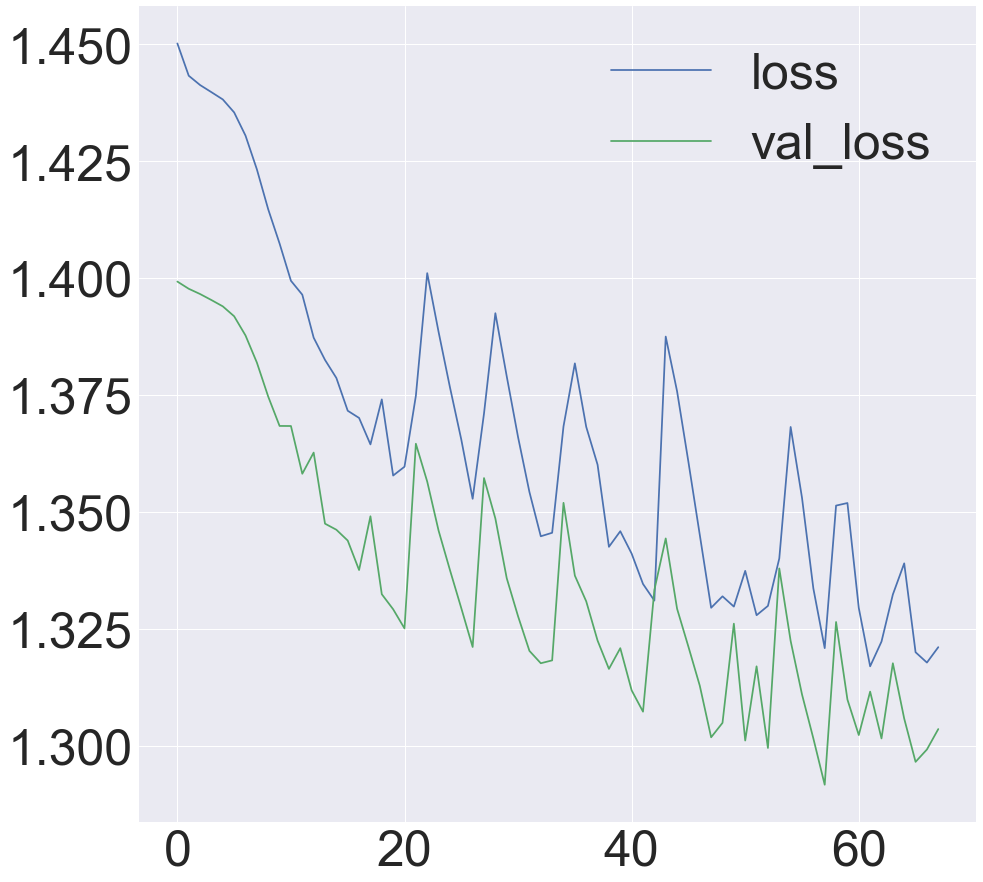

In [106]:
loss     = np.sqrt(train_log.history['loss'])
val_loss = np.sqrt(train_log.history['val_loss'])
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [193]:
import keras
from keras import backend as K
model = keras.models.load_model('mlp_model.h5')
# model = mlp_model
x = X_val_norm
get_last_innter_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-3].output])
# output in test mode = 0
layer_output = np.asarray(get_last_innter_layer_output([x, 0])[0])



NameError: name 'X_val_norm' is not defined

In [138]:
layer_output.shape

(238172, 32)

<Figure size 720x1440 with 0 Axes>

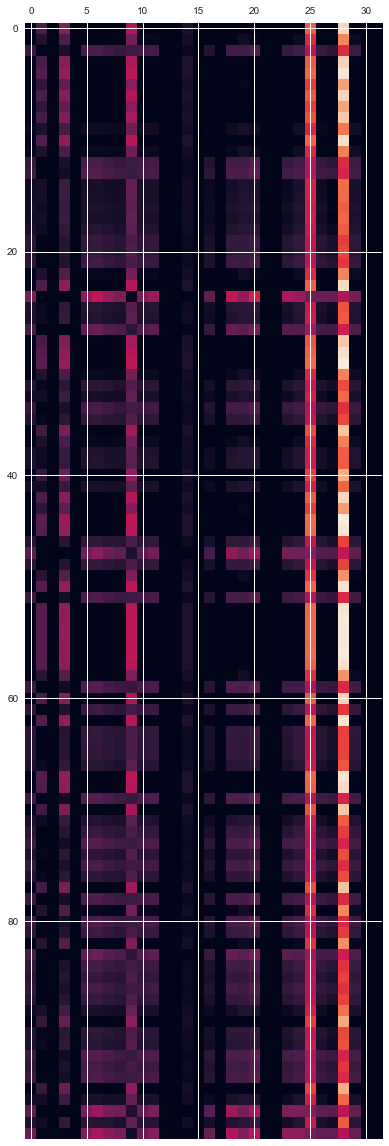

In [169]:
# Display matrix
m = layer_output[1000:1100,:]
plt.figure(figsize=(10,20))
plt.matshow(m, fignum=1)


In [190]:
model = mlp_model
x = transformer.transform(sales_m[x_cols])
get_last_innter_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-3].output])
# output in test mode = 0
layer_output = np.asarray(get_last_innter_layer_output([x, 0])[0])
layer_output.shape


NameError: name 'mlp_model' is not defined

### Ensembling

* predicted results
* Useful features
* Neural network feature

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

In [69]:
#RF_regr  = pickle.load( open("RF_regr.pkl", "rb"))
lgb_model      = pickle.load(open("lgb_model.pkl"     , 'rb'))
catboost_model = pickle.load(open("catboost_model.pkl", "rb"))
LR_model       = pickle.load(open("LR_model.pkl", "rb"))
def get_name( model):
    return str(model.__class__).split('\'')[1].replace('.','_').lower()

pred_train={}
pred_val={}
pred_test={}

for regressor in [RF_regr, lgb_model, catboost_model, LR_model]:
    idx = get_name(regressor)
    print('Predict train...')
    pred_train[idx] = regressor.predict( X_train )
    print('Predict val...')
    pred_val[idx]   = regressor.predict( X_val   )
    print('Predict test...')
    pred_test[idx]   = regressor.predict( X_test  )

    

Predict train...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished


Predict val...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Predict test...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Predict train...
Predict val...
Predict test...
Predict train...
Predict val...
Predict test...
Predict train...
Predict val...
Predict test...


In [71]:
USE_X_FEATURES = 0

if USE_X_FEATURES:
    X_train_meta = X_train.join(pd.DataFrame(pred_train, index = X_train.index))
    X_test_meta  =  X_test.join(pd.DataFrame(pred_test,  index = X_test.index))
    X_val_meta   =   X_val.join(pd.DataFrame(pred_val,   index = X_val.index))
else:
    X_train_meta = pd.DataFrame(pred_train, index = X_train.index)
    X_test_meta  = pd.DataFrame(pred_test,  index = X_test.index)
    X_val_meta   = pd.DataFrame(pred_val,   index = X_val.index)


In [72]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

print('Train meta model...')
meta_model = LinearRegression().fit(X_train_meta, y_train)
print('Predict meta model...')
meta_mse = metrics.mean_squared_error( y_val, meta_model.predict( X_val_meta) )
print ("Validation RMSE:  ", np.sqrt(meta_mse))


Train meta model...
Predict meta model...
Validation RMSE:   1.1134338171207547


In [74]:
meta_submission =   pd.DataFrame({ 
                                    'ID'            : test.ID,
                                    'item_cnt_month':  meta_model.predict(X_test_meta)
                        } );
meta_submission
meta_submission.to_csv('meta_submission.csv', index=False)
meta_submission.sample(30)
print('Done!')


,ID,item_cnt_month
0,0,0.492808
1,1,0.135080
2,2,1.133467
3,3,0.287953
4,4,2.727082
5,5,0.570016
6,6,0.917951
7,7,0.076973
8,8,1.173007
9,9,0.533656


,ID,item_cnt_month
51454,51454,0.199832
156684,156684,-0.012683
205428,205428,0.013722
33834,33834,0.001254
65045,65045,-0.018268
212837,212837,-0.012853
73944,73944,-0.012434
31917,31917,0.006537
113331,113331,0.078785
89519,89519,0.065997


Done!
